In [423]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from fancyimpute import IterativeImputer
from scipy.stats import shapiro
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

In [424]:
# Loading csv filet to pondas dataframe
features = pd.read_csv('features.csv')
stoes=pd.read_csv('stores.csv')
test=pd.read_csv('test.csv')
train=pd.read_csv('train.csv')

              Missing Values    Percent
Store                      0   0.000000
Date                       0   0.000000
Temperature                0   0.000000
Fuel_Price                 0   0.000000
MarkDown1               4158  50.769231
MarkDown2               5269  64.334554
MarkDown3               4577  55.885226
MarkDown4               4726  57.704518
MarkDown5               4140  50.549451
CPI                      585   7.142857
Unemployment             585   7.142857
IsHoliday                  0   0.000000


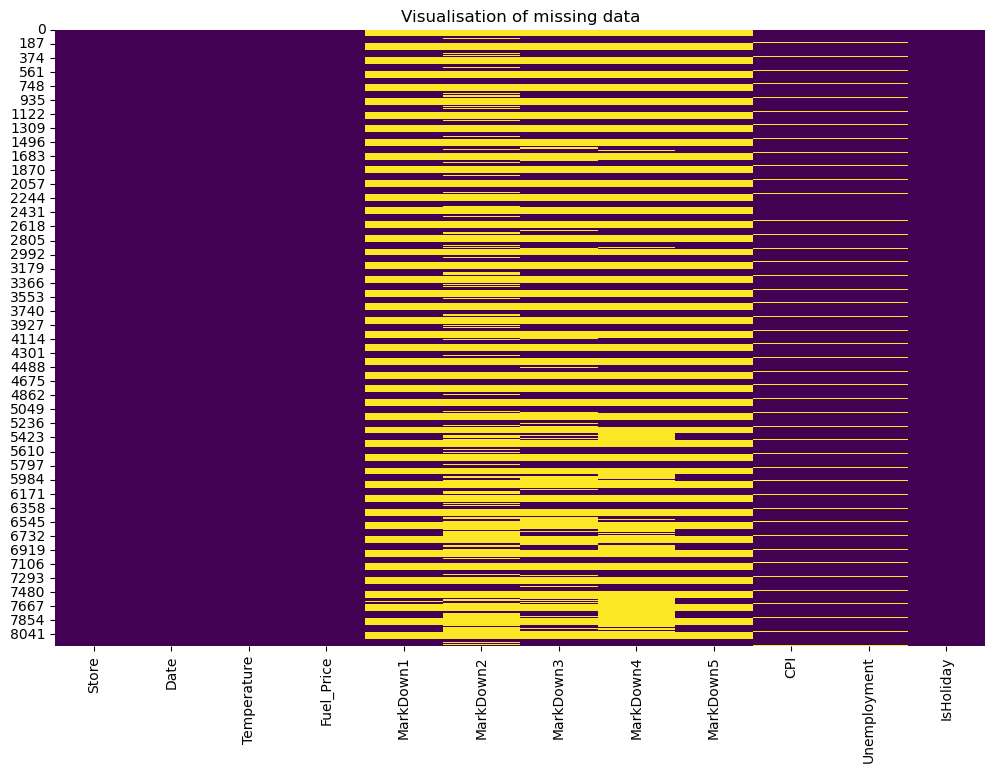

In [425]:
# checking of missing data in features

missing_values = features.isnull().sum()
missing_percent = (features.isnull().sum() / len(features)) * 100


missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percent': missing_percent})
print(missing_data)



plt.figure(figsize=(12, 8))
sns.heatmap(features.isnull(), cbar=False, cmap='viridis')
plt.title('Visualisation of missing data')
plt.show()

we can see that the amount of missing data in CPI and Unemployment is not high, so we can try to fix it but lets try concatenate features with train and test csv and check corelation matrix

In [426]:
# cat_df=train.append(test, ignore_index=True)
cat_df=train

grouped_cat=cat_df.groupby(['Store', 'Date']).agg({'Weekly_Sales': 'sum'}).reset_index()

grouped_cat['Date'] = pd.to_datetime(grouped_cat['Date'])
features['Date'] = pd.to_datetime(features['Date'])
merged_data_WO_imp = pd.merge(grouped_cat, features, on=['Store', 'Date'], how='left')

print(f'Liczba wierszy w grouped_data: {len(grouped_cat)}')
print(f'Liczba wierszy w merged_data: {len(merged_data_WO_imp)}')


Liczba wierszy w grouped_data: 6435
Liczba wierszy w merged_data: 6435


In [427]:

mice_imputer = IterativeImputer()
merged_data_W_imp=merged_data_WO_imp.copy()

merged_data_W_imp[['CPI', 'Unemployment']] = mice_imputer.fit_transform(merged_data_WO_imp[['CPI', 'Unemployment']])


print('Missing data with imputer')
print(merged_data_WO_imp[['CPI', 'Unemployment']].isnull().sum())
print('Missing data without imputer')
print(merged_data_W_imp[['CPI', 'Unemployment']].isnull().sum())

Missing data with imputer
CPI             0
Unemployment    0
dtype: int64
Missing data without imputer
CPI             0
Unemployment    0
dtype: int64


Now compare corelation matrix between dataset with missing value CPI and Unemployment we dont compare markdown1-5 becasue stil have missing values

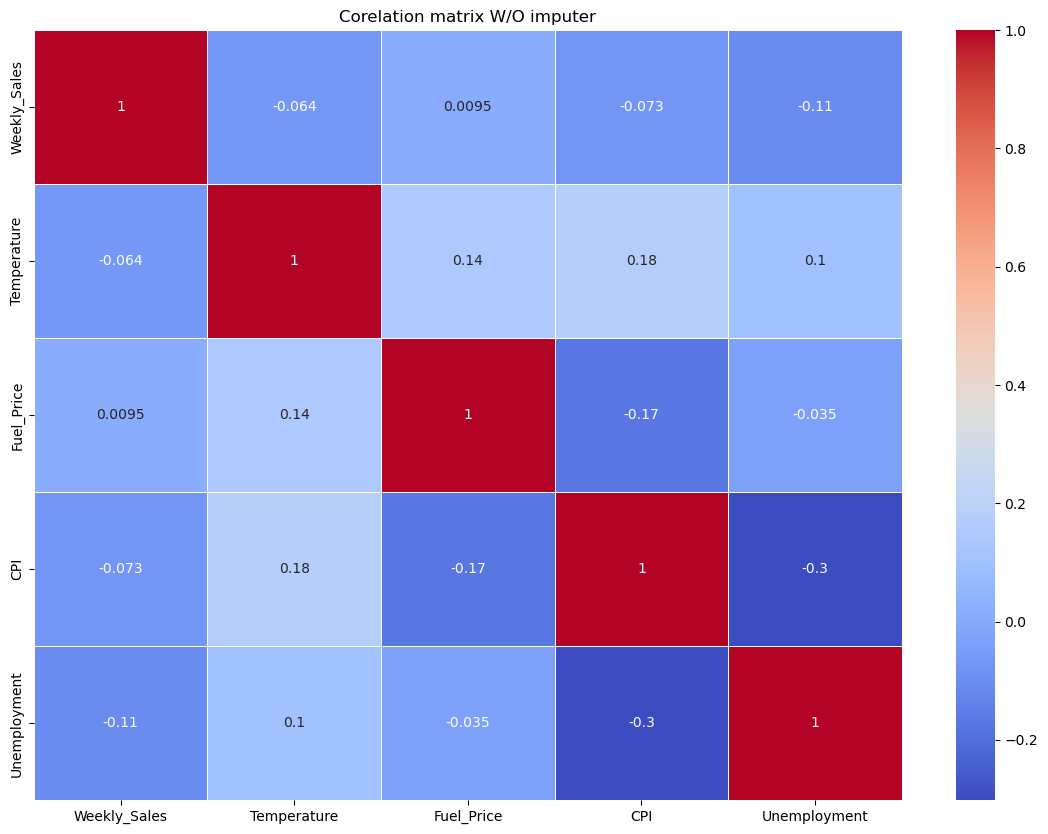

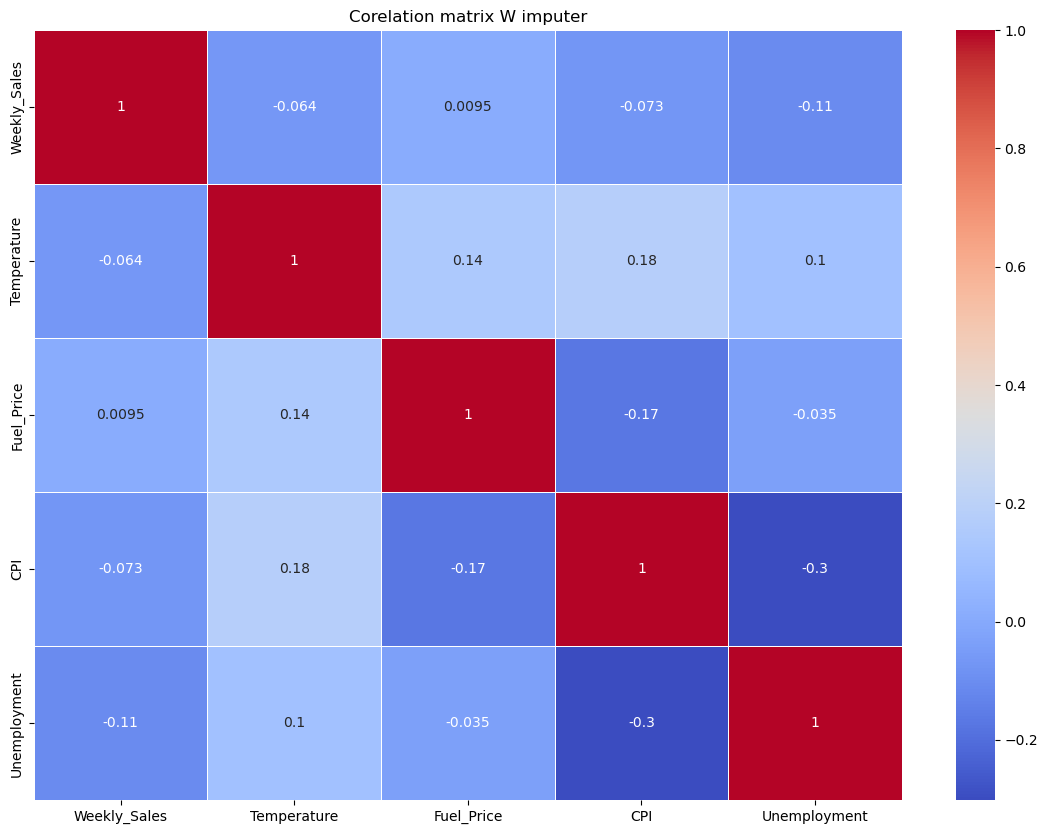

In [428]:


corr_columns = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']


correlation_matrix_WO_imp = merged_data_WO_imp[corr_columns].corr()


plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_WO_imp, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Corelation matrix W/O imputer')
plt.show()

correlation_matrix_W_imp = merged_data_W_imp[corr_columns].corr()


plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_W_imp, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Corelation matrix W imputer')
plt.show()

in my opinion imputer work good enought its small diferences between [CPI, Unemployment] and Weekly_Sales

We ned to decide what to do with markdown1-5

In [429]:
# test shapiro
markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
shapiro_results={}

for col in markdown_columns:
    data = merged_data_W_imp[col].dropna()
        # Wykonanie testu
    stat, p_value = shapiro(data)
        # Zapisanie wyników
    shapiro_results[col] = {'statistic': stat, 'p-value': p_value}

for col, result in shapiro_results.items():
    print(f'{col}: W-statistic={result["statistic"]}, p-value={result["p-value"]}')



MarkDown1: W-statistic=0.7021799087524414, p-value=0.0
MarkDown2: W-statistic=0.3756622076034546, p-value=0.0
MarkDown3: W-statistic=0.12676095962524414, p-value=0.0
MarkDown4: W-statistic=0.49017560482025146, p-value=0.0
MarkDown5: W-statistic=0.4799940586090088, p-value=0.0


So this isn't normal distrribution 

In [430]:
from sklearn.impute import KNNImputer

merged_data_no_empty=merged_data_W_imp.copy()


knn_imputer = KNNImputer(n_neighbors=5)


merged_data_no_empty[markdown_columns] = knn_imputer.fit_transform(merged_data_no_empty[markdown_columns])


print('Missing data after KNN imputation:')
print(merged_data_no_empty[markdown_columns].isnull().sum())


Missing data after KNN imputation:
MarkDown1    0
MarkDown2    0
MarkDown3    0
MarkDown4    0
MarkDown5    0
dtype: int64


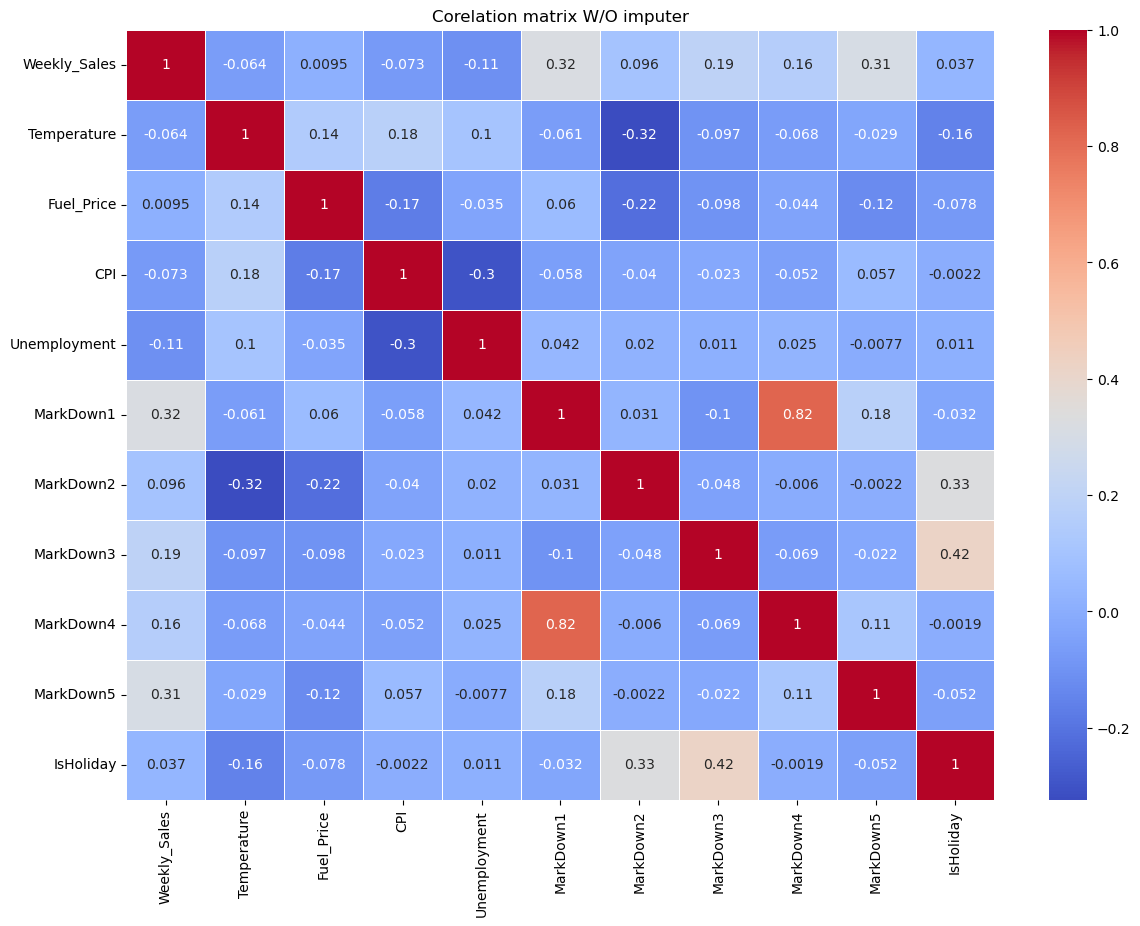

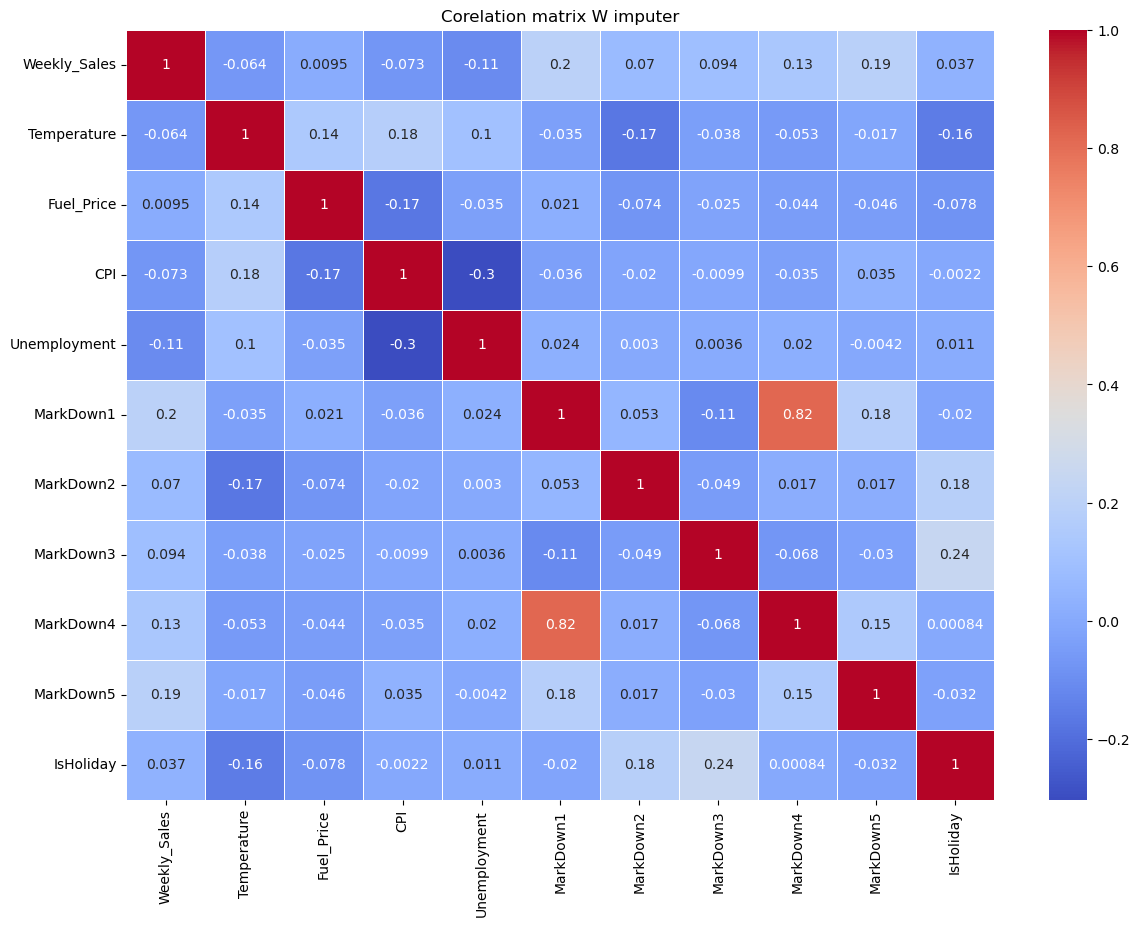

In [431]:

corr_columns = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment','MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5','IsHoliday']


correlation_matrix_WO_imp = merged_data_WO_imp[corr_columns].corr()


plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_WO_imp, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Corelation matrix W/O imputer')
plt.show()

correlation_matrix_no_empty = merged_data_no_empty[corr_columns].corr()


plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_no_empty, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Corelation matrix W imputer')
plt.show()

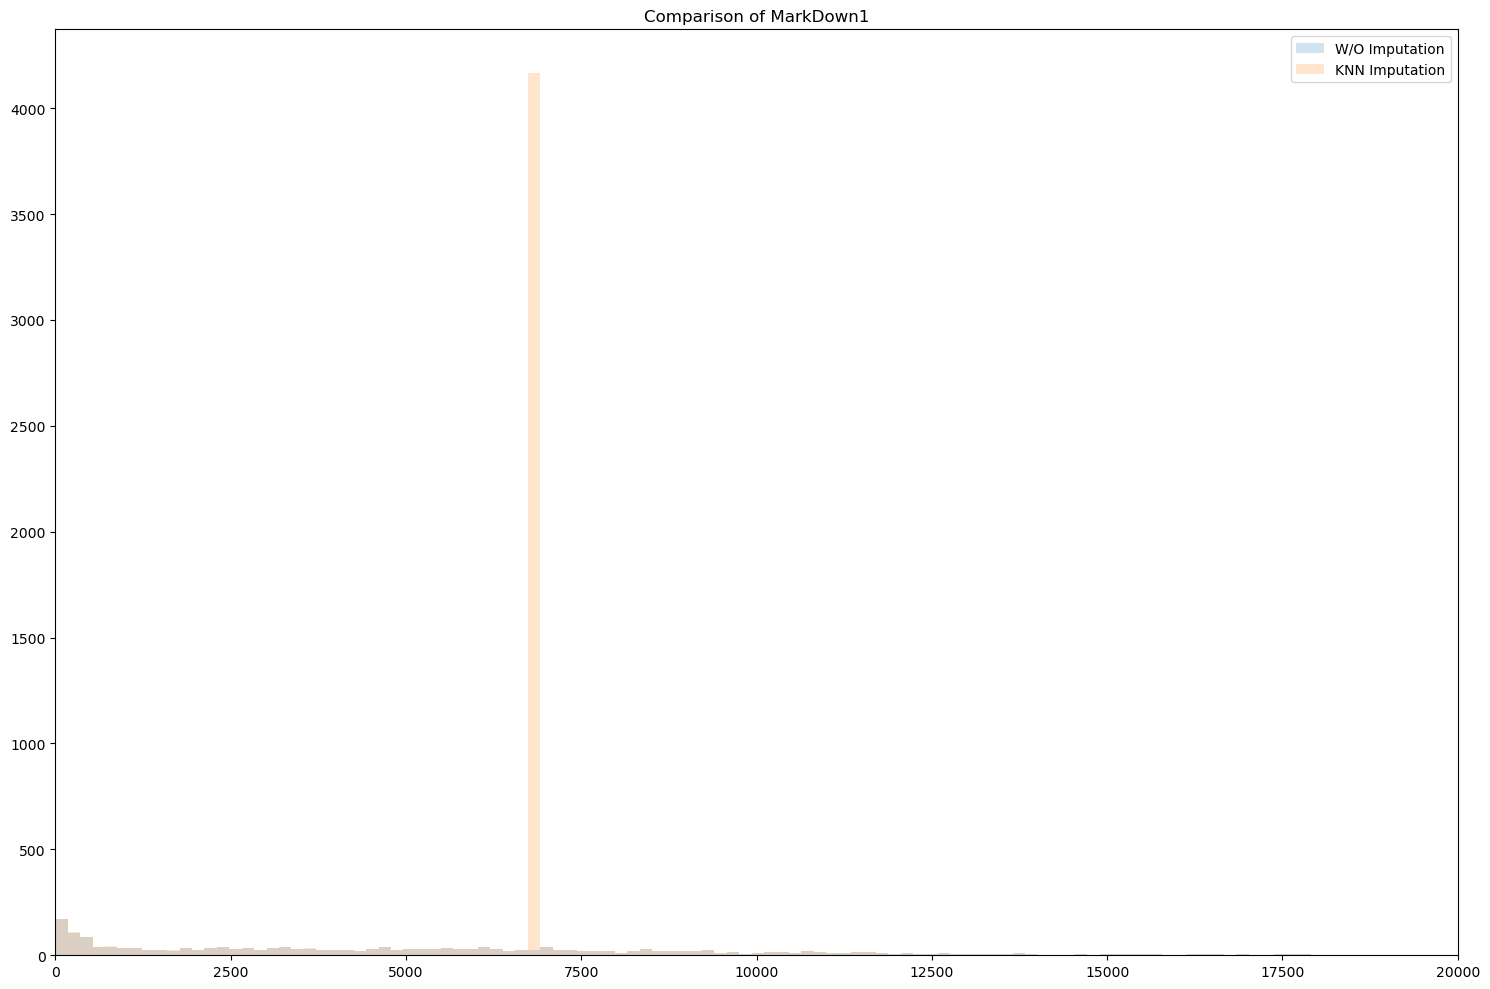

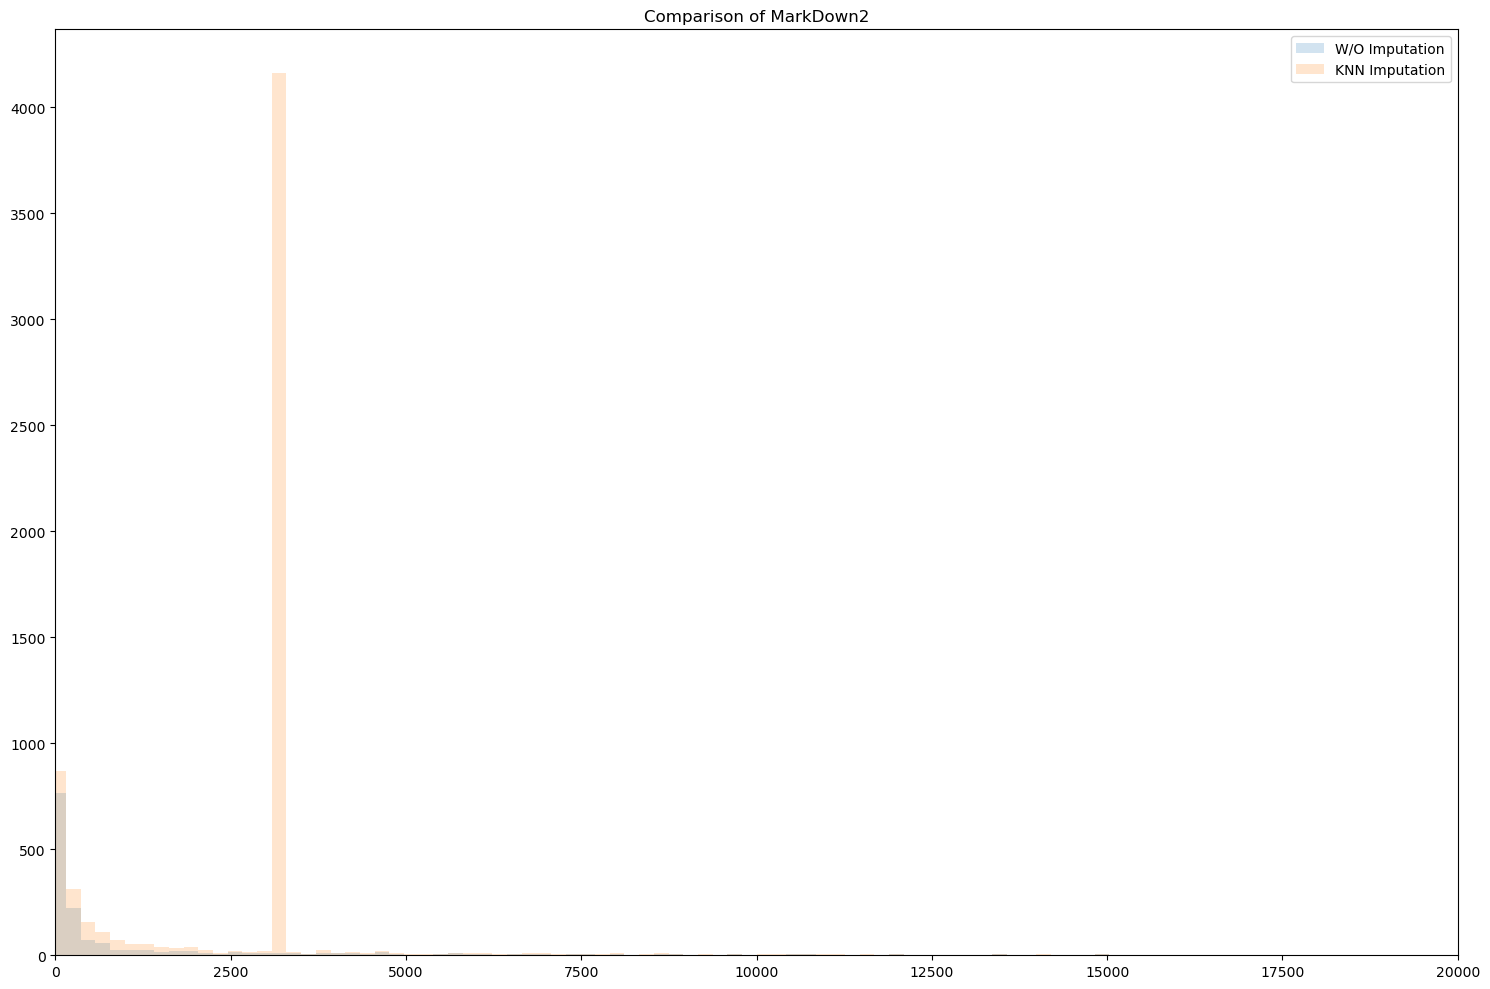

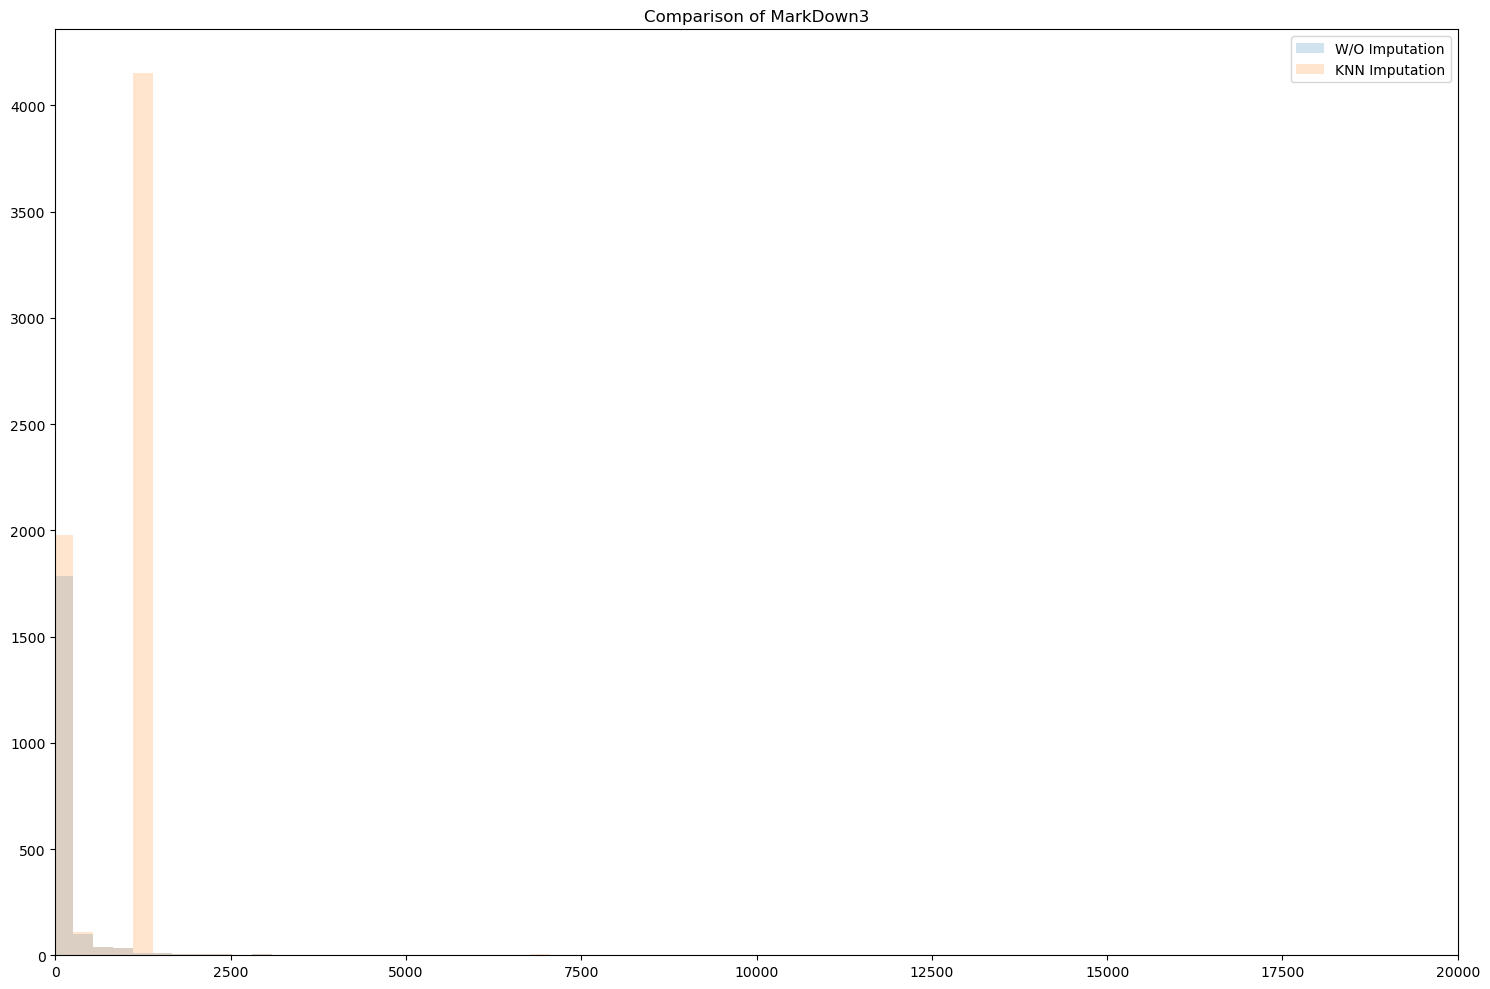

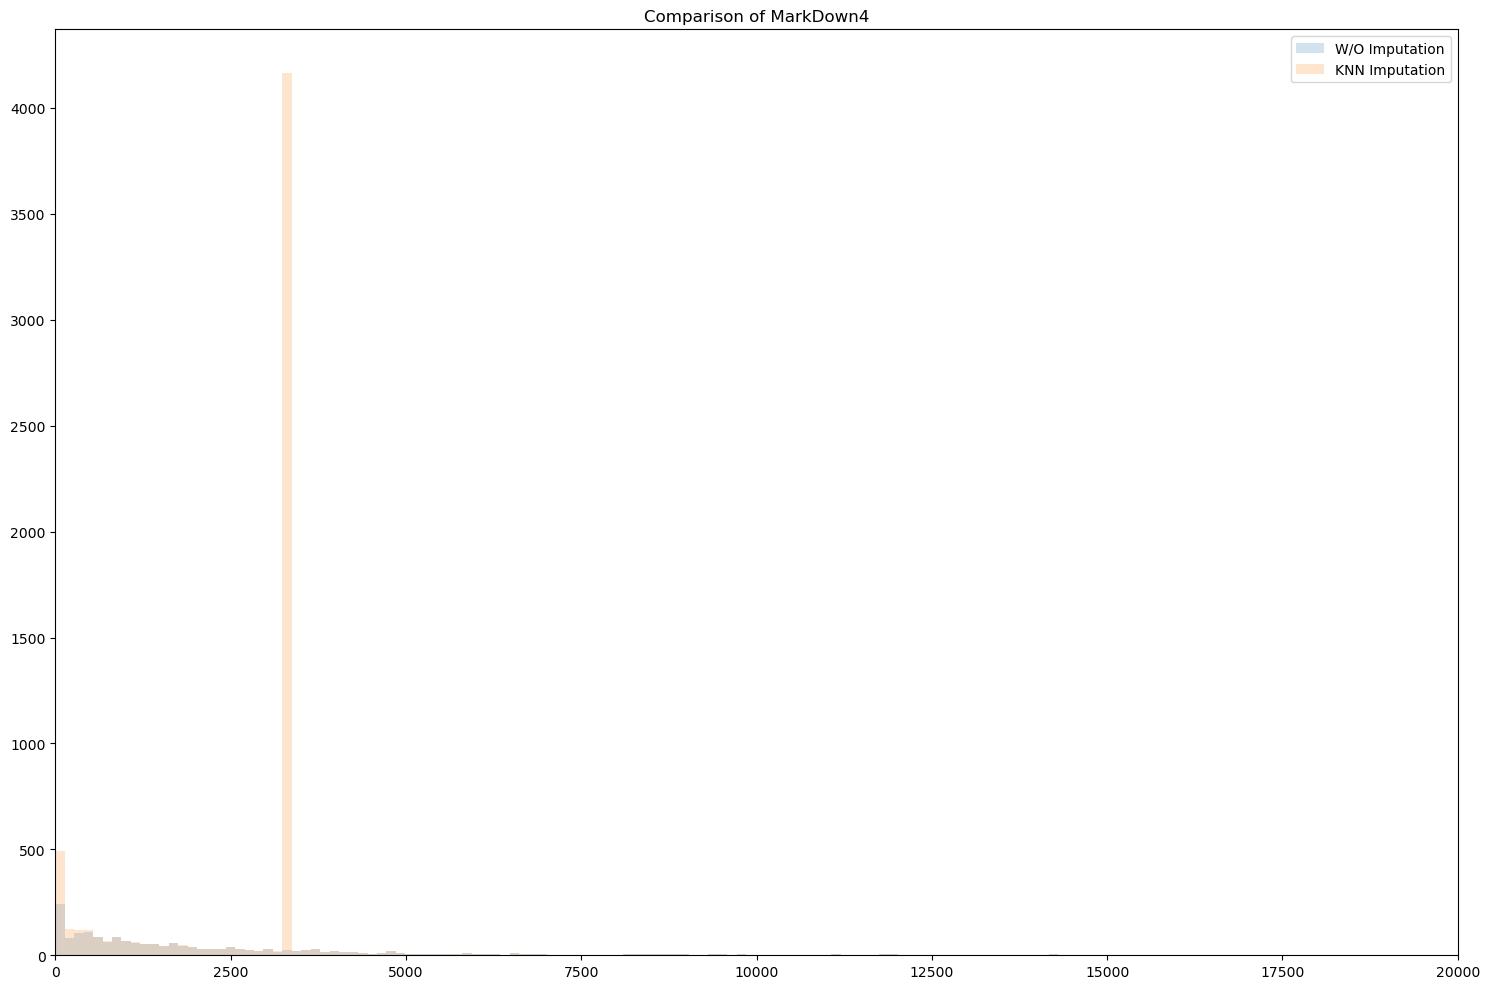

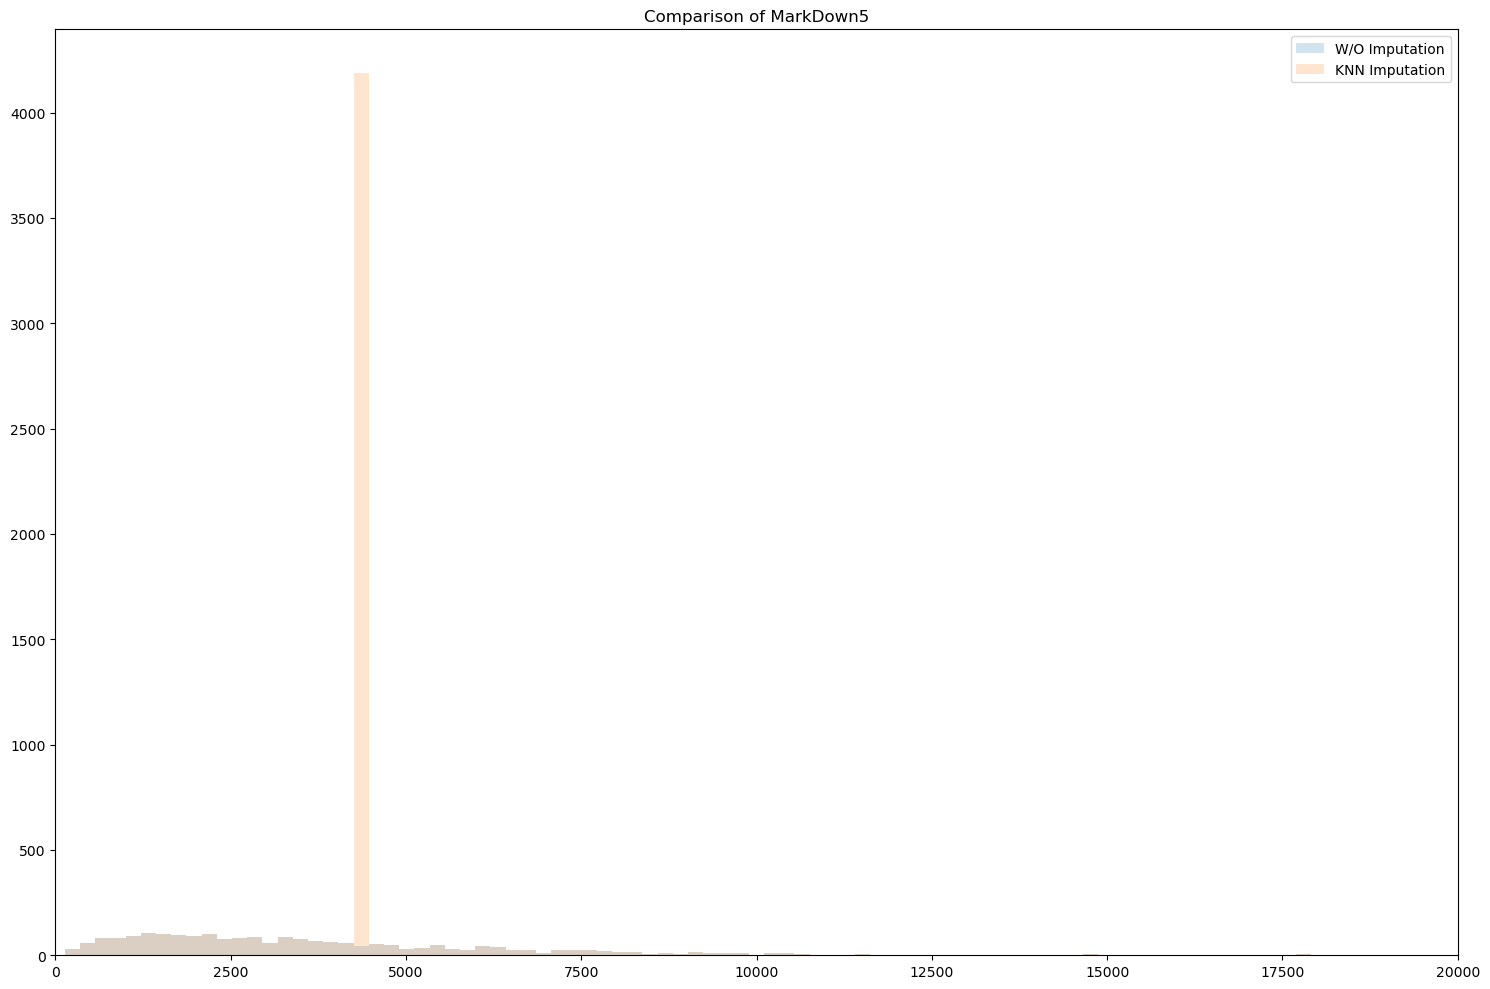

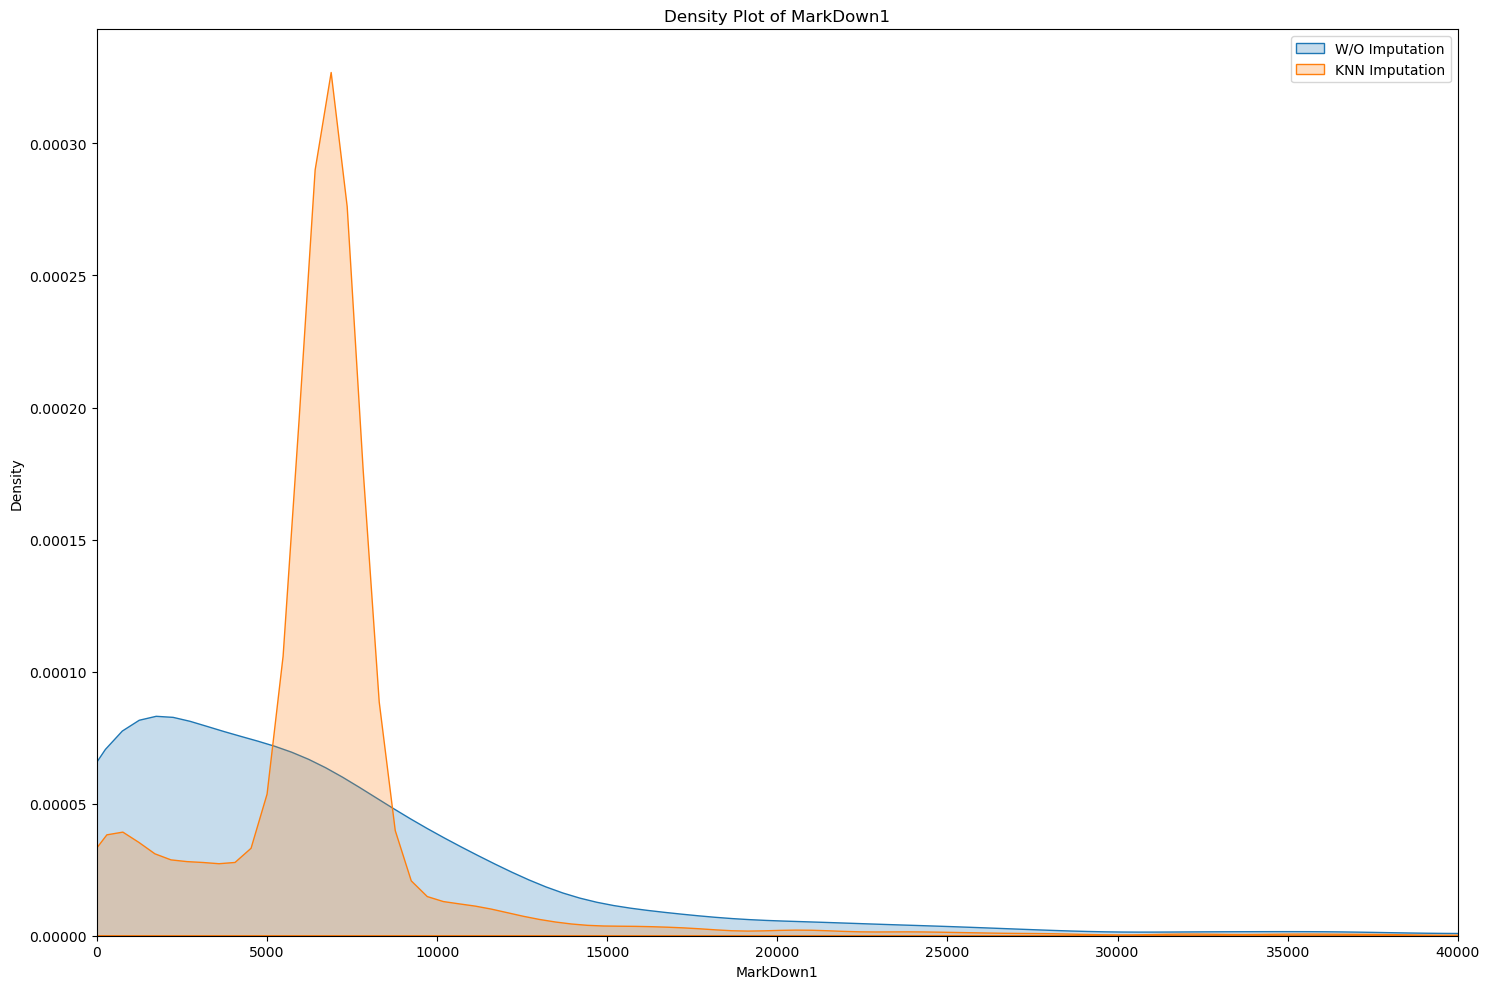

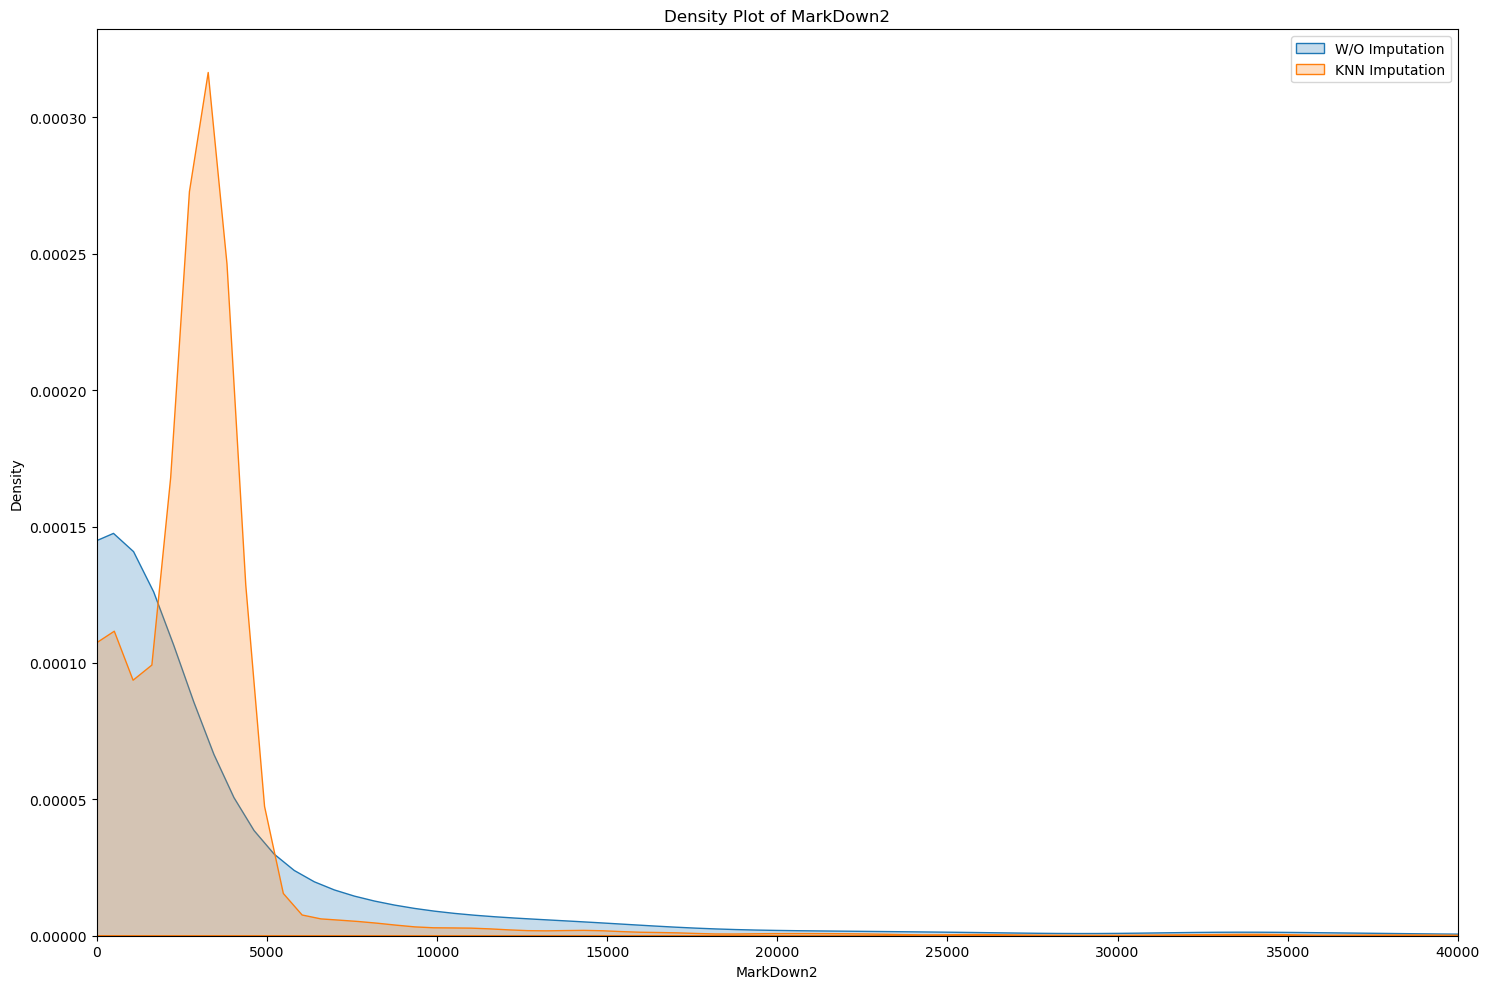

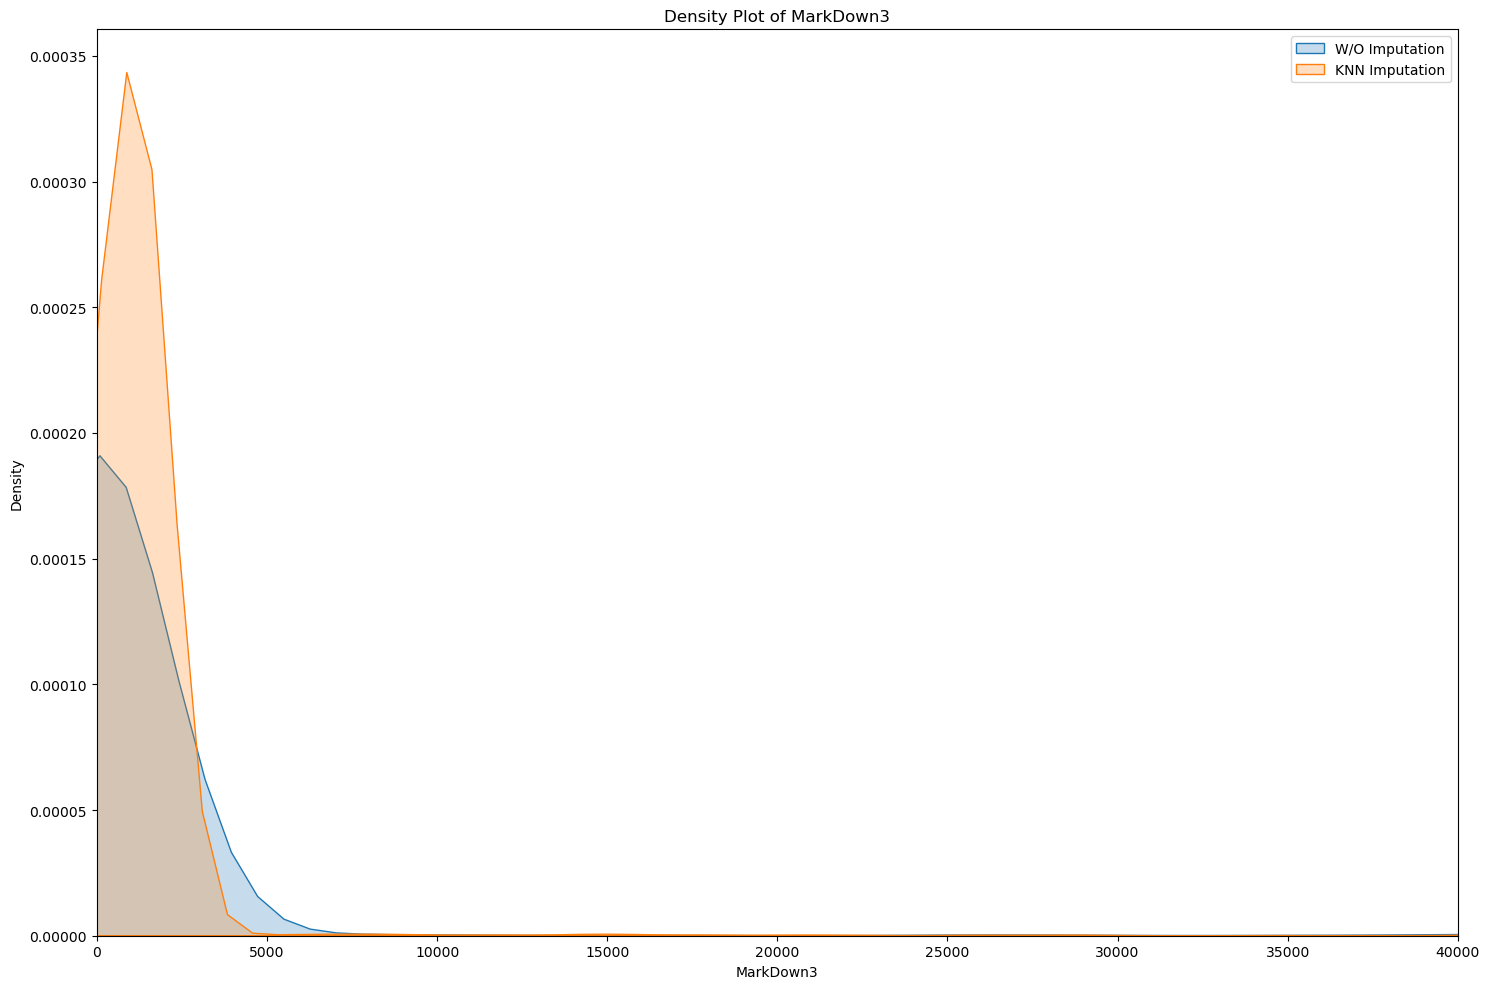

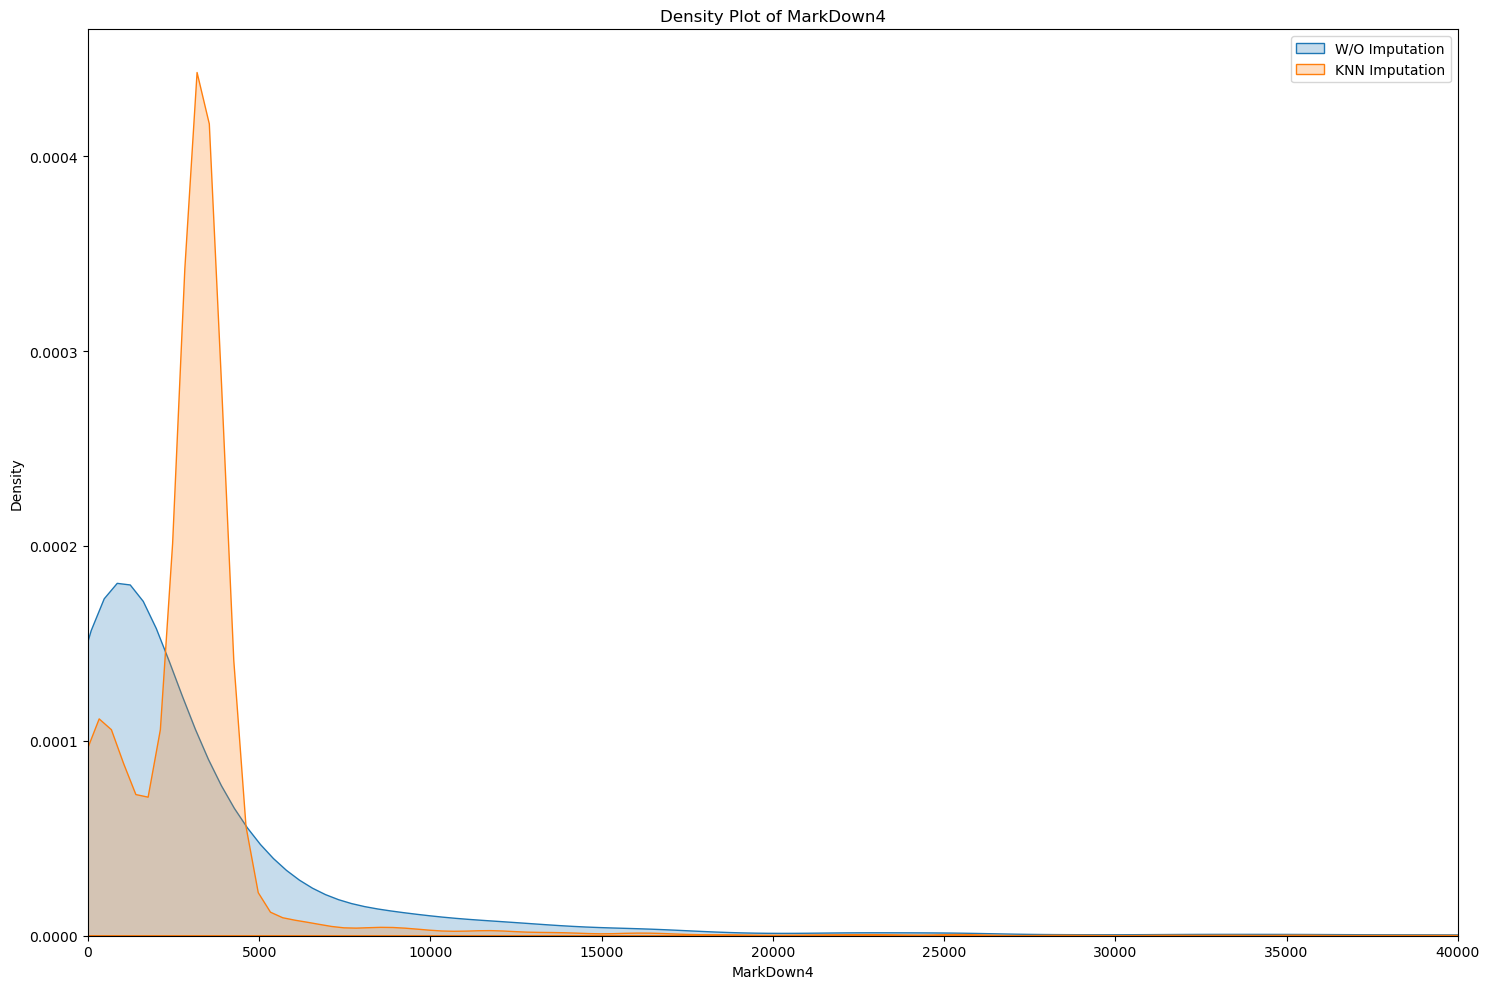

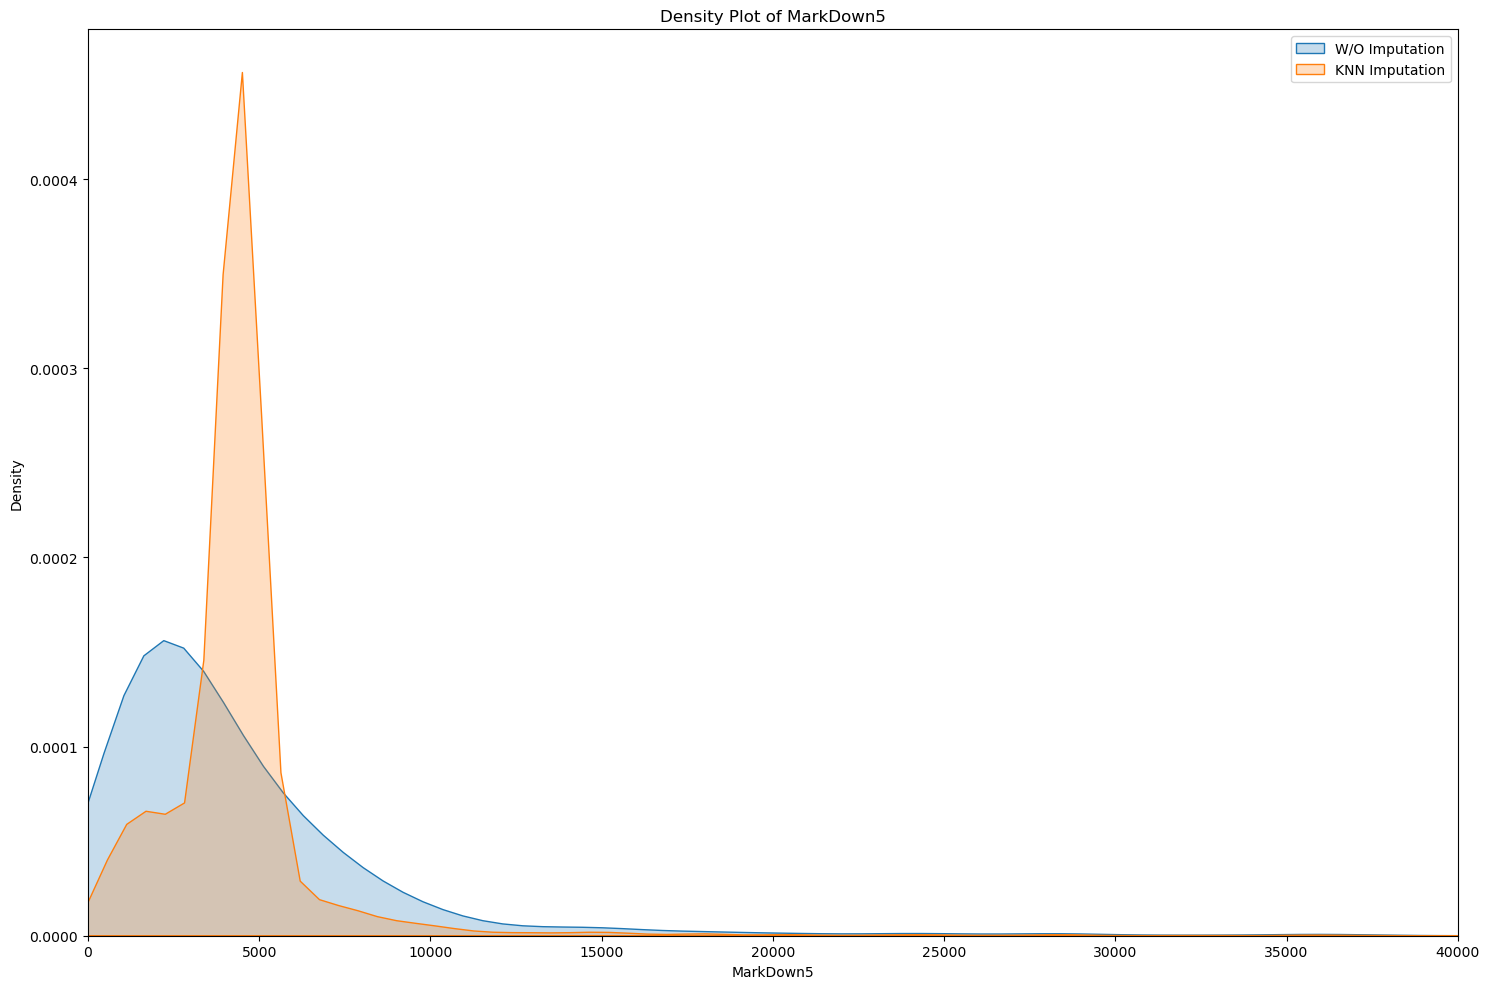

In [432]:
markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']




for i, col in enumerate(markdown_columns, start=1):
    plt.figure(figsize=(15, 10))
    # plt.subplot(6, 1, i)
    plt.hist(merged_data_W_imp[col].dropna(), bins=500, alpha=0.2, label='W/O Imputation')
    plt.hist(merged_data_no_empty[col].dropna(), bins=500, alpha=0.2, label='KNN Imputation')
    plt.xlim(0, 20000)
    plt.title(f'Comparison of {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()



# plt.figure(figsize=(15, 10))

# for i, col in enumerate(markdown_columns, start=1):
#     # plt.subplot(6, 1, i)
#     plt.boxplot([merged_data_W_imp[col].dropna(), merged_data_no_empty[col].dropna()], labels=['W/O ', 'KNN'])
#     plt.title(f'Box Plot of {col}')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()



for i, col in enumerate(markdown_columns, start=1):
    plt.figure(figsize=(15, 10))
    # plt.subplot(6, 1, i)
    sns.kdeplot(merged_data_W_imp[col].dropna(), shade=True, label='W/O Imputation')
    sns.kdeplot(merged_data_no_empty[col].dropna(), shade=True, label='KNN Imputation')
    plt.xlim(0, 40000)
    plt.title(f'Density Plot of {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()









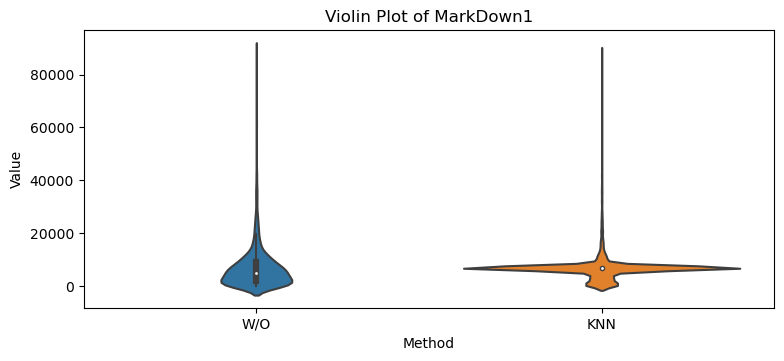

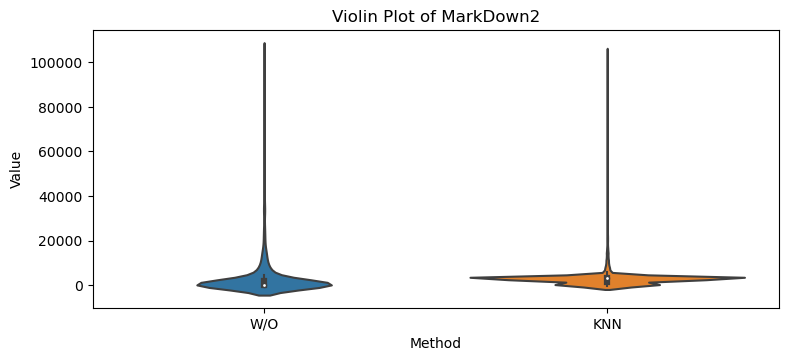

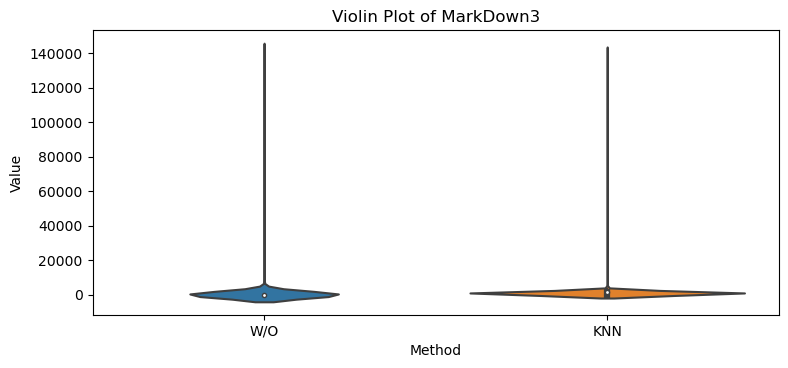

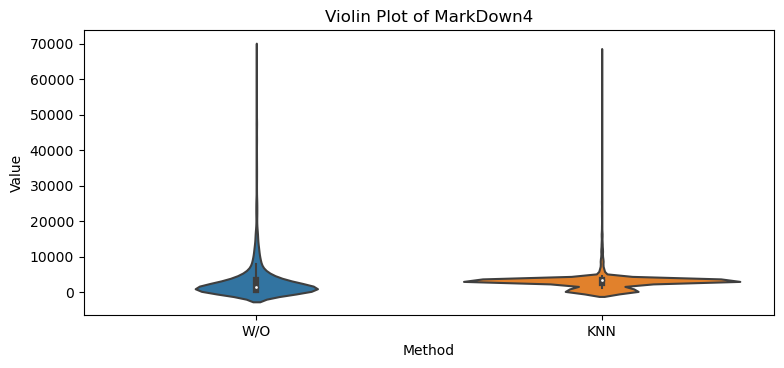

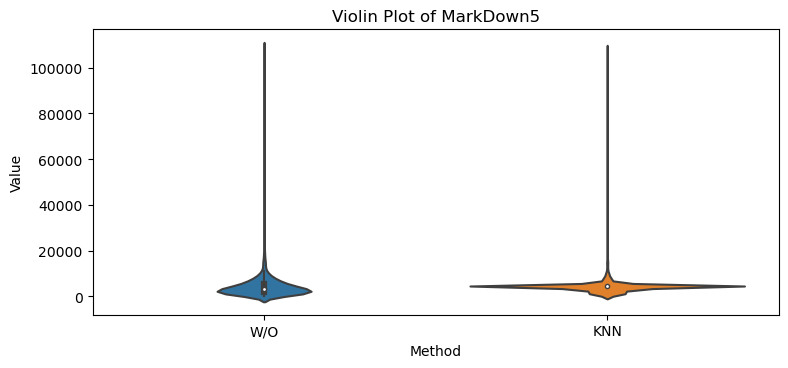

In [433]:
data_melted = pd.DataFrame()
for col in markdown_columns:
    temp_df = pd.DataFrame({
        'Value': merged_data_W_imp[col].dropna(),
        'Column': col,
        'Method': 'W/O'
    })
    data_melted = pd.concat([data_melted, temp_df], ignore_index=True)
    
    temp_df = pd.DataFrame({
        'Value': merged_data_no_empty[col].dropna(),
        'Column': col,
        'Method': 'KNN'
    })
    data_melted = pd.concat([data_melted, temp_df], ignore_index=True)




for i, col in enumerate(markdown_columns, start=1):
    plt.figure(figsize=(15, 10))
    plt.subplot(3, 2, i)
    sns.violinplot(x='Method', y='Value', data=data_melted[data_melted['Column'] == col])
    plt.title(f'Violin Plot of {col}')
    plt.tight_layout()
    plt.show()



as we can see above knn didn't work very well
how does median imputing work?

In [434]:
markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

merged_data_median_imp=merged_data_W_imp.copy()
for col in markdown_columns:
    if col in merged_data_median_imp.columns:
        median_value = merged_data_median_imp[col].median()
        merged_data_median_imp[col].fillna(median_value, inplace=True)


print('Missing data after median imputation:')
print(merged_data_median_imp[markdown_columns].isnull().sum())

Missing data after median imputation:
MarkDown1    0
MarkDown2    0
MarkDown3    0
MarkDown4    0
MarkDown5    0
dtype: int64


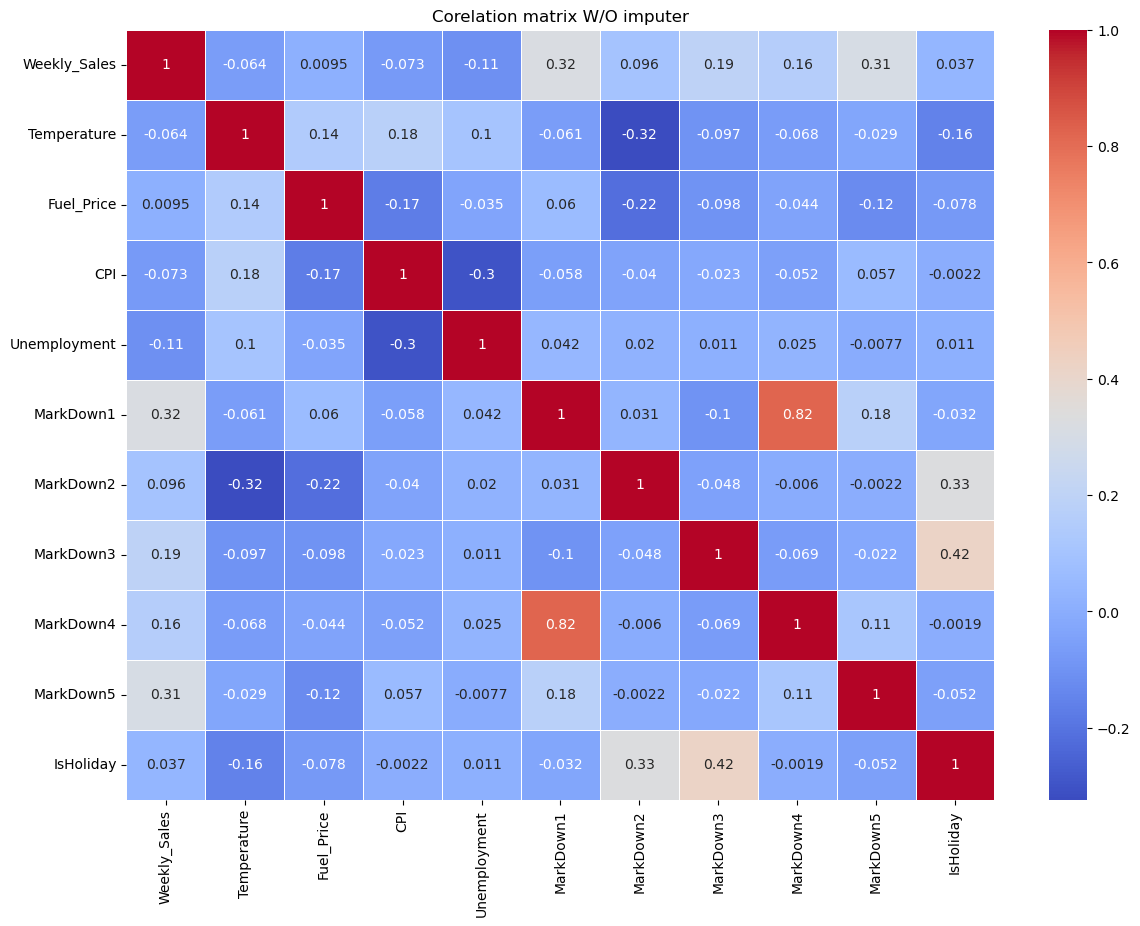

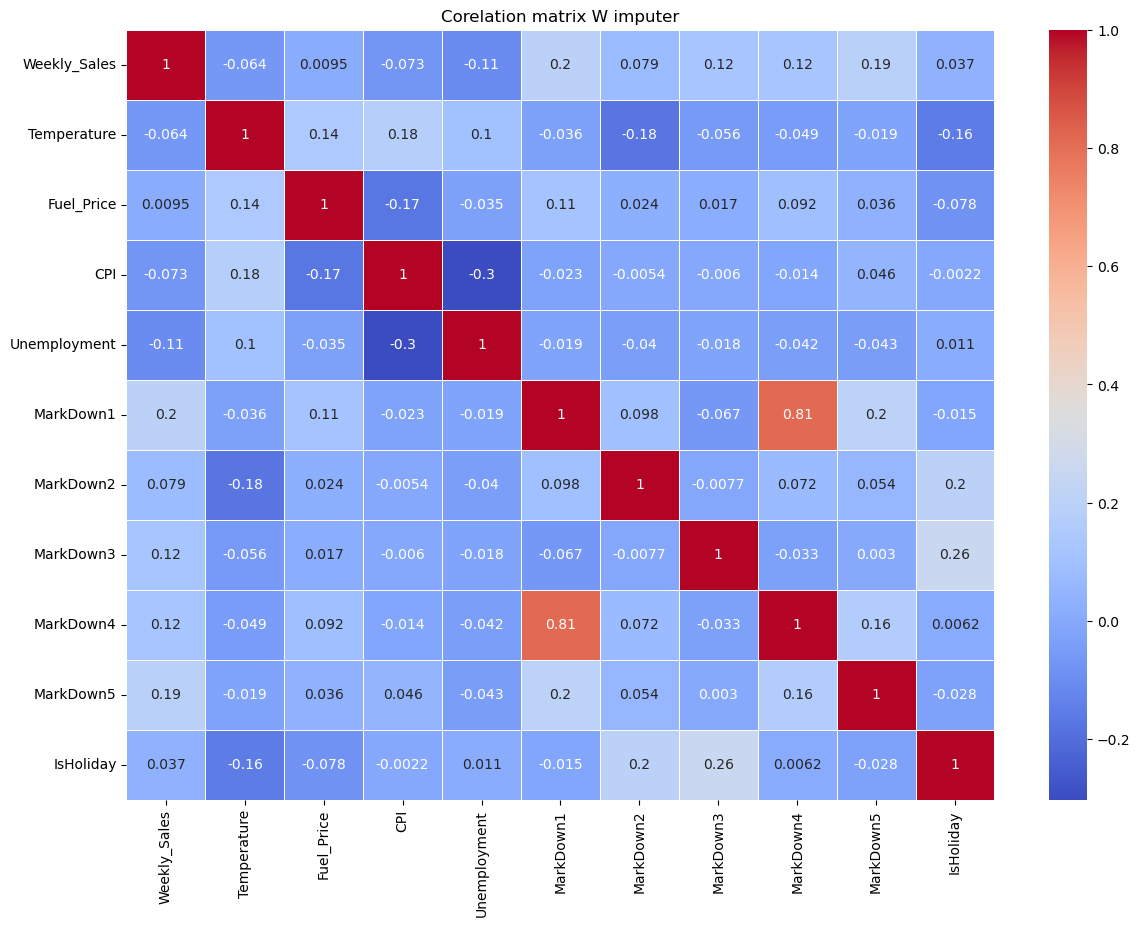

In [435]:

corr_columns = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment','MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5','IsHoliday']


correlation_matrix_WO_imp = merged_data_WO_imp[corr_columns].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_WO_imp, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Corelation matrix W/O imputer')
plt.show()

correlation_matrix_median_imp = merged_data_median_imp[corr_columns].corr()


plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_median_imp, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Corelation matrix W imputer')
plt.show()

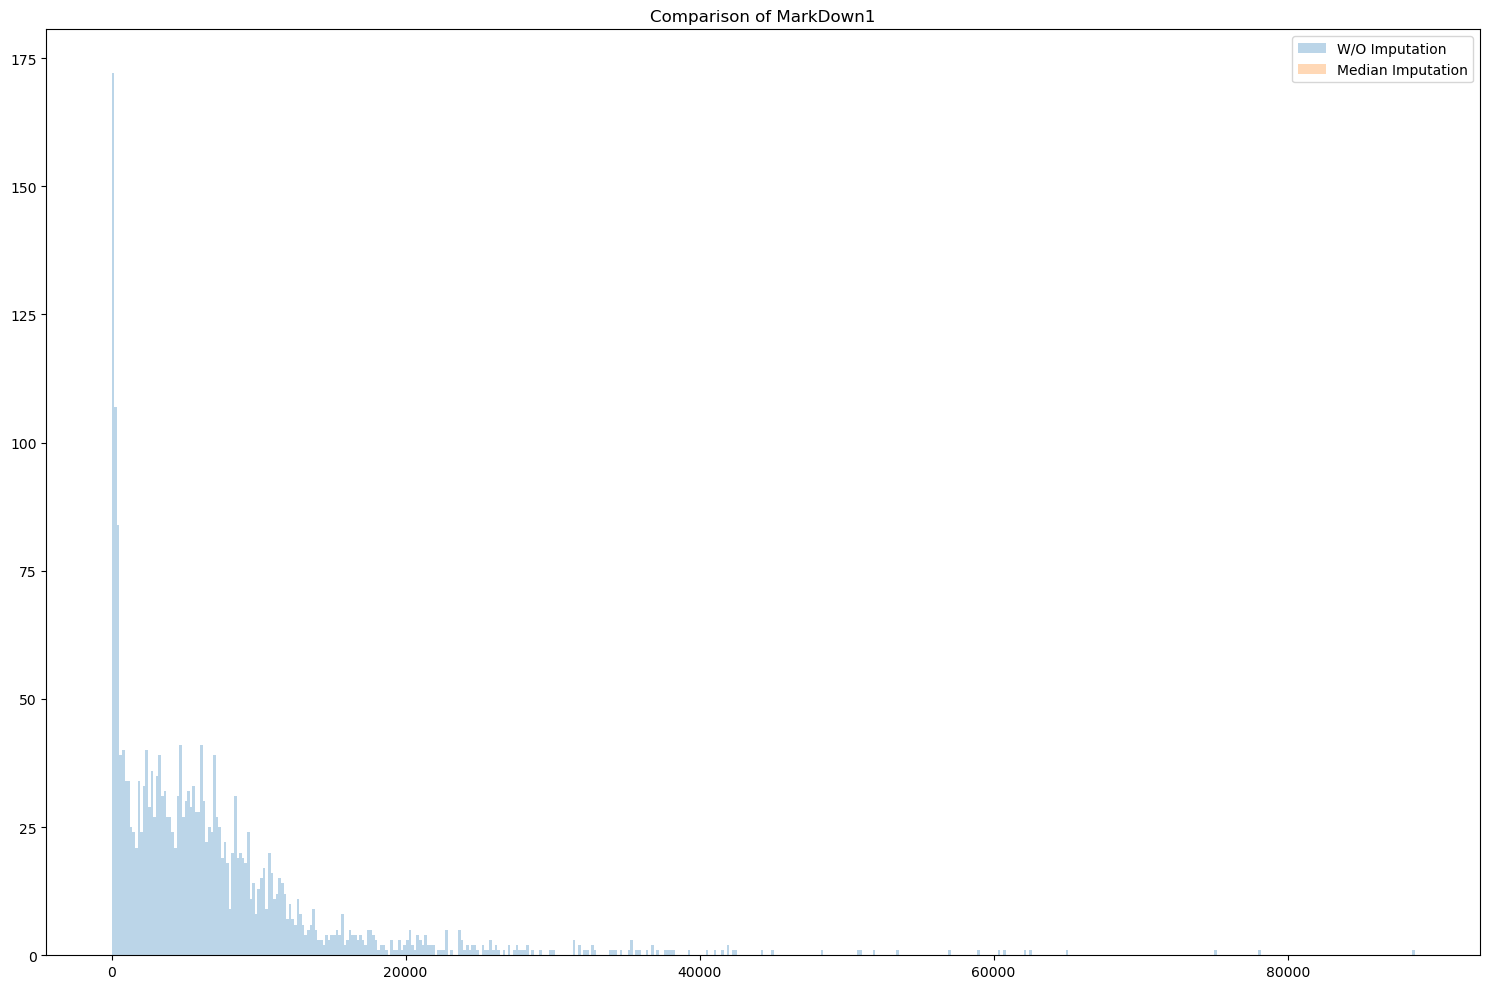

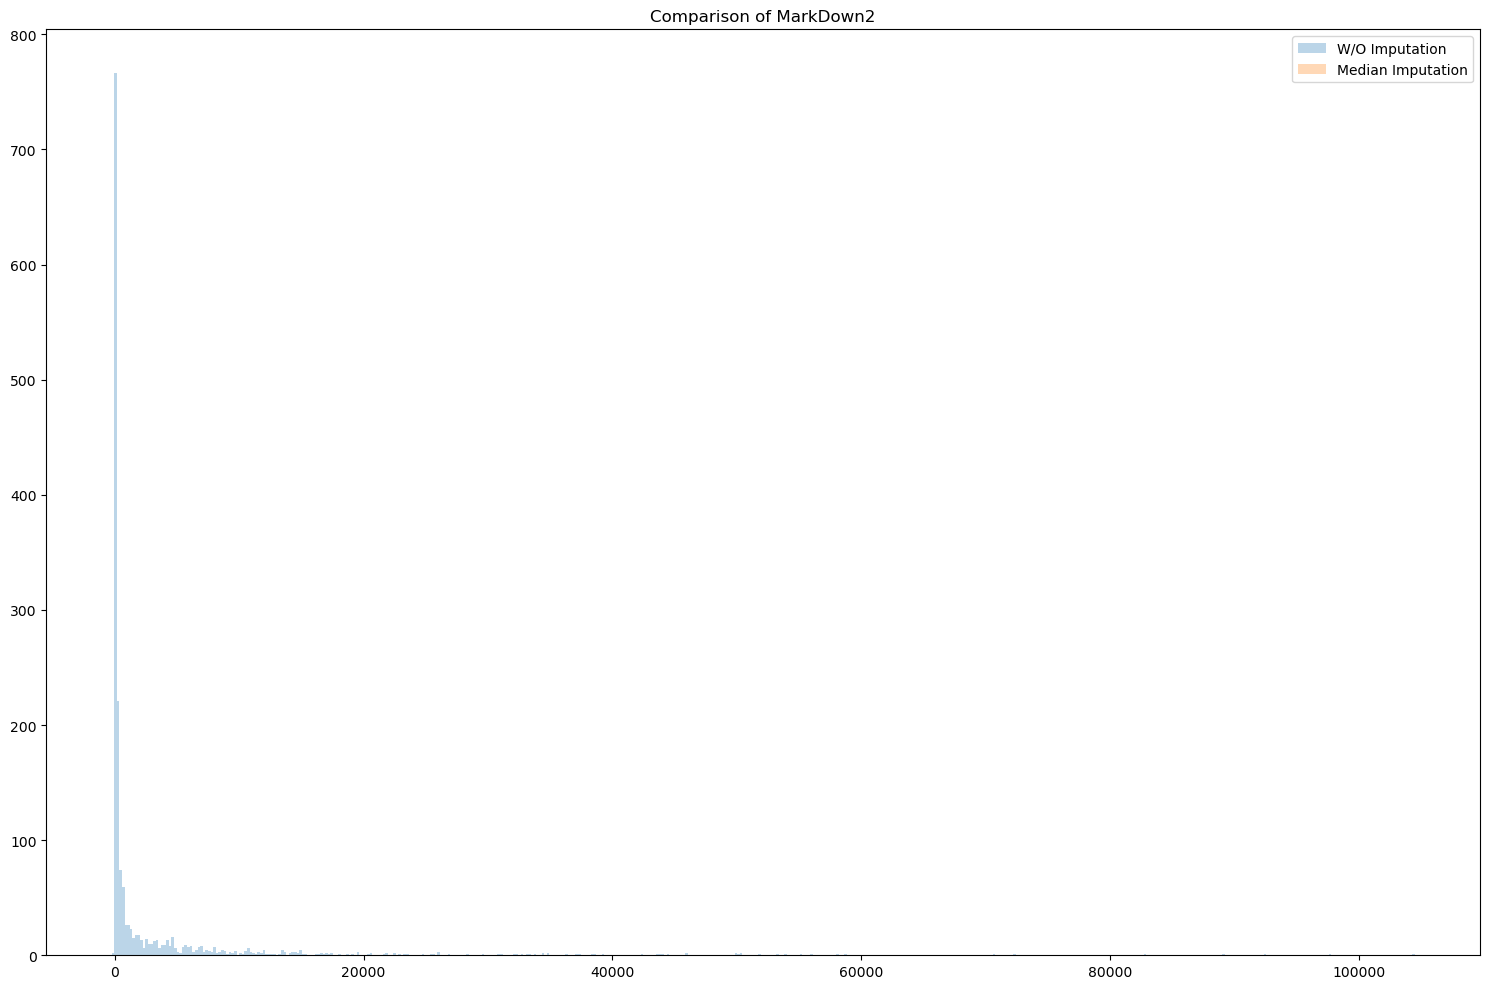

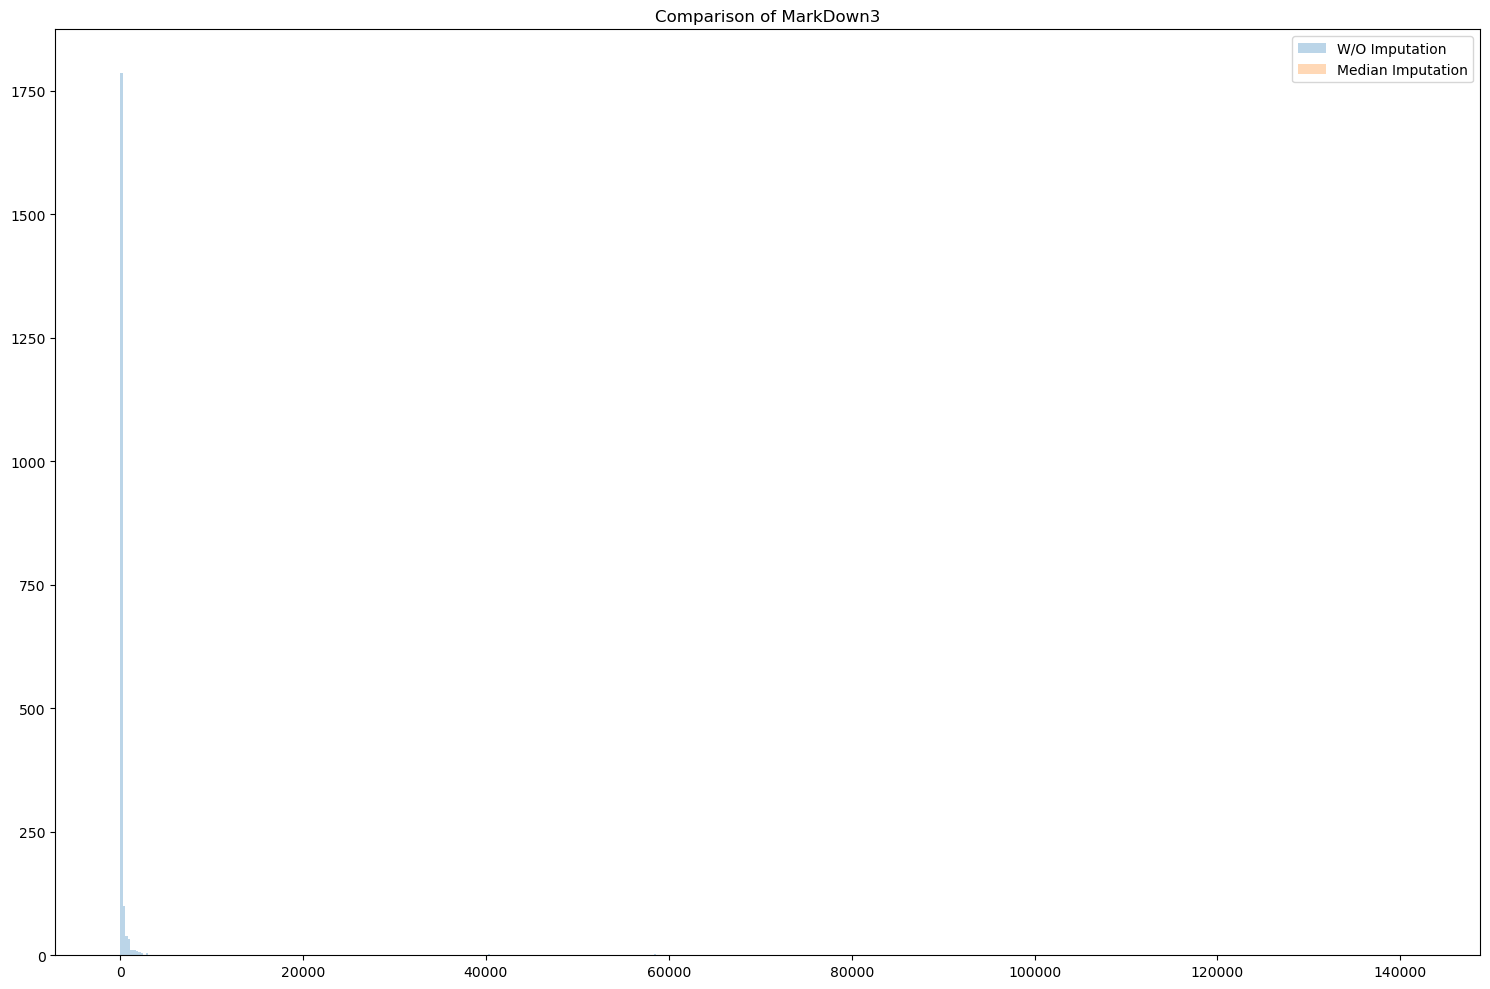

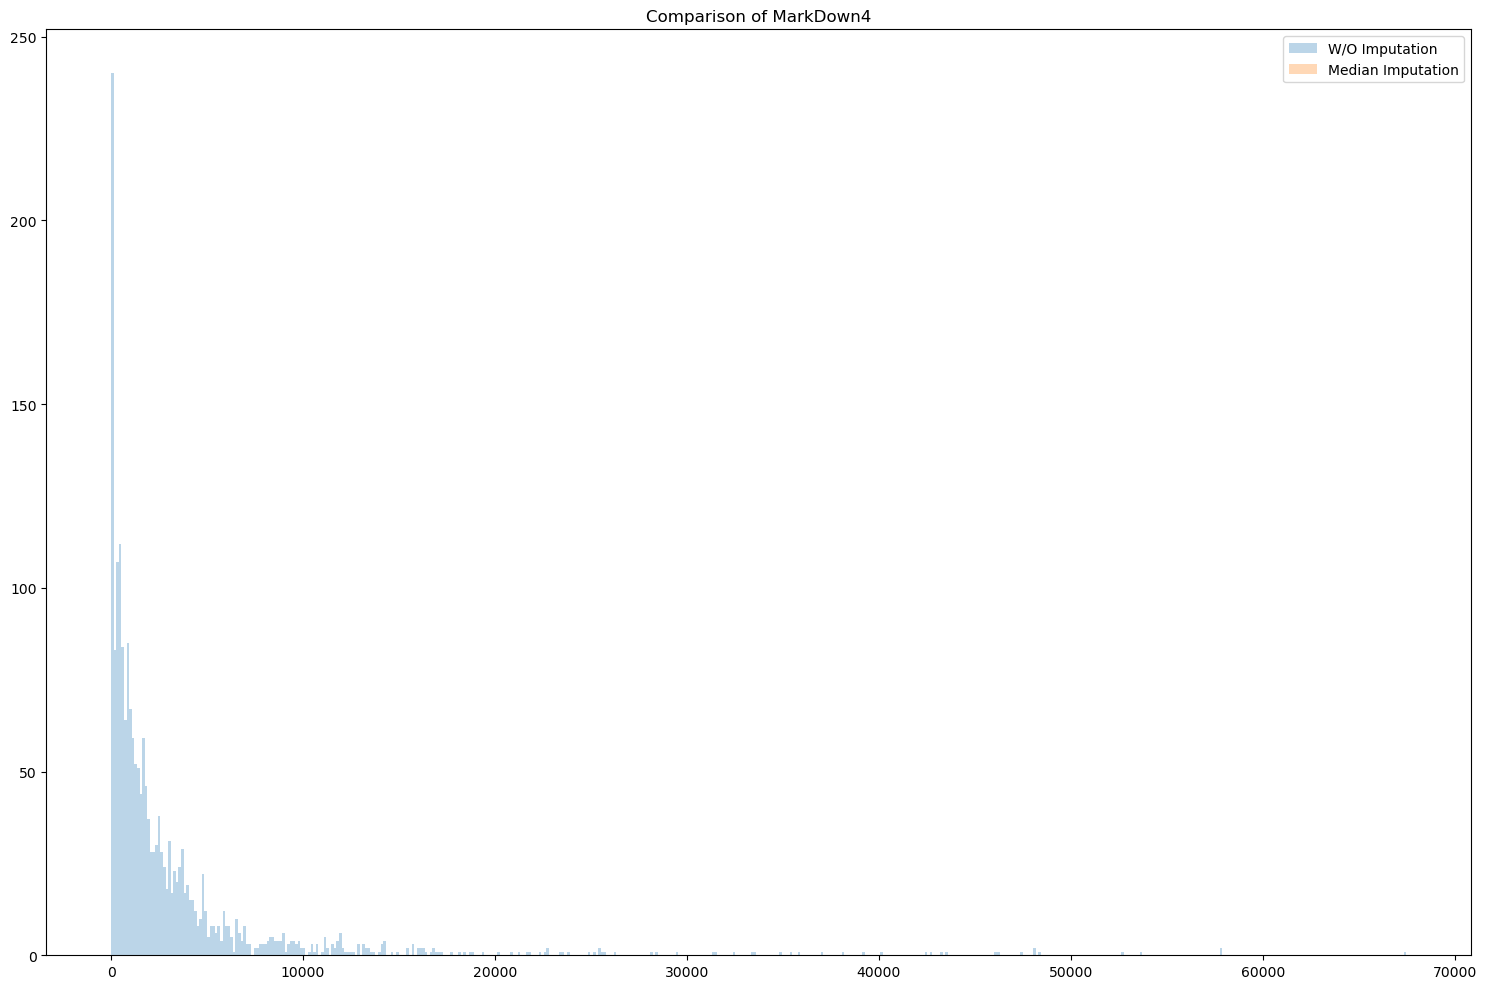

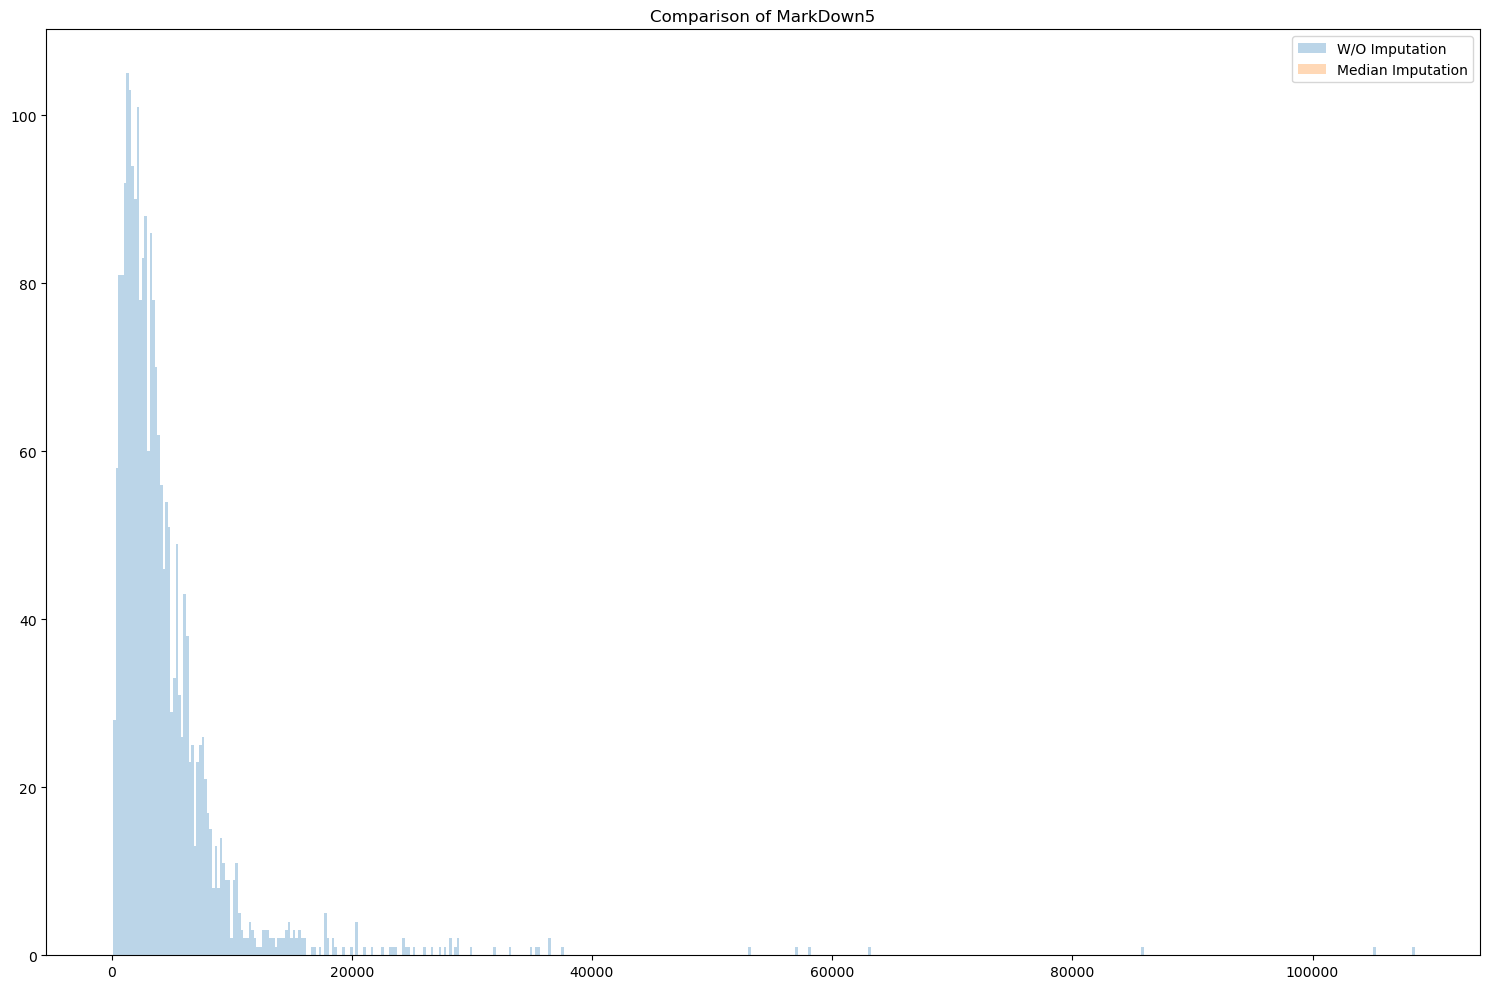

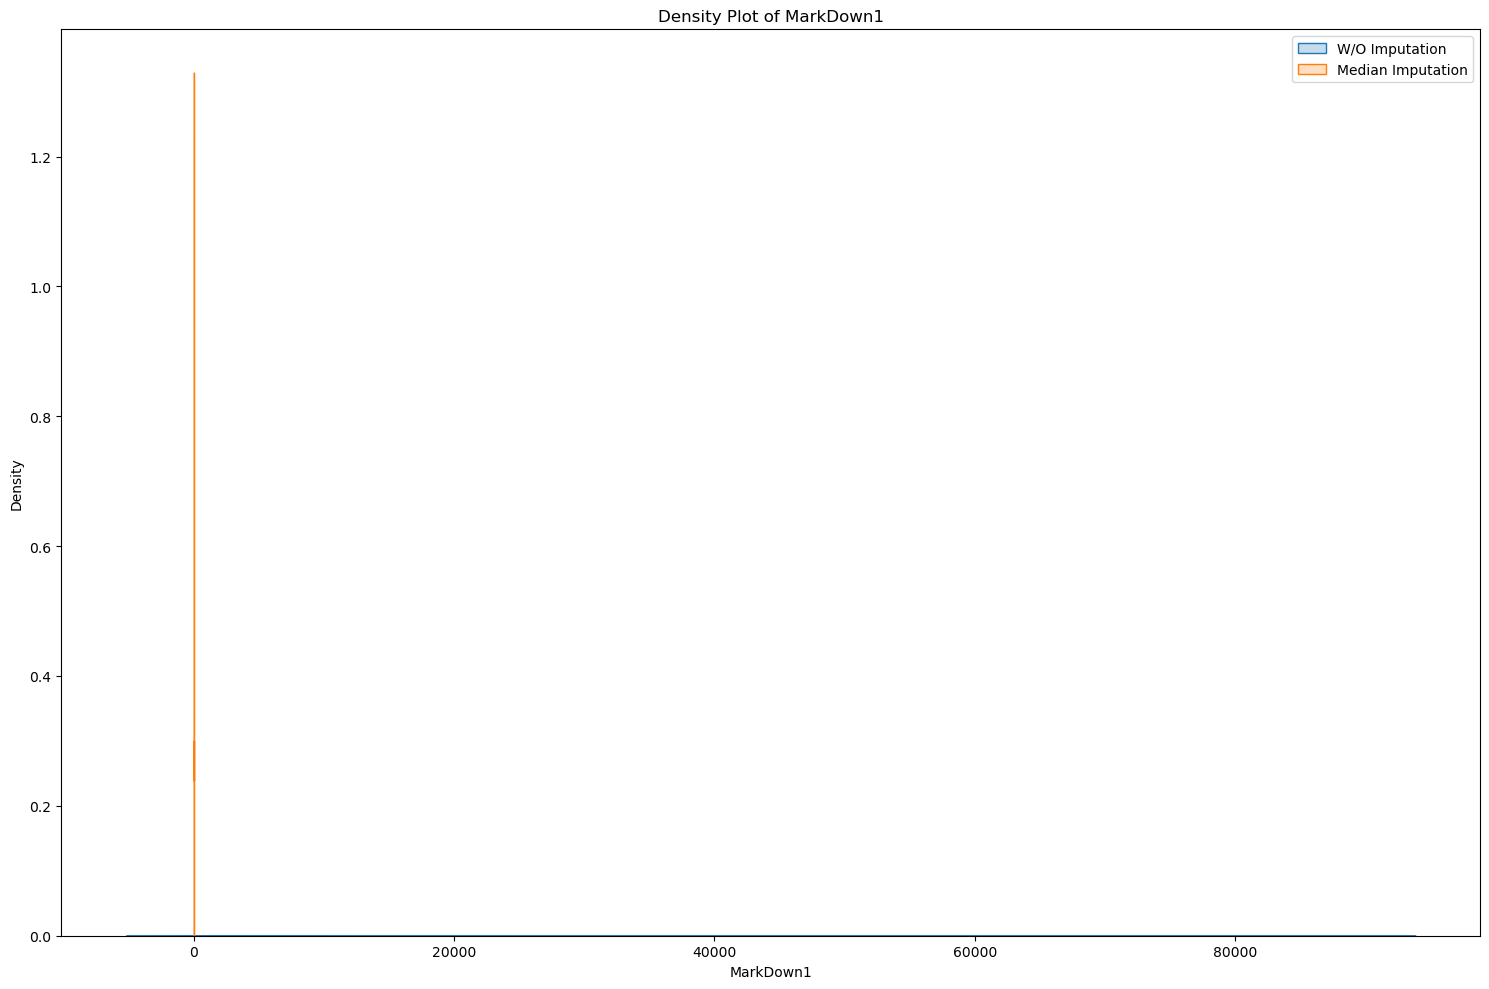

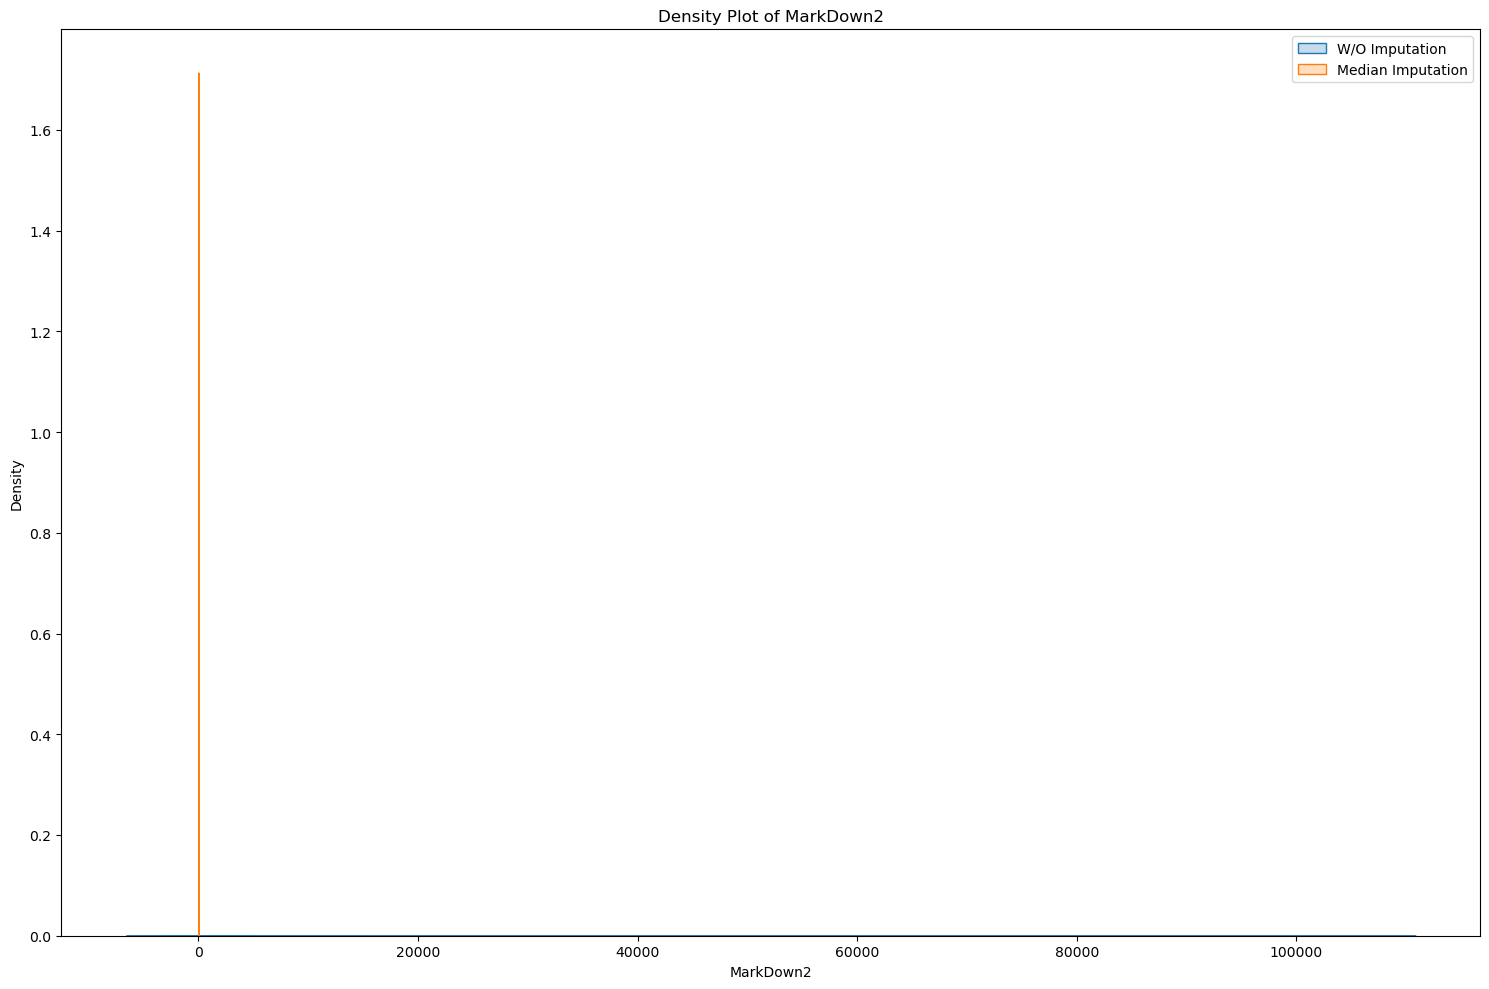

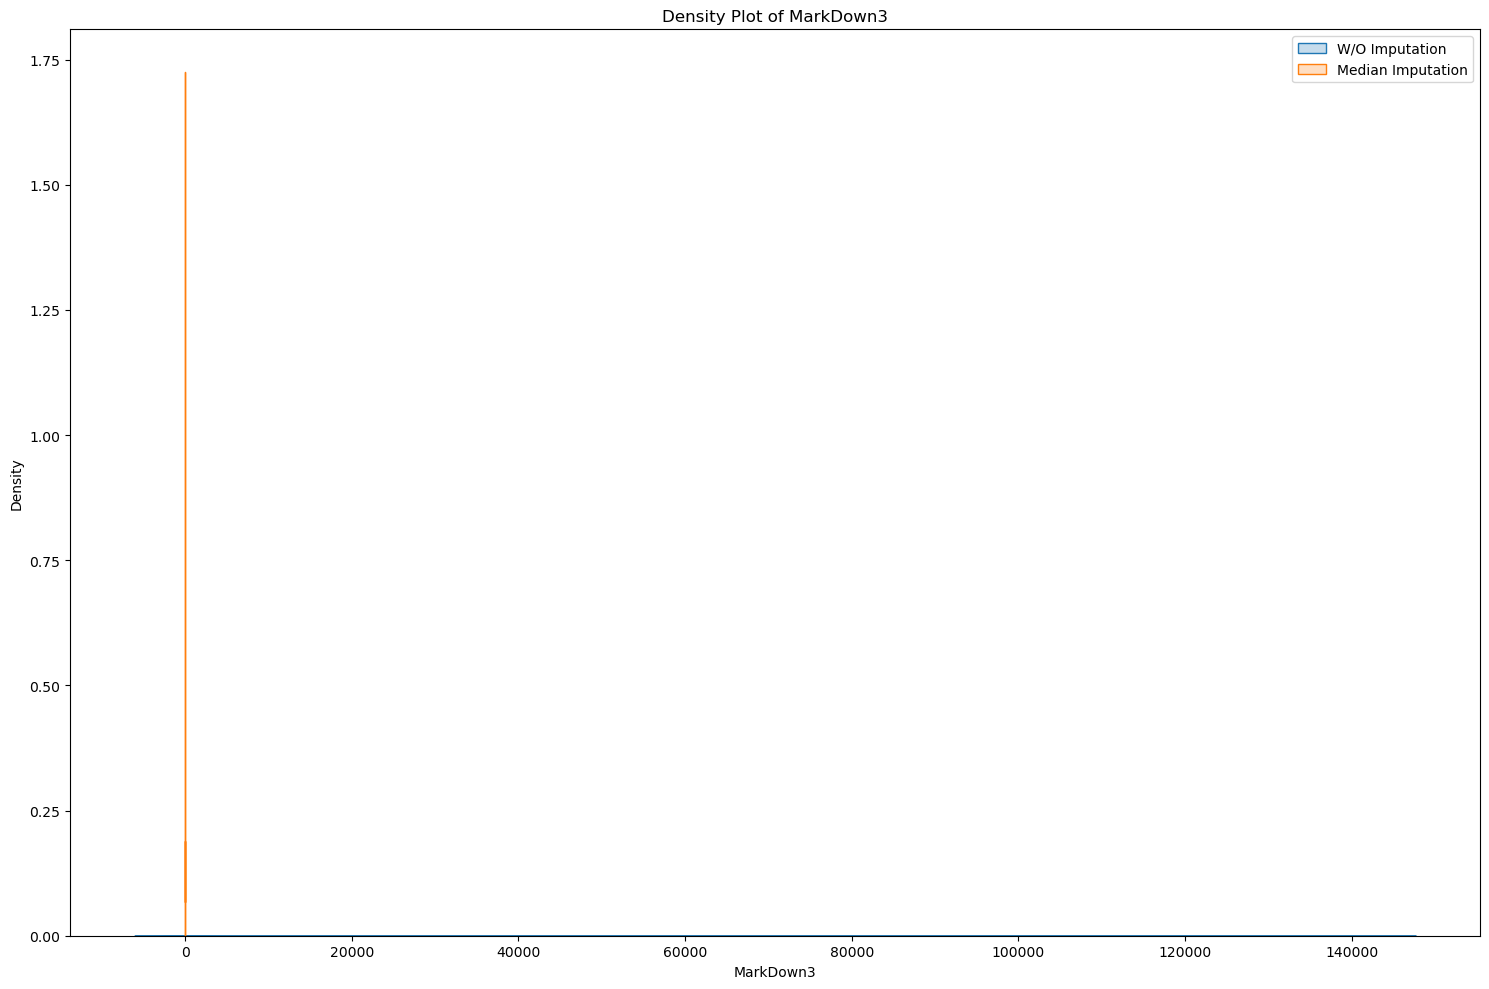

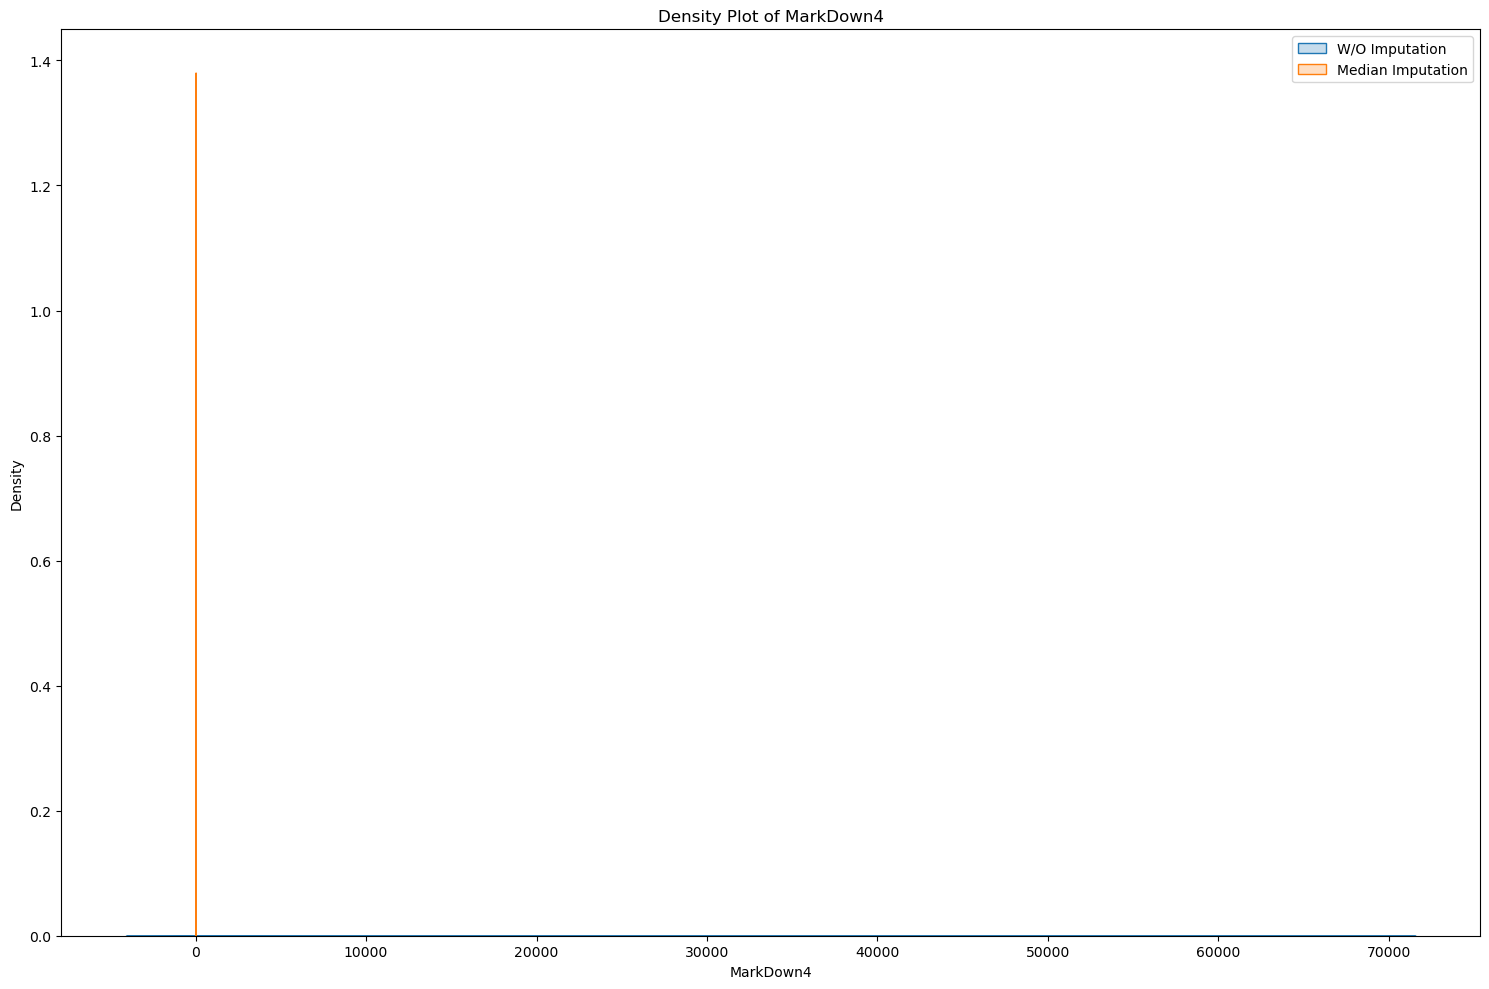

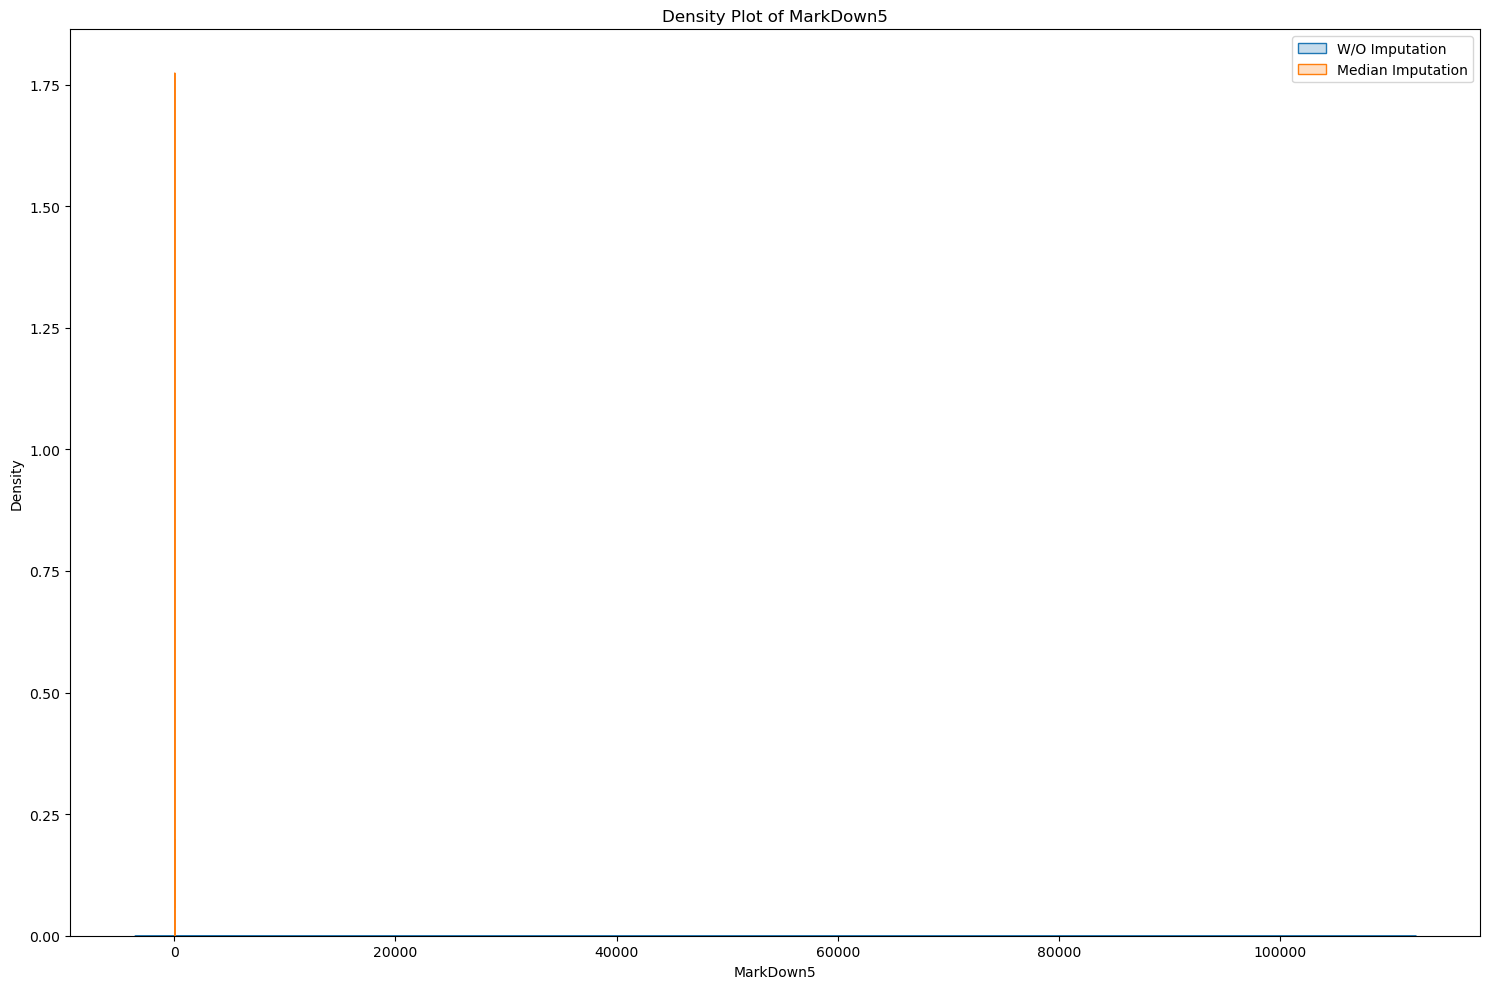

In [436]:
markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']




for i, col in enumerate(markdown_columns, start=1):
    plt.figure(figsize=(15, 10))
    # plt.subplot(6, 1, i)
    plt.hist(merged_data_W_imp[col].dropna(), bins=500, alpha=0.3, label='W/O Imputation')
    plt.hist(correlation_matrix_median_imp[col].dropna(), bins=500, alpha=0.3, label='Median Imputation')
    # plt.xlim(0, 40000)
    plt.title(f'Comparison of {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()



# plt.figure(figsize=(15, 10))

# for i, col in enumerate(markdown_columns, start=1):
#     # plt.subplot(6, 1, i)
#     plt.boxplot([merged_data_W_imp[col].dropna(), merged_data_no_empty[col].dropna()], labels=['W/O ', 'KNN'])
#     plt.title(f'Box Plot of {col}')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()



for i, col in enumerate(markdown_columns, start=1):
    plt.figure(figsize=(15, 10))
    # plt.subplot(6, 1, i)
    sns.kdeplot(merged_data_W_imp[col].dropna(), shade=True, label='W/O Imputation')
    sns.kdeplot(correlation_matrix_median_imp[col].dropna(), shade=True, label='Median Imputation')
    # plt.xlim(0, 40000)
    plt.title(f'Density Plot of {col}')
    plt.legend()
    plt.tight_layout()
    plt.show()


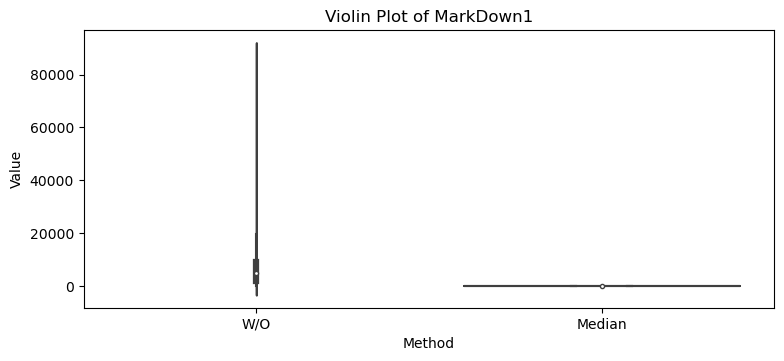

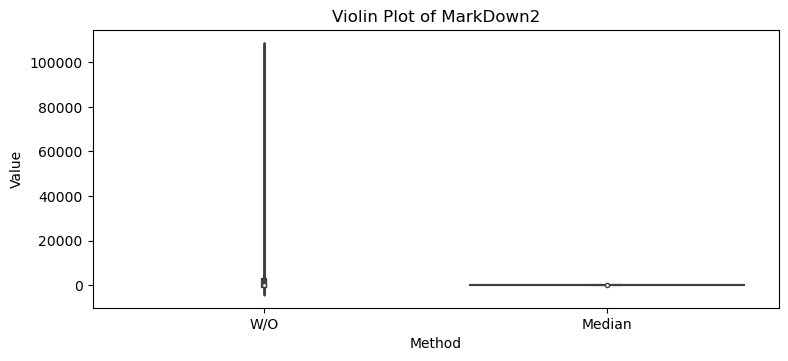

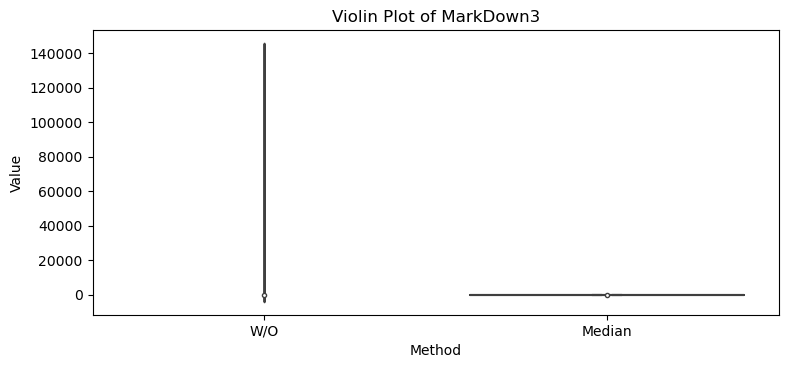

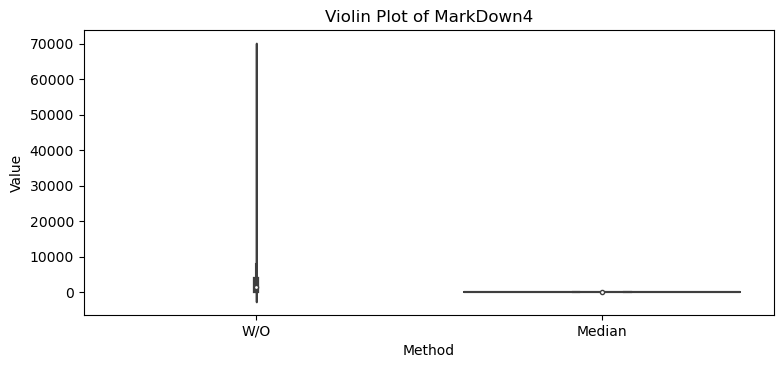

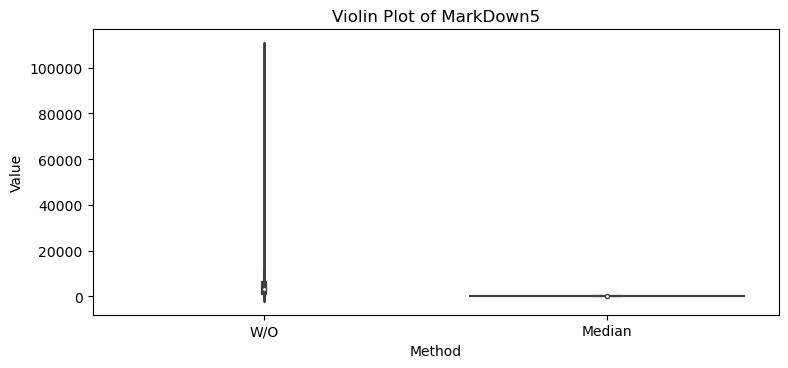

In [437]:
data_melted = pd.DataFrame()
for col in markdown_columns:
    temp_df = pd.DataFrame({
        'Value': merged_data_W_imp[col].dropna(),
        'Column': col,
        'Method': 'W/O'
    })
    data_melted = pd.concat([data_melted, temp_df], ignore_index=True)
    
    temp_df = pd.DataFrame({
        'Value': correlation_matrix_median_imp[col].dropna(),
        'Column': col,
        'Method': 'Median'
    })
    data_melted = pd.concat([data_melted, temp_df], ignore_index=True)

# Wizualizacja porównawcza rozkładów danych za pomocą violin plotów


for i, col in enumerate(markdown_columns, start=1):
    plt.figure(figsize=(15, 10))
    plt.subplot(3, 2, i)
    sns.violinplot(x='Method', y='Value', data=data_melted[data_melted['Column'] == col])
    plt.title(f'Violin Plot of {col}')
    plt.tight_layout()
    plt.show()


Media work much worse i decide to delete empty rows

In [438]:
merged_data_final=merged_data_W_imp.copy()
merged_data_final.dropna(inplace=True)
print('Before drop: ',merged_data_W_imp.shape)

print('After drop: ',merged_data_final.shape)


Before drop:  (6435, 13)
After drop:  (1395, 13)


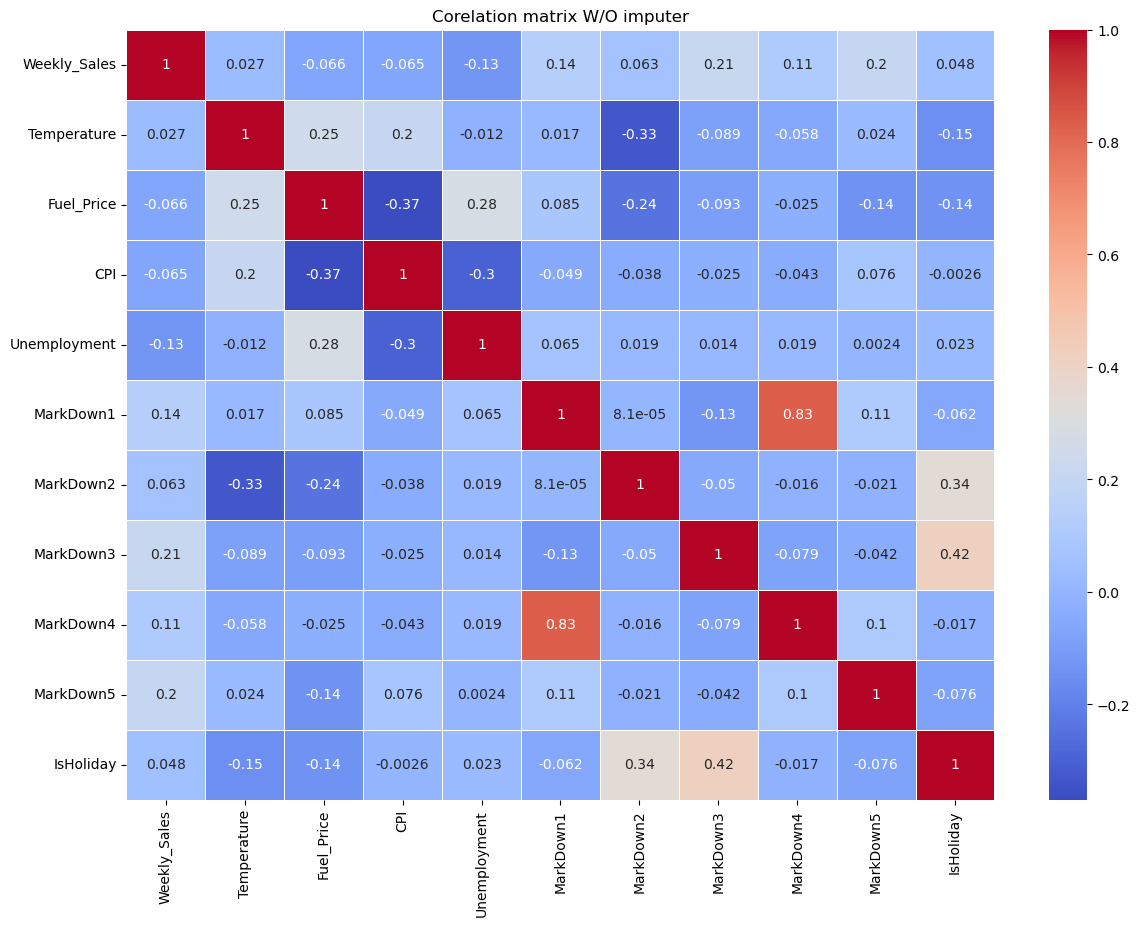

In [439]:
corr_columns = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment','MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5','IsHoliday']

# Obliczenie macierzy korelacji
correlation_matrix_final = merged_data_final[corr_columns].corr()

# Wizualizacja macierzy korelacji
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_final, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Corelation matrix W/O imputer')
plt.show()

after removal, significant differences in correlation appeared so I will try to make 2 clustering attempts, one before removing markdown without using markdown, the other after removing markdown

next step try to compare sales for all shops together and individually

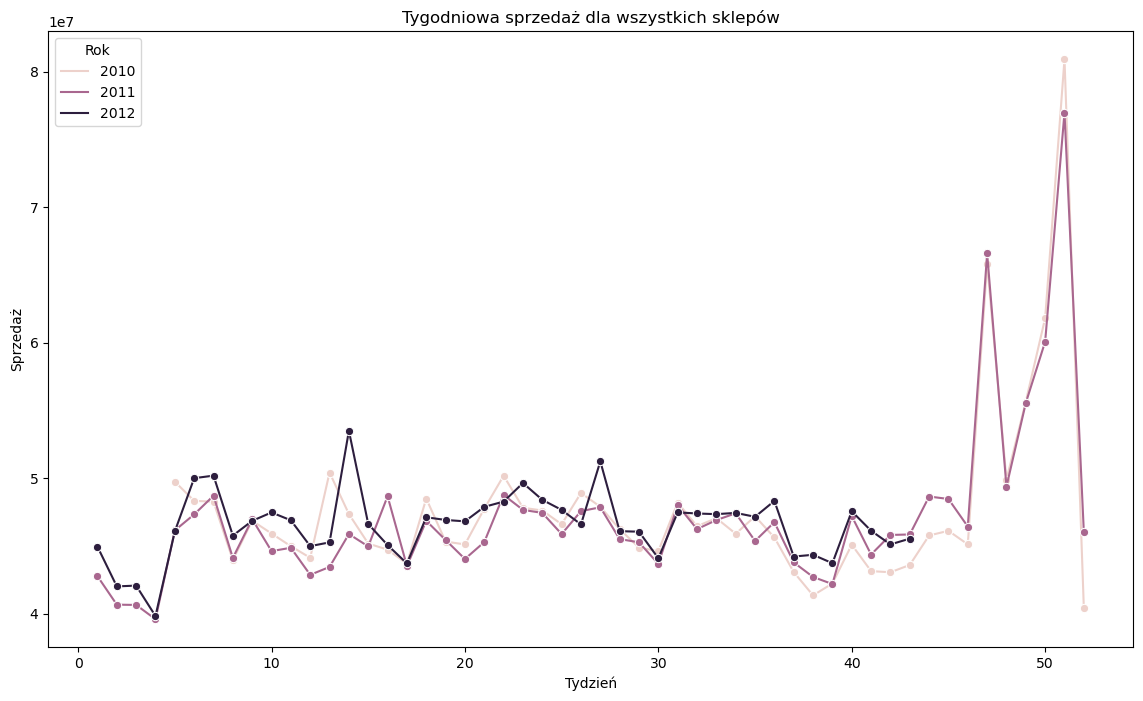

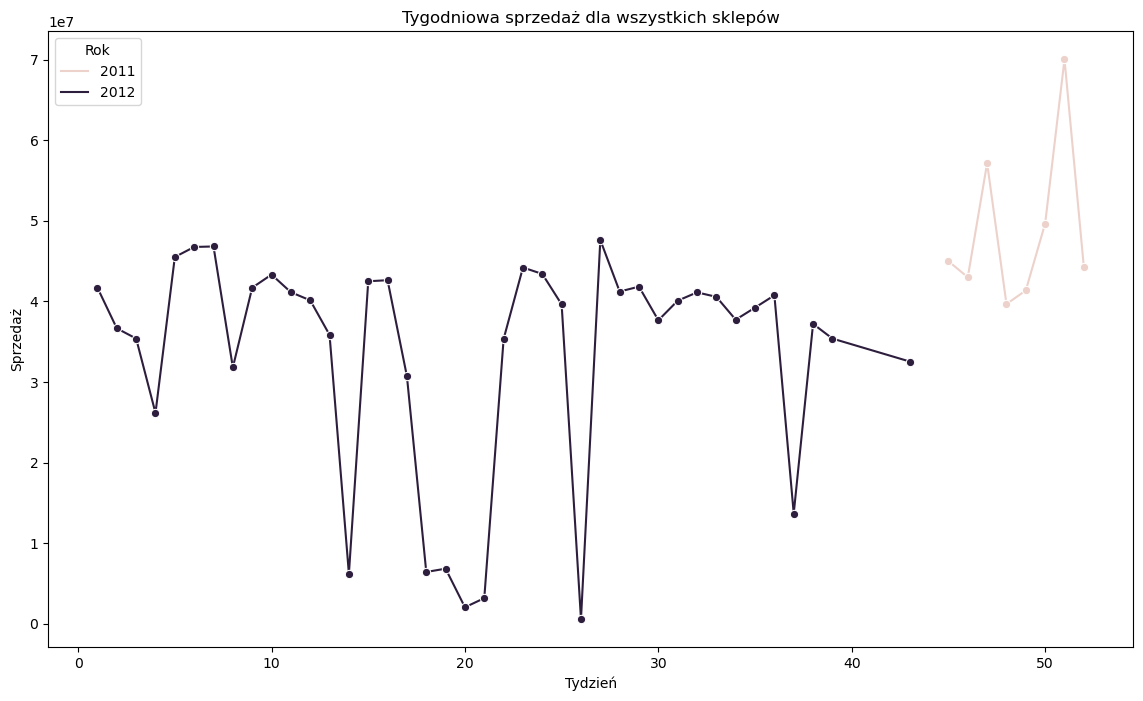

In [440]:
data=merged_data_W_imp
data['Date'] = pd.to_datetime(data['Date'])
data['Week'] = data['Date'].dt.isocalendar().week
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
weekly_sales = data.groupby(['Year', 'Week'])['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(14, 8))
sns.lineplot(data=weekly_sales, x='Week', y='Weekly_Sales', hue='Year', marker='o')
plt.title('Tygodniowa sprzedaż dla wszystkich sklepów')
plt.xlabel('Tydzień')
plt.ylabel('Sprzedaż')
plt.legend(title='Rok')
plt.show()



data=merged_data_final
data['Date'] = pd.to_datetime(data['Date'])
data['Week'] = data['Date'].dt.isocalendar().week
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
weekly_sales = data.groupby(['Year', 'Week'])['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(14, 8))
sns.lineplot(data=weekly_sales, x='Week', y='Weekly_Sales', hue='Year', marker='o')
plt.title('Tygodniowa sprzedaż dla wszystkich sklepów')
plt.xlabel('Tydzień')
plt.ylabel('Sprzedaż')
plt.legend(title='Rok')
plt.show()


In addition to sales, the chart also illustrates the problem of missing markdown data. They were added to the observations in the last year of their collection. he first chart shows trends, some anomalies of increased sales combined with the occurrence of holidays like Thanksgiving Day or Christmas and New Year in the US

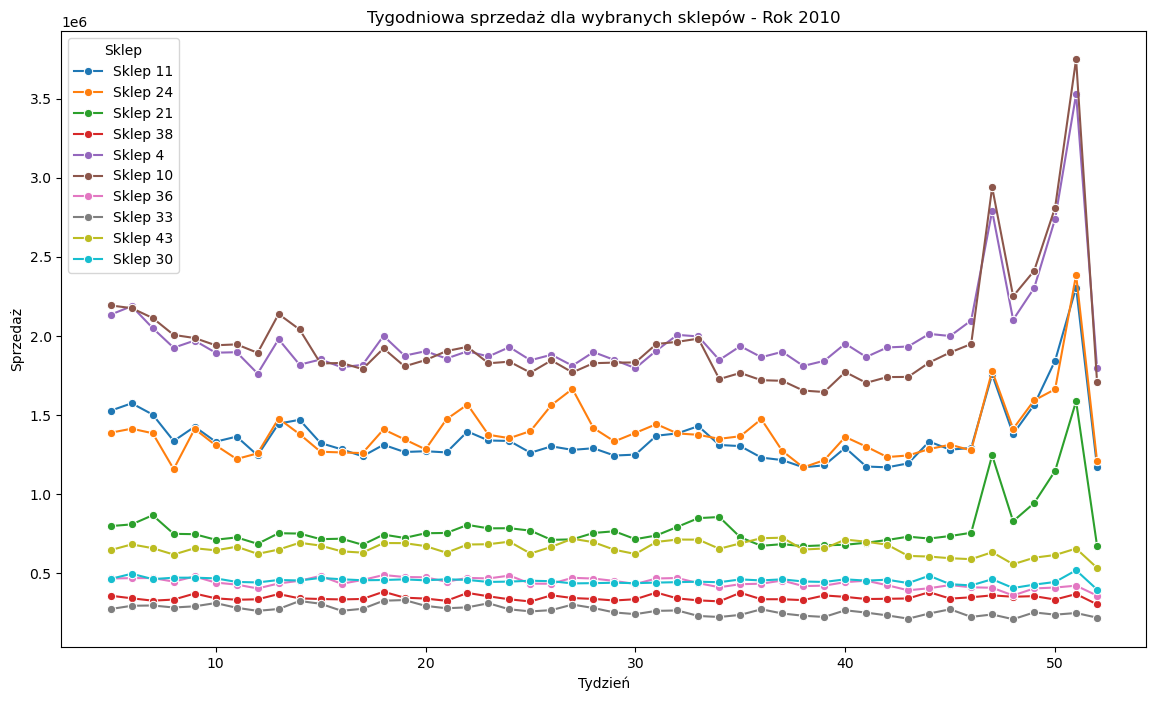

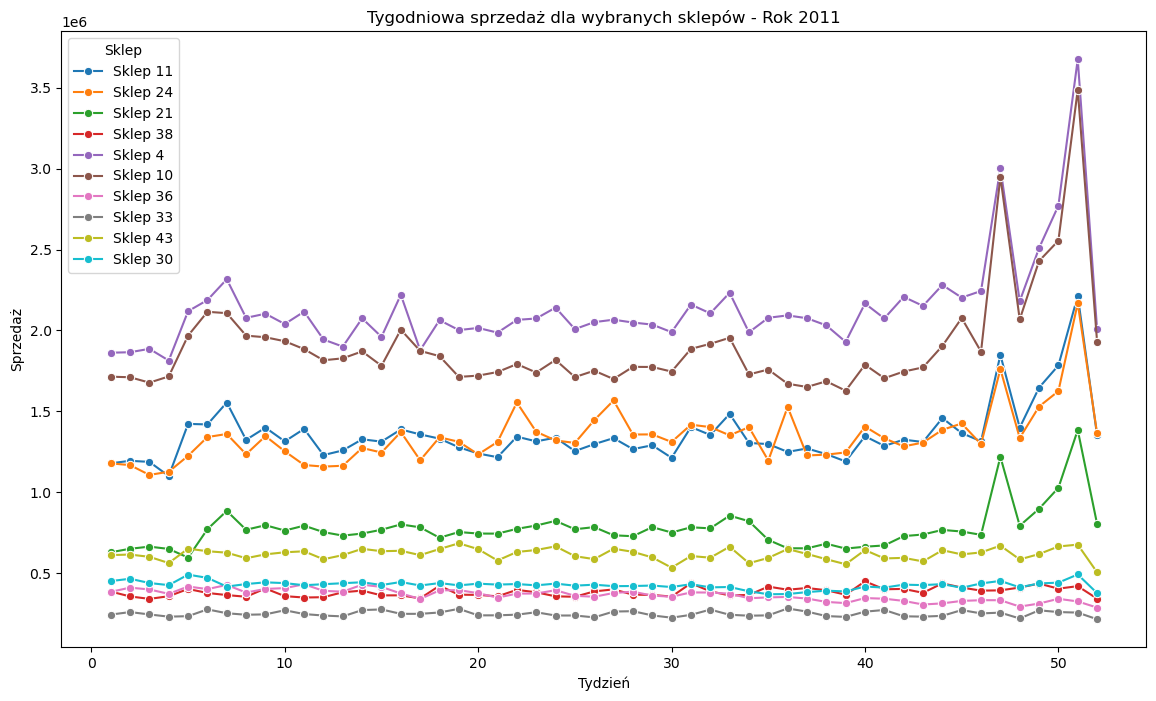

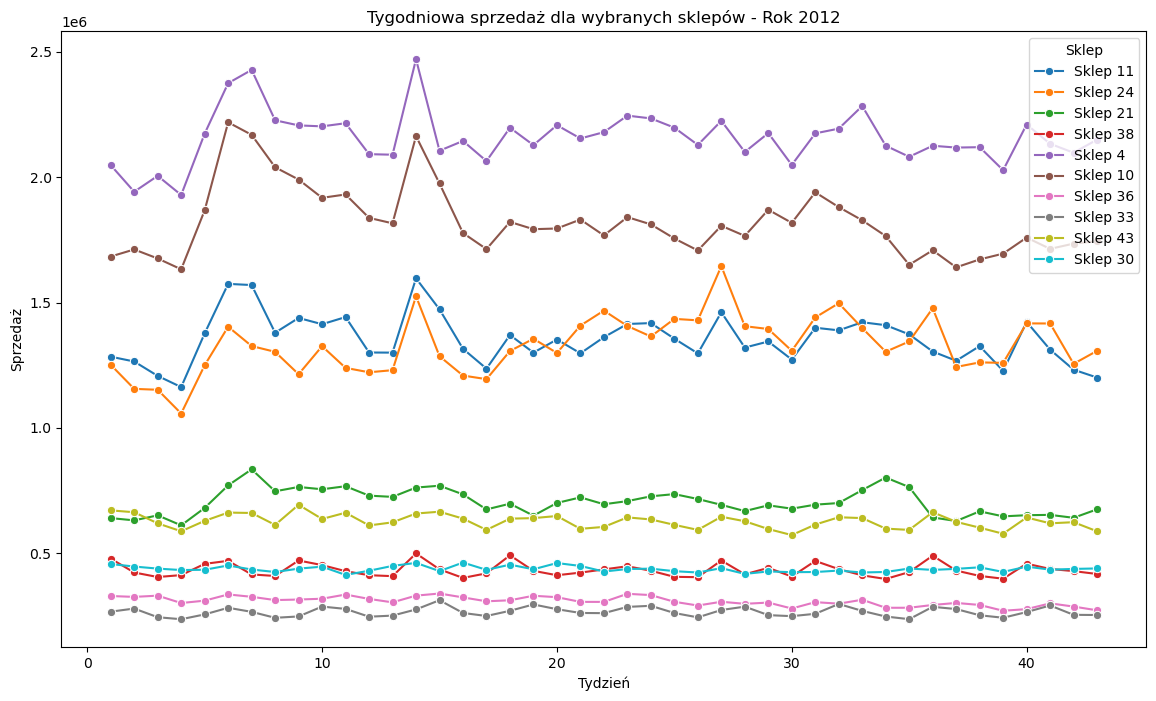

In [441]:
data=merged_data_W_imp
data['Date'] = pd.to_datetime(data['Date'])
data['Week'] = data['Date'].dt.isocalendar().week
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
weekly_sales = data.groupby(['Year', 'Week'])['Weekly_Sales'].sum().reset_index()

selected_stores = np.random.choice(data['Store'].unique(), size=10, replace=False)

# Utwórz osobne wykresy dla każdego roku
for year in data['Year'].unique():
    plt.figure(figsize=(14, 8))
    
    # Wykres liniowy dla wybranych sklepów w danym roku
    for store in selected_stores:
        subset = data[(data['Store'] == store) & (data['Year'] == year)].groupby(['Week'])['Weekly_Sales'].sum().reset_index()
        sns.lineplot(data=subset, x='Week', y='Weekly_Sales', marker='o', label=f'Sklep {store}')
    
    plt.title(f'Tygodniowa sprzedaż dla wybranych sklepów - Rok {year}')
    plt.xlabel('Tydzień')
    plt.ylabel('Sprzedaż')
    plt.legend(title='Sklep')
    plt.show()

you can see that the trends are similar for most stores, but there are significant differences in the earnings of individual stores

With missing data


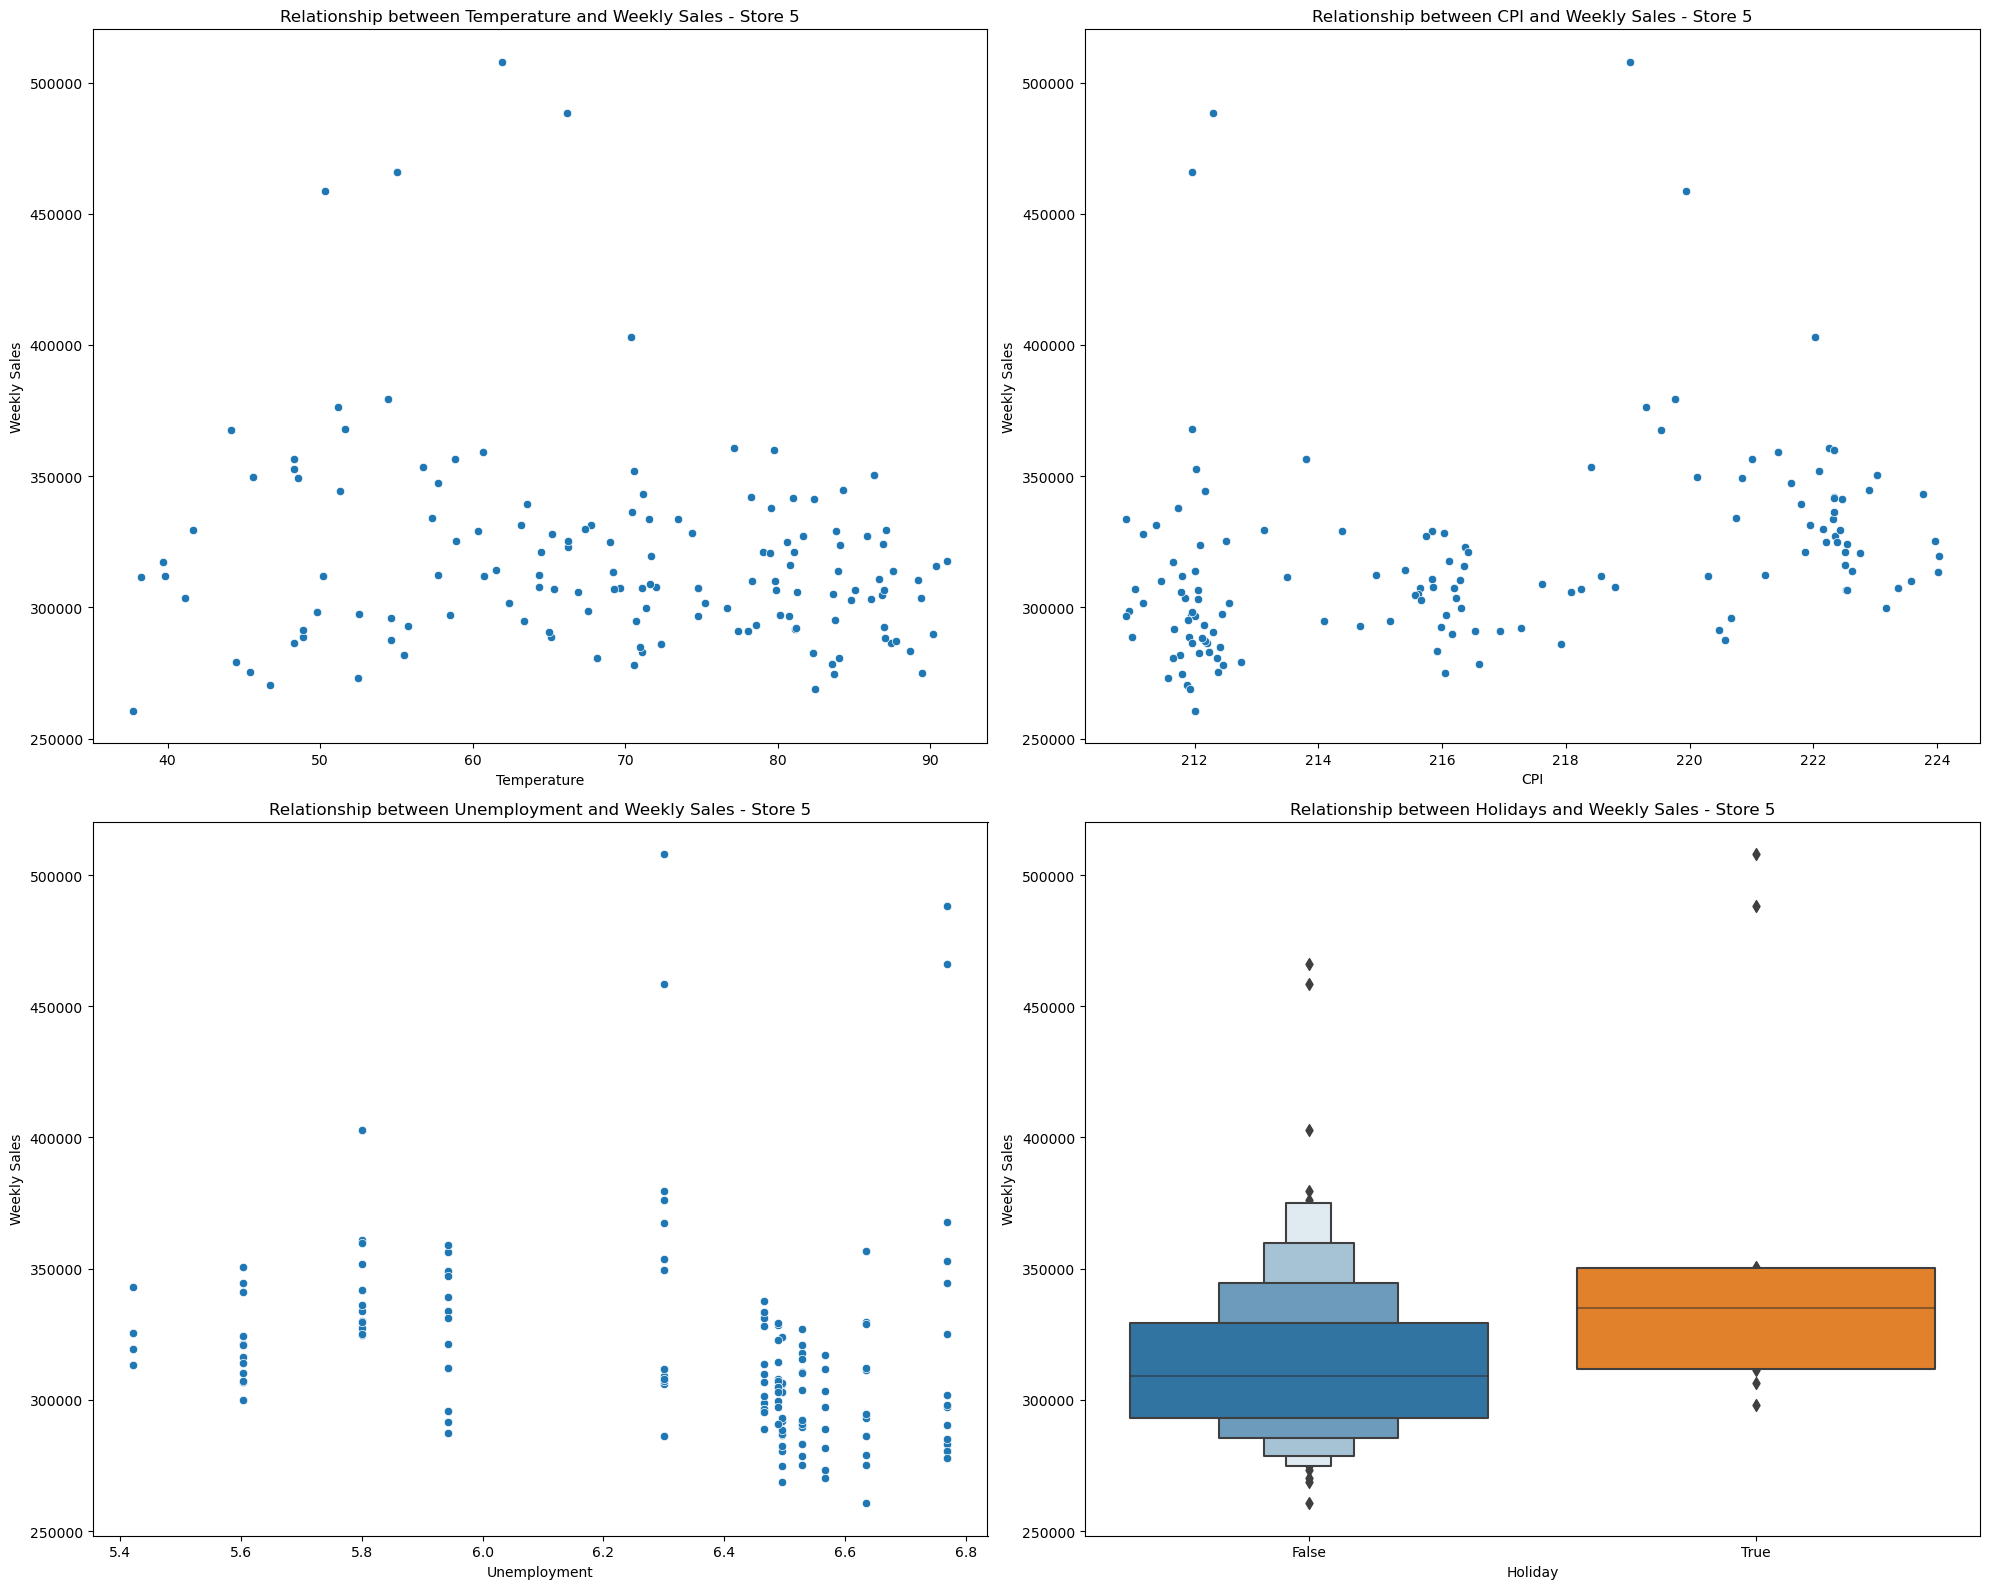

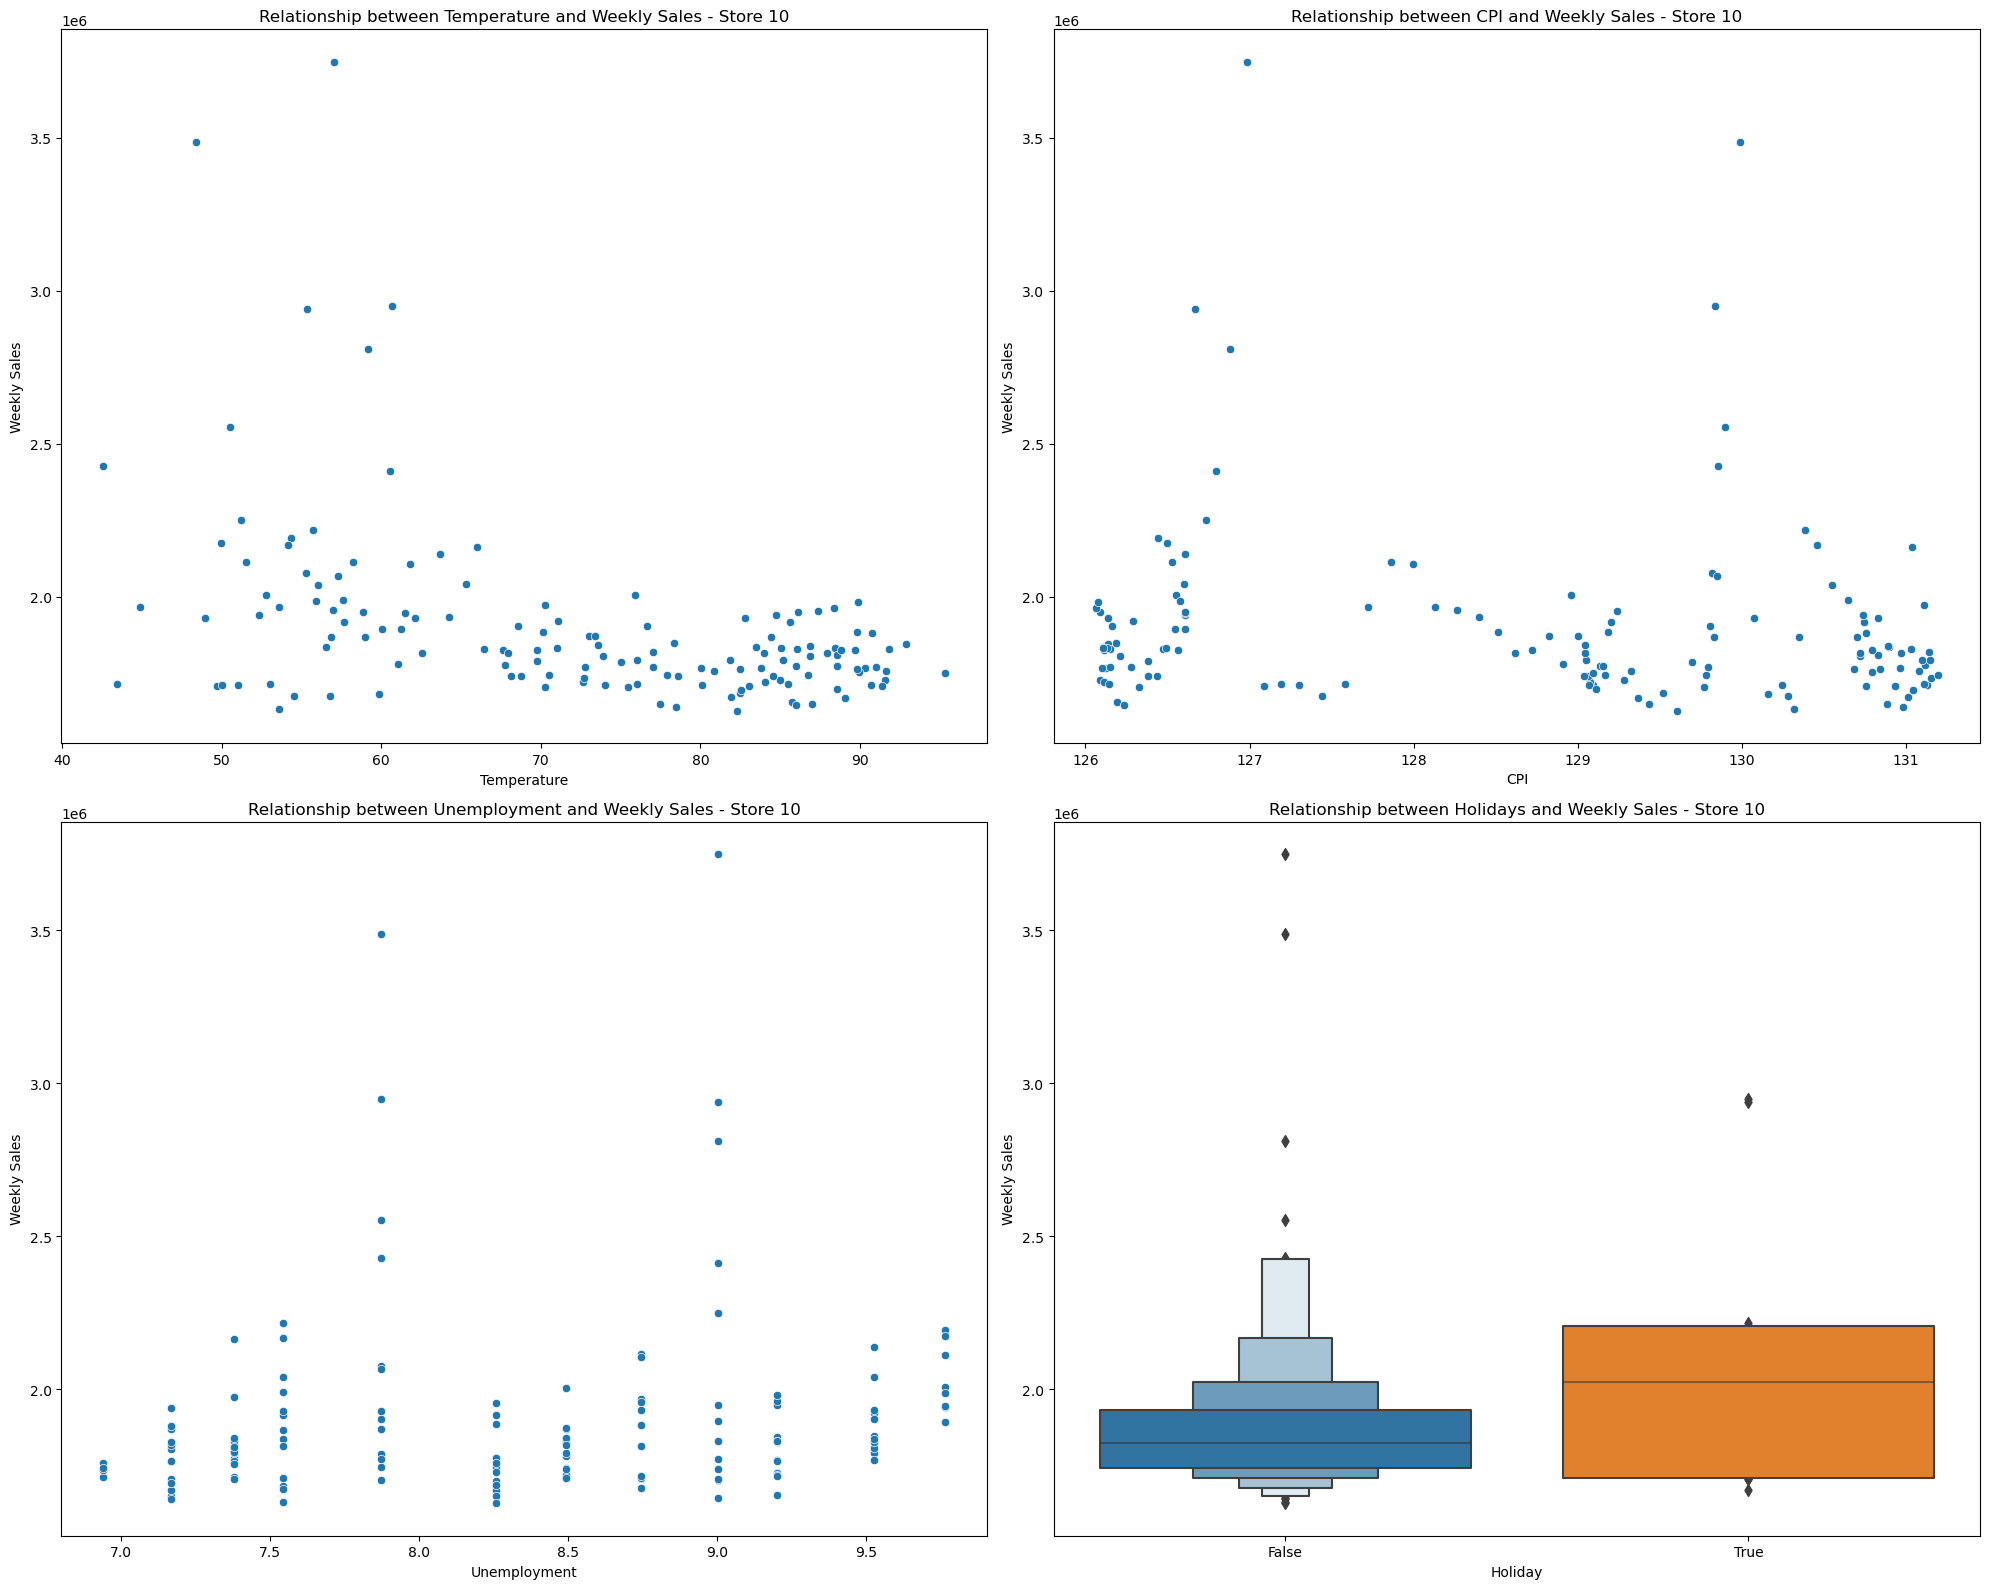

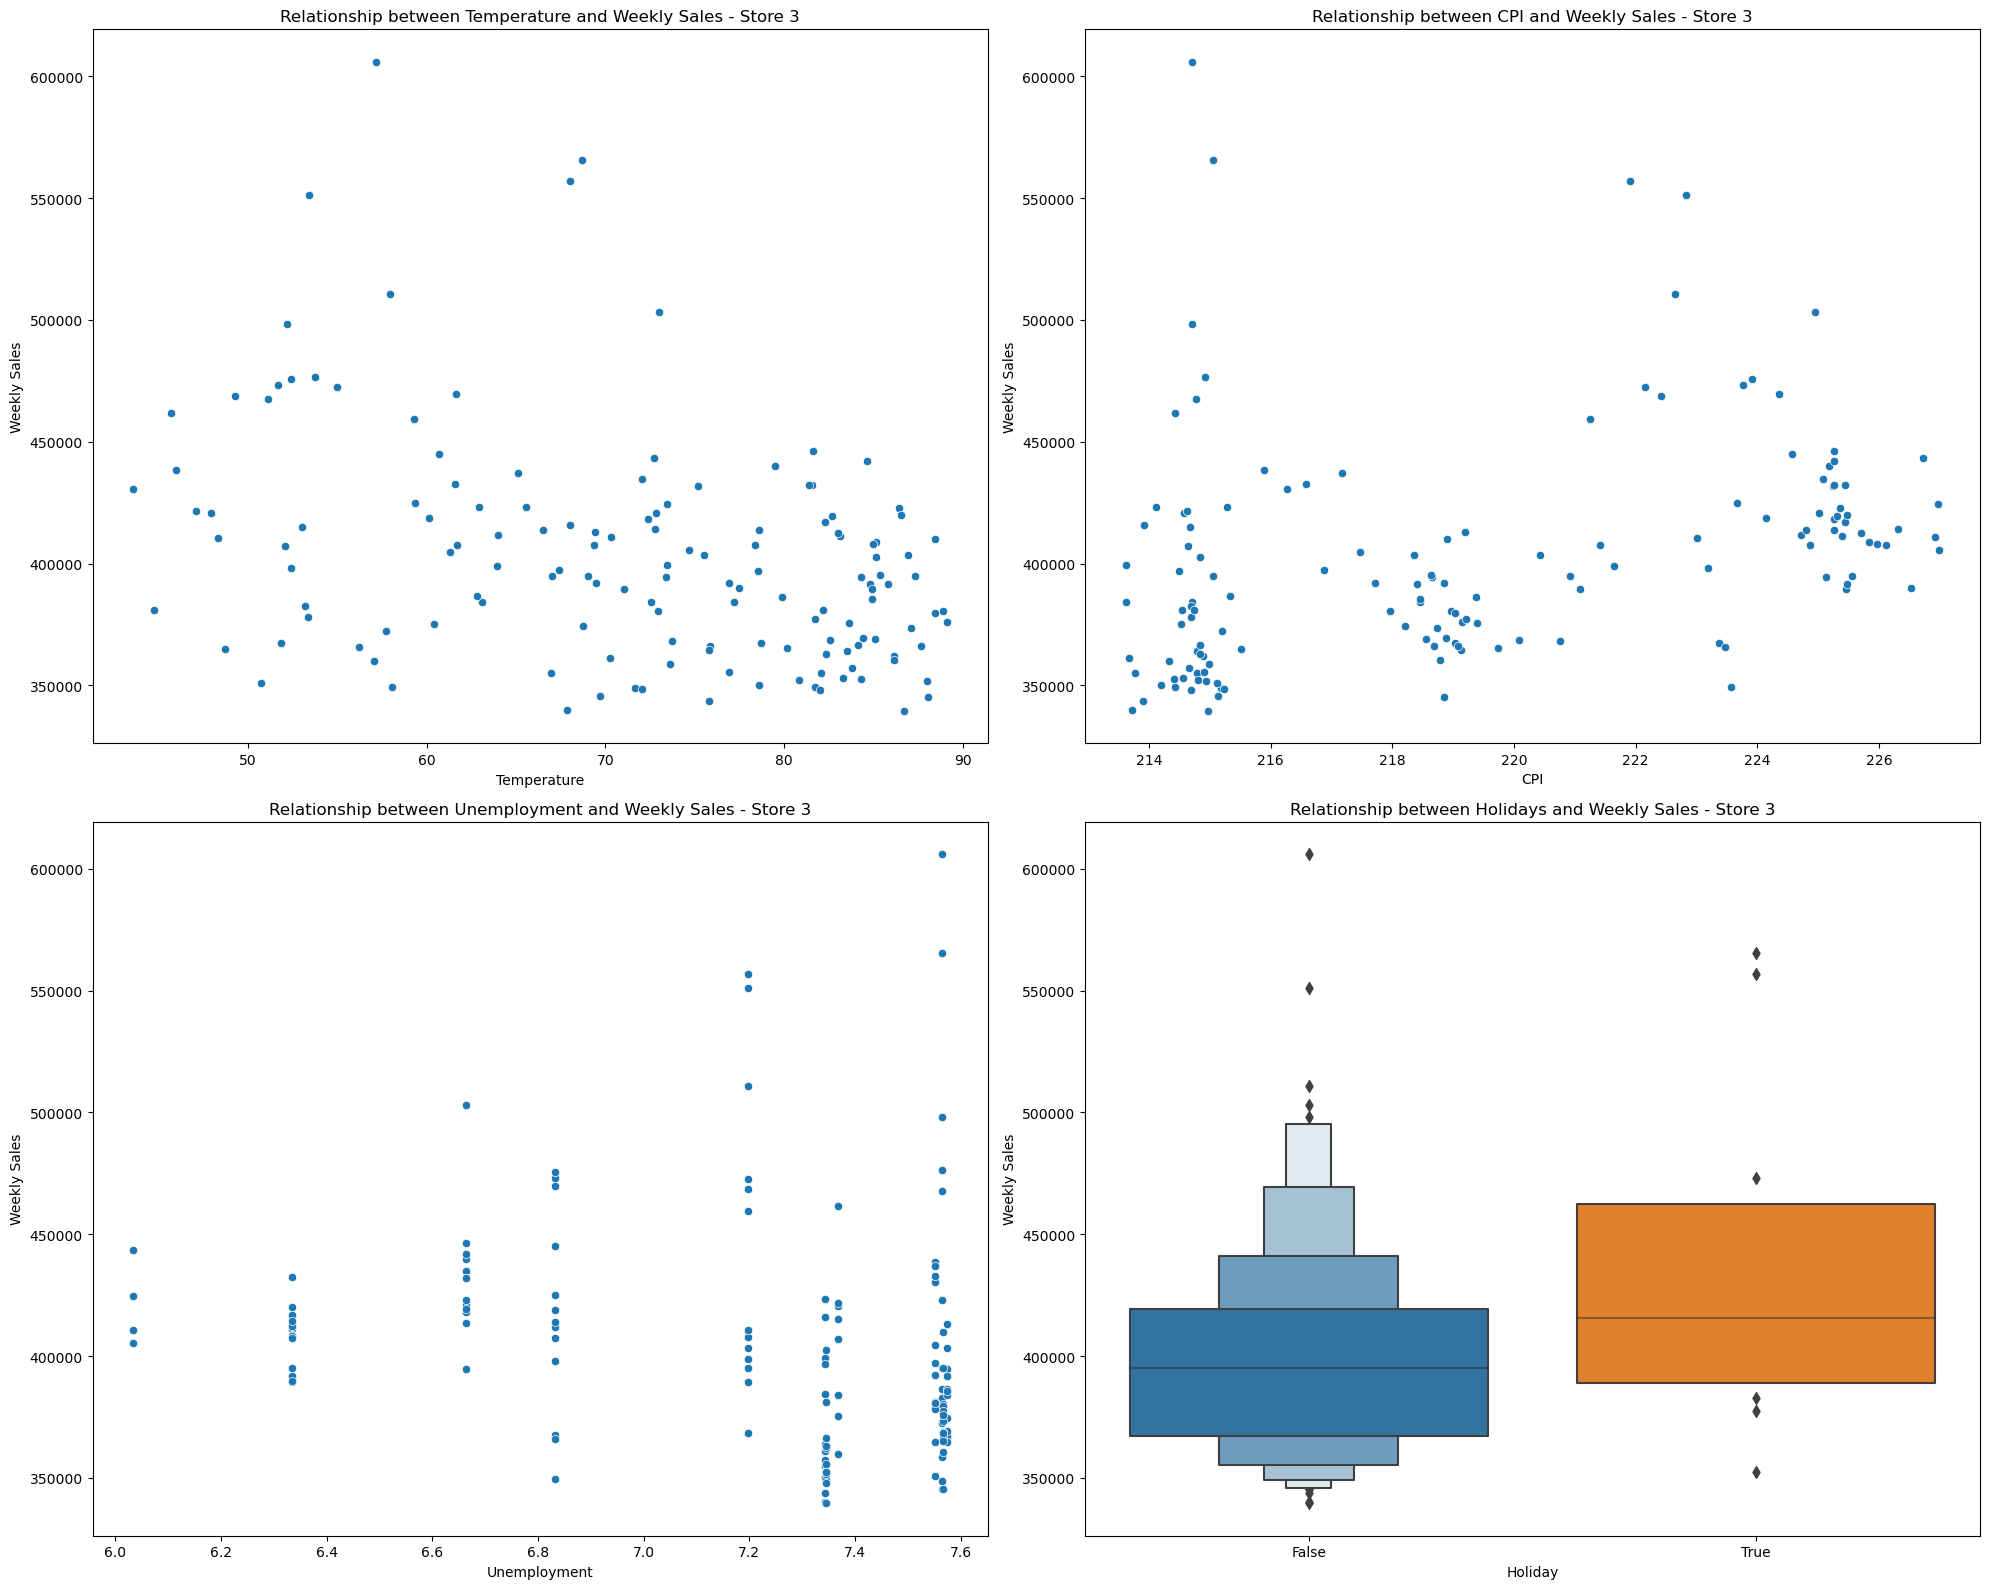

Without missing data


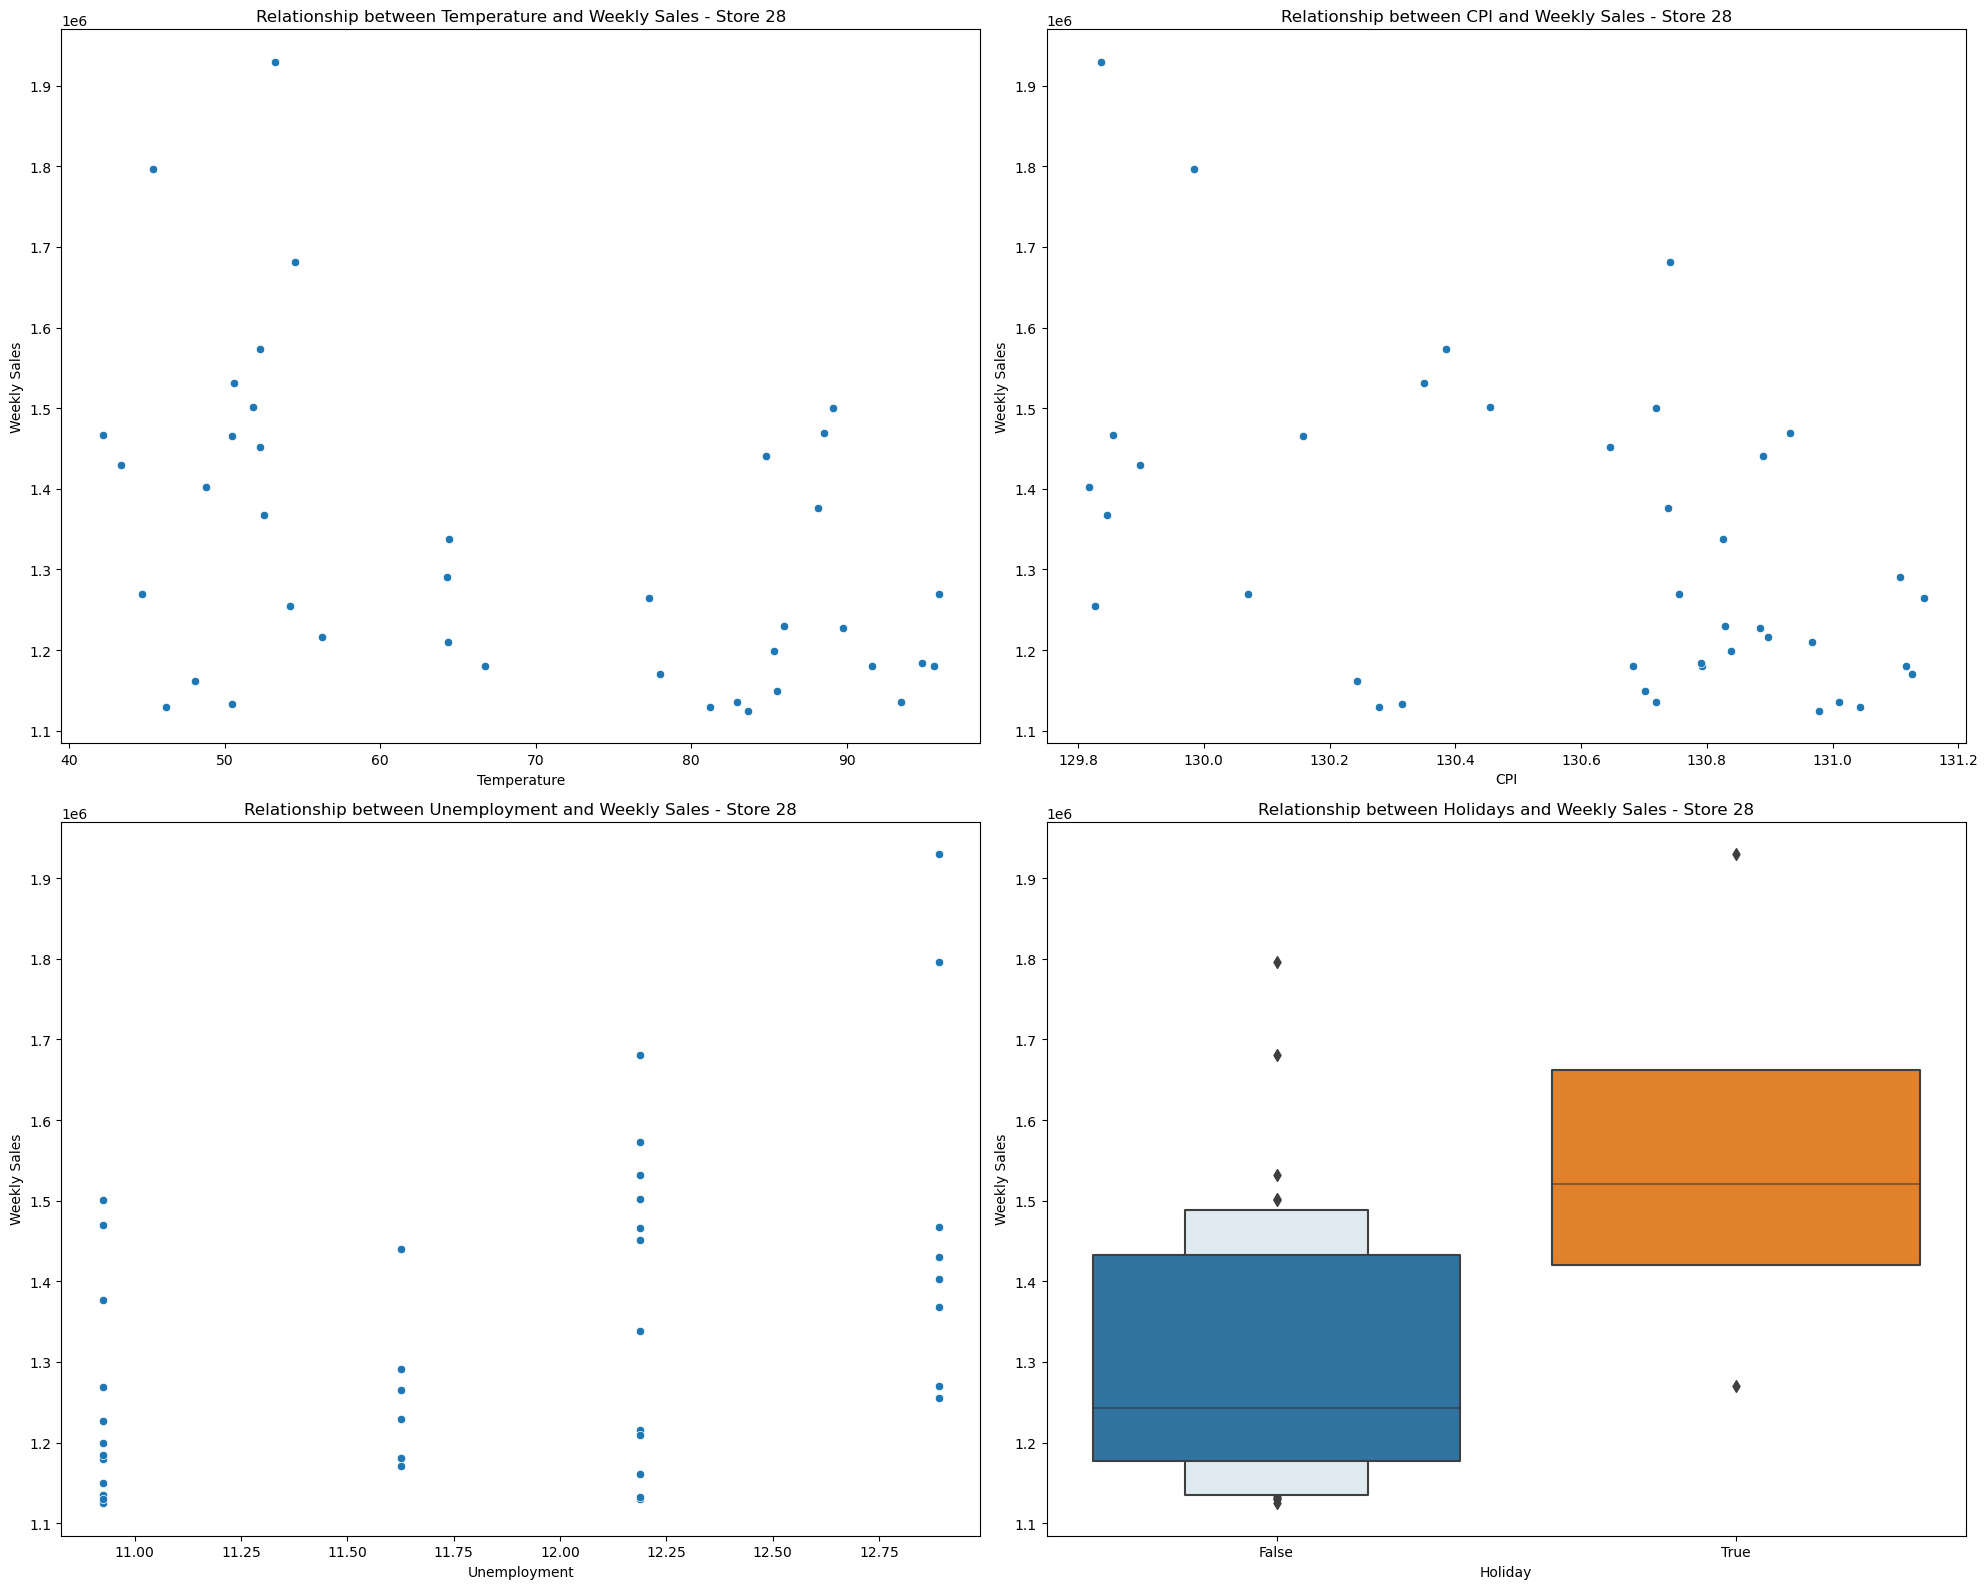

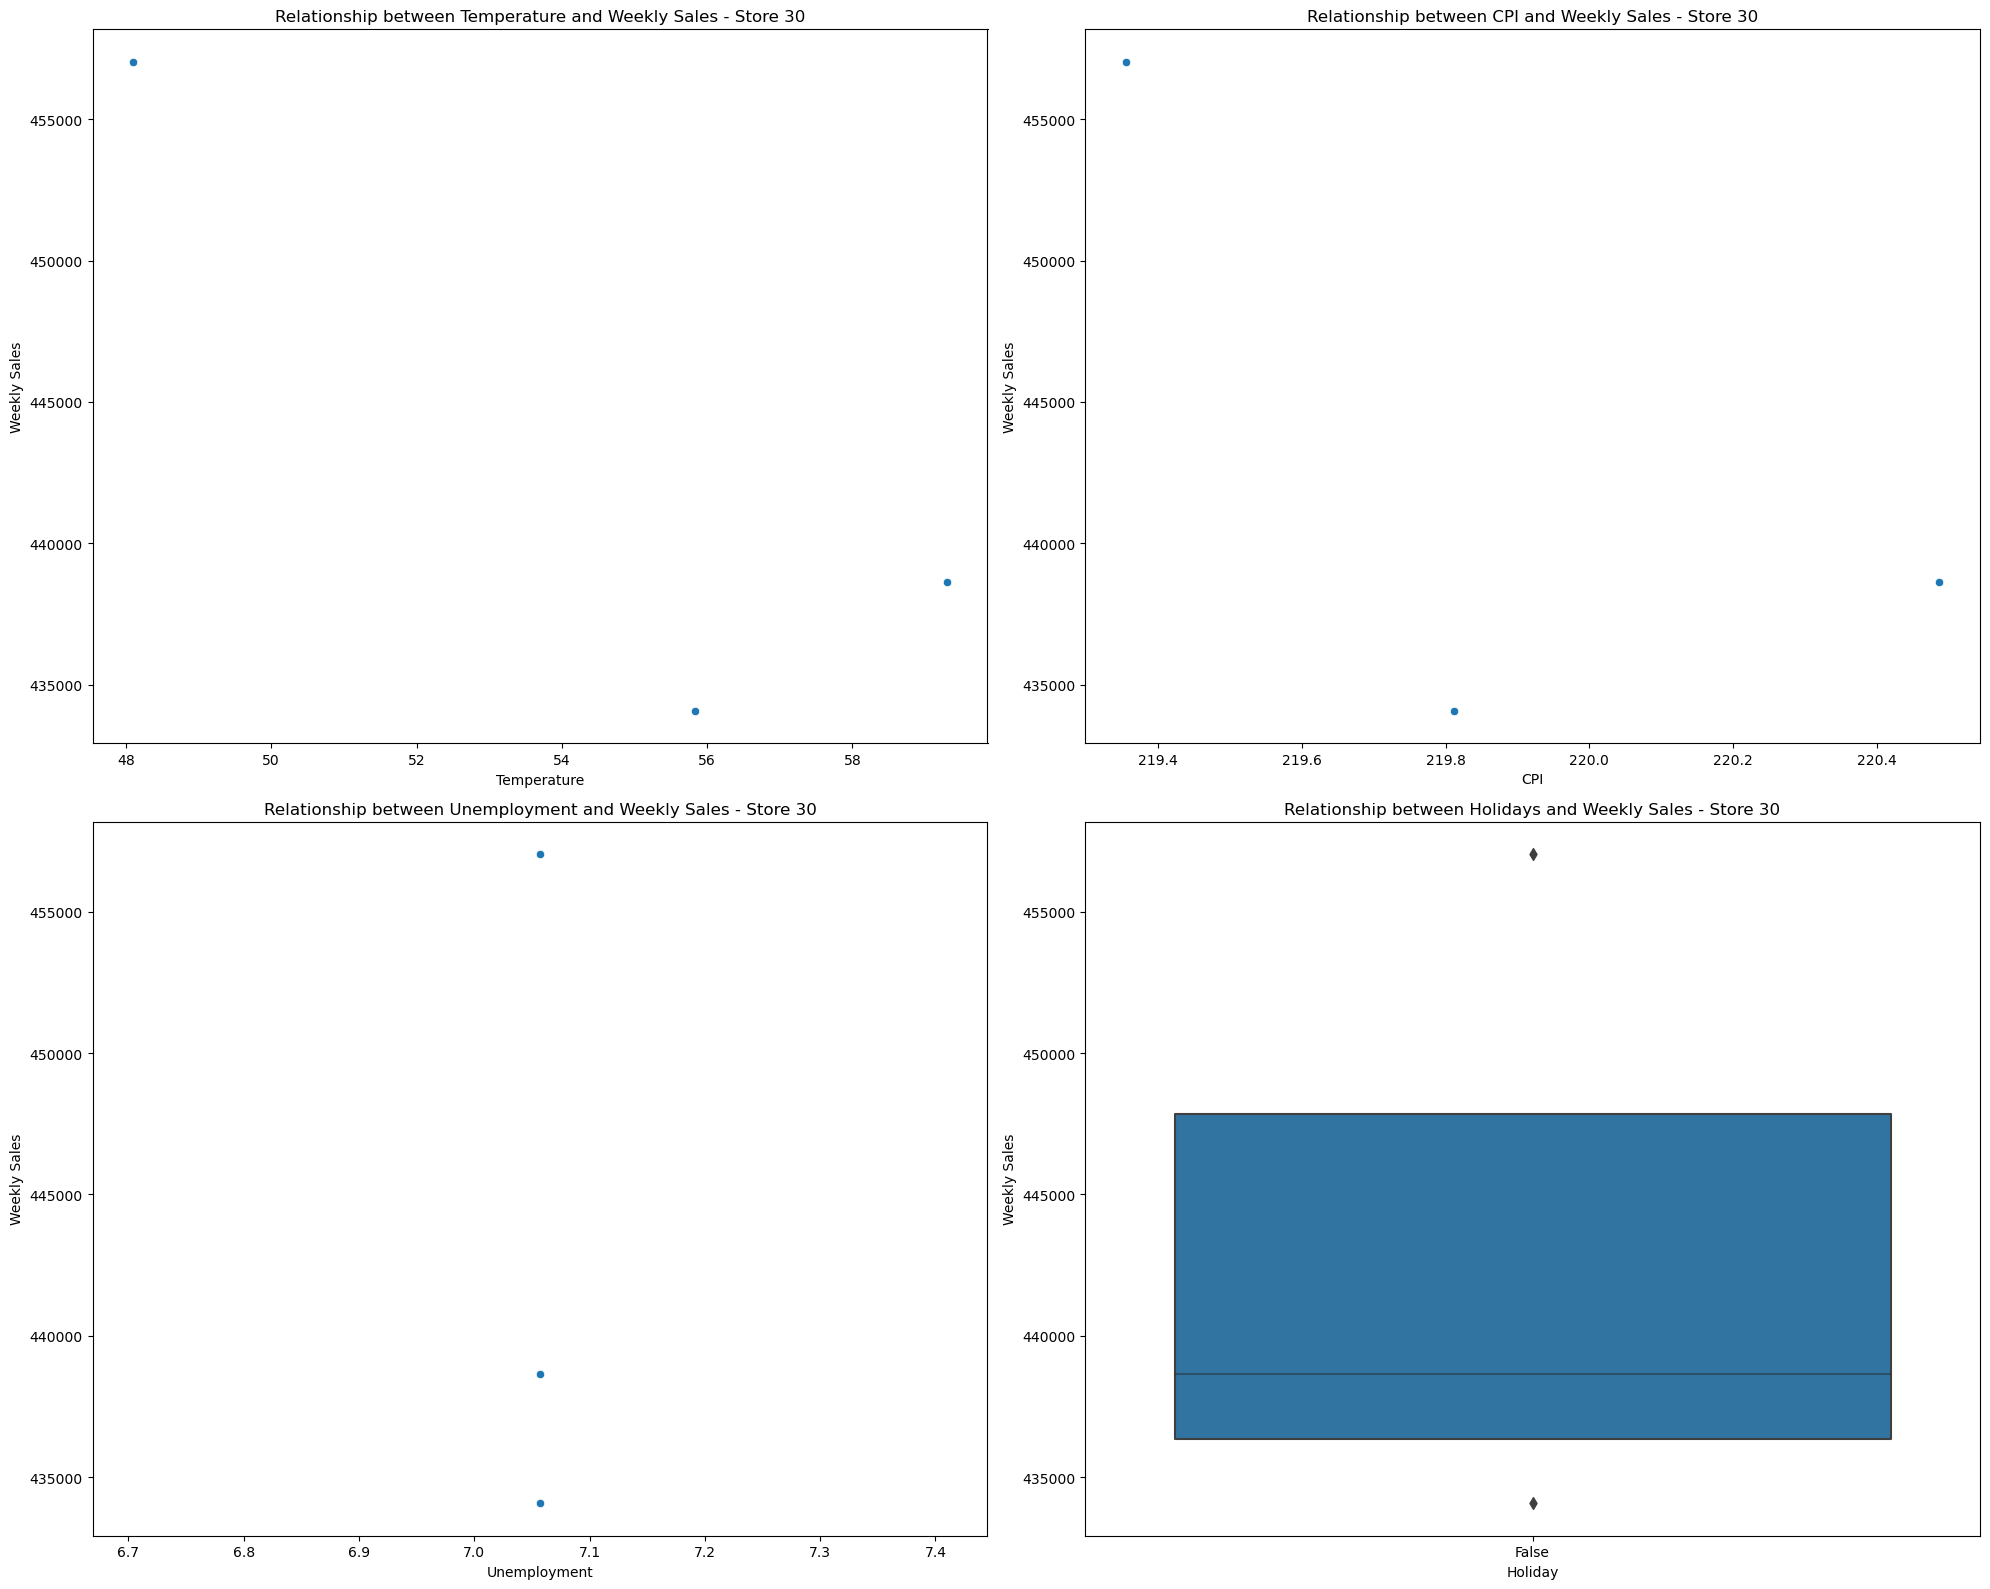

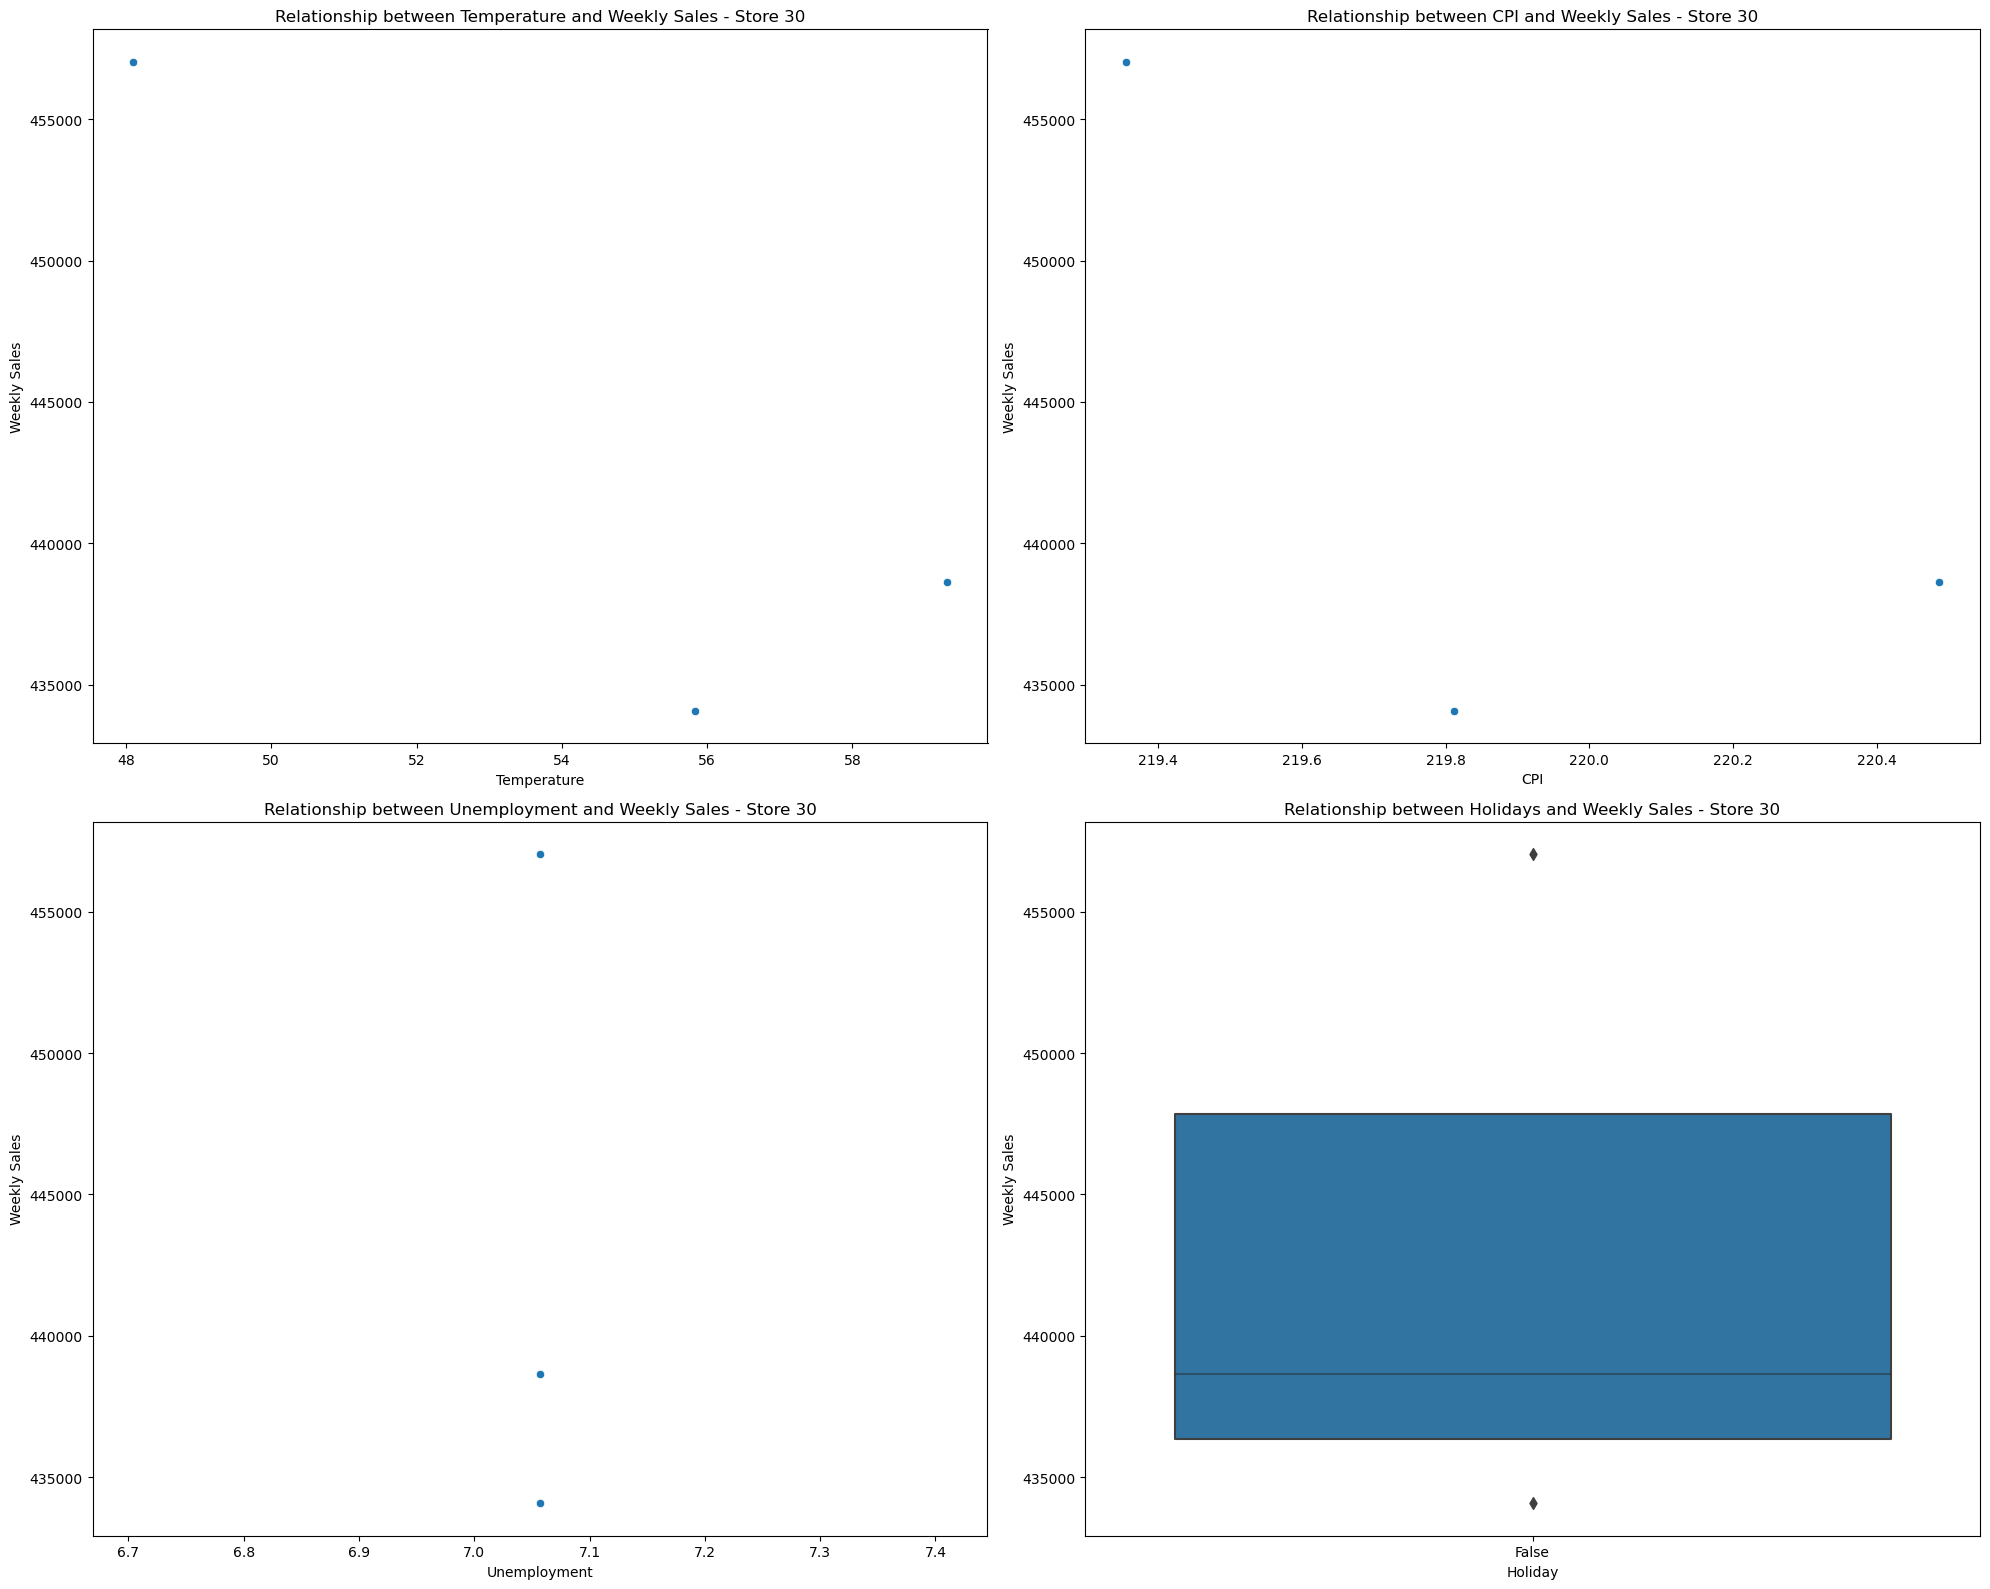

In [442]:
# Wybierz losowo jeden sklep z listy unikalnych sklepów
stories_to_compare=3 # how many stories want you compare


for c in range(2):
    if c==0:
        data=merged_data_W_imp
        print('With missing data')
    elif c==1:
        data=merged_data_final
        print('Without missing data')
    for i in range(stories_to_compare):

        selected_store = np.random.choice(data['Store'].unique())

        fig, axes = plt.subplots(2, 2, figsize=(20, 16))

        # Scatter plot for Temperature
        sns.scatterplot(data=data[data['Store'] == selected_store], x='Temperature', y='Weekly_Sales', ax=axes[0, 0])
        axes[0, 0].set_title(f'Relationship between Temperature and Weekly Sales - Store {selected_store}')
        axes[0, 0].set_xlabel('Temperature')
        axes[0, 0].set_ylabel('Weekly Sales')

        # Scatter plot for CPI
        sns.scatterplot(data=data[data['Store'] == selected_store], x='CPI', y='Weekly_Sales', ax=axes[0, 1])
        axes[0, 1].set_title(f'Relationship between CPI and Weekly Sales - Store {selected_store}')
        axes[0, 1].set_xlabel('CPI')
        axes[0, 1].set_ylabel('Weekly Sales')

        # Scatter plot for Unemployment
        sns.scatterplot(data=data[data['Store'] == selected_store], x='Unemployment', y='Weekly_Sales', ax=axes[1, 0])
        axes[1, 0].set_title(f'Relationship between Unemployment and Weekly Sales - Store {selected_store}')
        axes[1, 0].set_xlabel('Unemployment')
        axes[1, 0].set_ylabel('Weekly Sales')

        # Boxen plot for IsHoliday
        sns.boxenplot(data=data[data['Store'] == selected_store], x='IsHoliday', y='Weekly_Sales', ax=axes[1, 1])
        axes[1, 1].set_title(f'Relationship between Holidays and Weekly Sales - Store {selected_store}')
        axes[1, 1].set_xlabel('Holiday')
        axes[1, 1].set_ylabel('Weekly Sales')

        plt.tight_layout()
        plt.show()

In [443]:
data=merged_data_W_imp.copy()
# data=merged_data_final.copy()
# data=merged_data_no_empty.copy()


holiday_percentage = data.groupby('Store')['IsHoliday'].mean().reset_index()
holiday_percentage.rename(columns={'IsHoliday': 'Holiday_Percentage'}, inplace=True)

store_data = data.groupby('Store').agg({
    'Weekly_Sales': 'mean',
    'Weekly_Sales': 'std',
    'Temperature': 'median',
    # 'Fuel_Price': 'median',
    'CPI': 'mean',
    # 'CPI': 'median',
    'Unemployment': 'mean',
    # 'MarkDown1': 'std',
    # 'MarkDown2': 'mean',
    # 'MarkDown3': 'mean',
    # 'MarkDown4': 'mean',
    # 'MarkDown5': 'mean',
    
}).reset_index()

# store_data = store_data.merge(holiday_percentage, on='Store', how='left')
# standardization 
scaler = StandardScaler()
store_data_scaled = scaler.fit_transform(store_data.drop('Store', axis=1))


store_data_scaled = pd.DataFrame(store_data_scaled, columns=store_data.columns[1:])

In [444]:
kmeans = KMeans(n_clusters=3, random_state=42,)
store_data['Cluster'] = kmeans.fit_predict(store_data_scaled)

# Wyświetlenie przypisania sklepów do klastrów
# print(store_data[['Store', 'Cluster']])



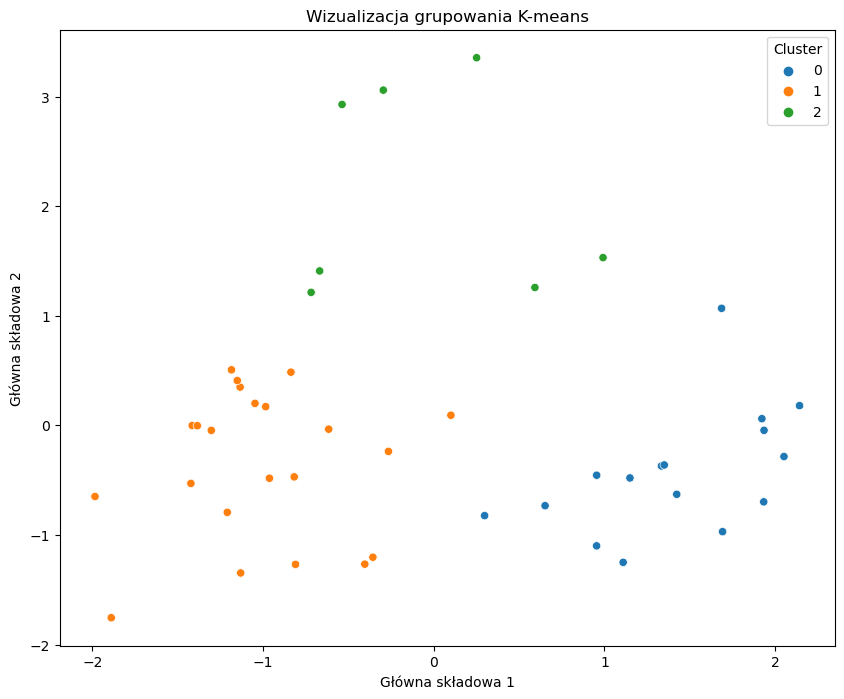

In [445]:


pca = PCA(n_components=2)
components = pca.fit_transform(store_data_scaled)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=store_data['Cluster'], palette='tab10')
plt.title('Wizualizacja grupowania K-means')
plt.xlabel('Główna składowa 1')
plt.ylabel('Główna składowa 2')
plt.legend(title='Cluster')
plt.show()

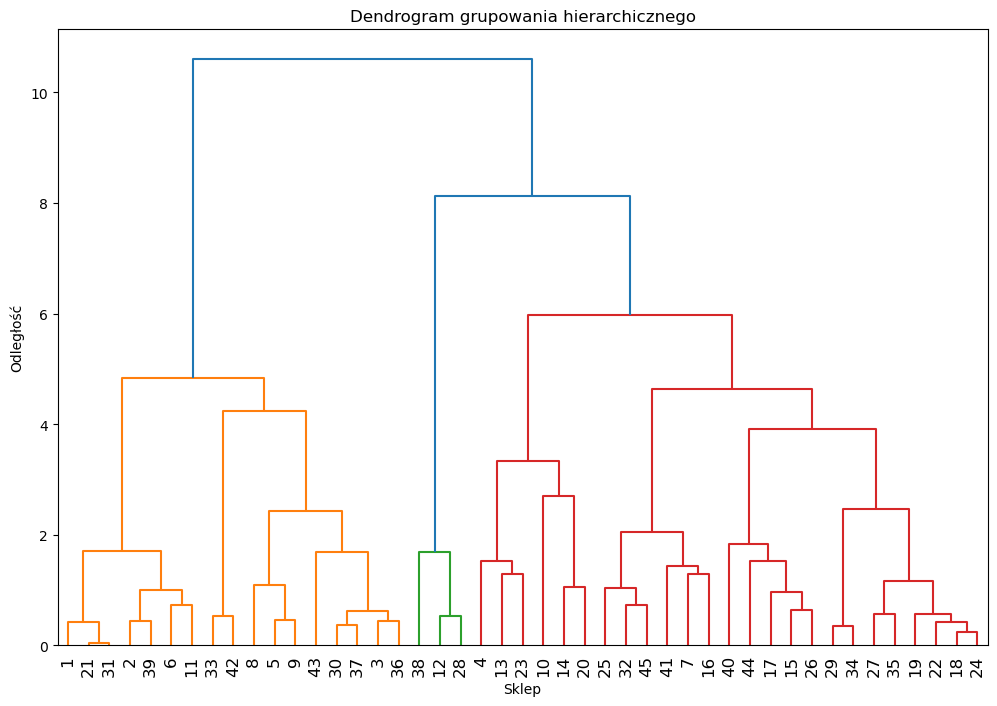

In [446]:

# Grupowanie hierarchiczne
linked = linkage(store_data_scaled, method='ward')

plt.figure(figsize=(12, 8))
dendrogram(linked, labels=store_data['Store'].values, leaf_rotation=90, leaf_font_size=12)
plt.title('Dendrogram grupowania hierarchicznego')
plt.xlabel('Sklep')
plt.ylabel('Odległość')
plt.show()

In [447]:
# Agregacja danych dla każdego klastra
cluster_data = data.merge(store_data[['Store', 'Cluster']], on='Store', how='left')
cluster_analysis = cluster_data.groupby('Cluster').agg({
    'Weekly_Sales': ['mean', 'median', 'std'],
    'Temperature': ['mean', 'median', 'std'],
    'Fuel_Price': ['mean', 'median', 'std'],
    'CPI': ['mean', 'median', 'std'],
    'Unemployment': ['mean', 'median', 'std'],
    'MarkDown1': ['mean', 'median', 'std'],
    'MarkDown2': ['mean', 'median', 'std'],
    'MarkDown3': ['mean', 'median', 'std'],
    'MarkDown4': ['mean', 'median', 'std'],
    'MarkDown5': ['mean', 'median', 'std'],
}).reset_index()

# Spłaszczenie wielopoziomowego indeksu kolumn
cluster_analysis.columns = ['_'.join(col).strip() for col in cluster_analysis.columns.values]

print(cluster_analysis)

   Cluster_  Weekly_Sales_mean  Weekly_Sales_median  Weekly_Sales_std  \
0         0       9.280781e+05           715593.935     525448.948471   
1         1       1.237428e+06          1135172.450     571133.268691   
2         2       7.201077e+05           579544.210     372256.219076   

   Temperature_mean  Temperature_median  Temperature_std  Fuel_Price_mean  \
0         68.144650              70.175        15.142566         3.231100   
1         53.018411              54.120        17.838197         3.400449   
2         67.592967              68.080        17.430030         3.518545   

   Fuel_Price_median  Fuel_Price_std  ...  MarkDown2_std  MarkDown3_mean  \
0              3.297        0.430894  ...    8324.986223     1031.183653   
1              3.530        0.454015  ...   10326.972191     1715.487962   
2              3.620        0.463057  ...    6527.248395      815.086130   

   MarkDown3_median  MarkDown3_std  MarkDown4_mean  MarkDown4_median  \
0            14.100  

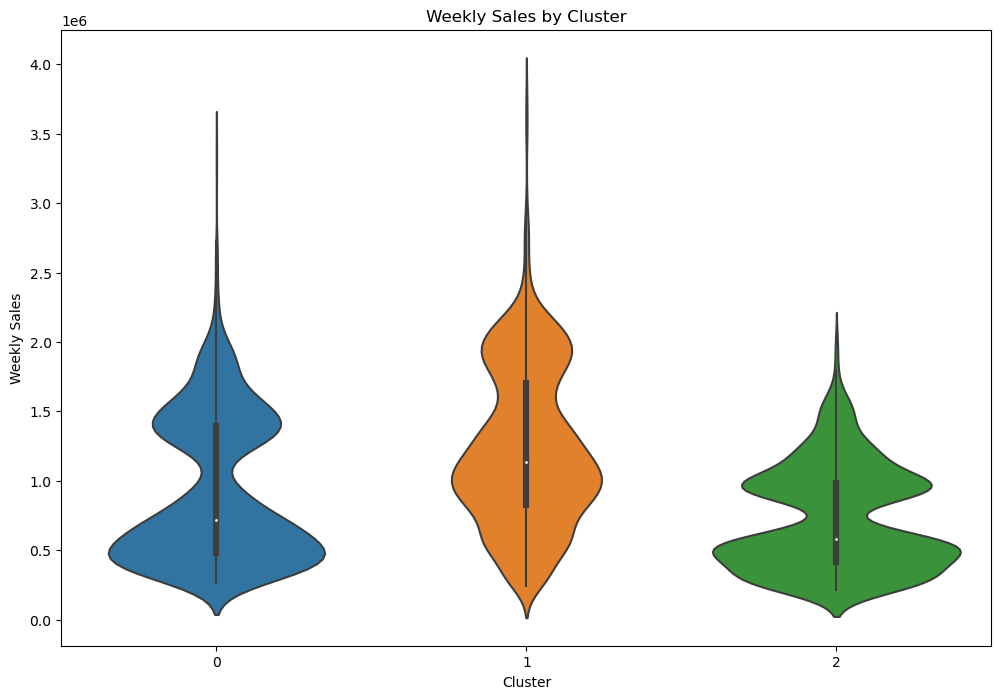

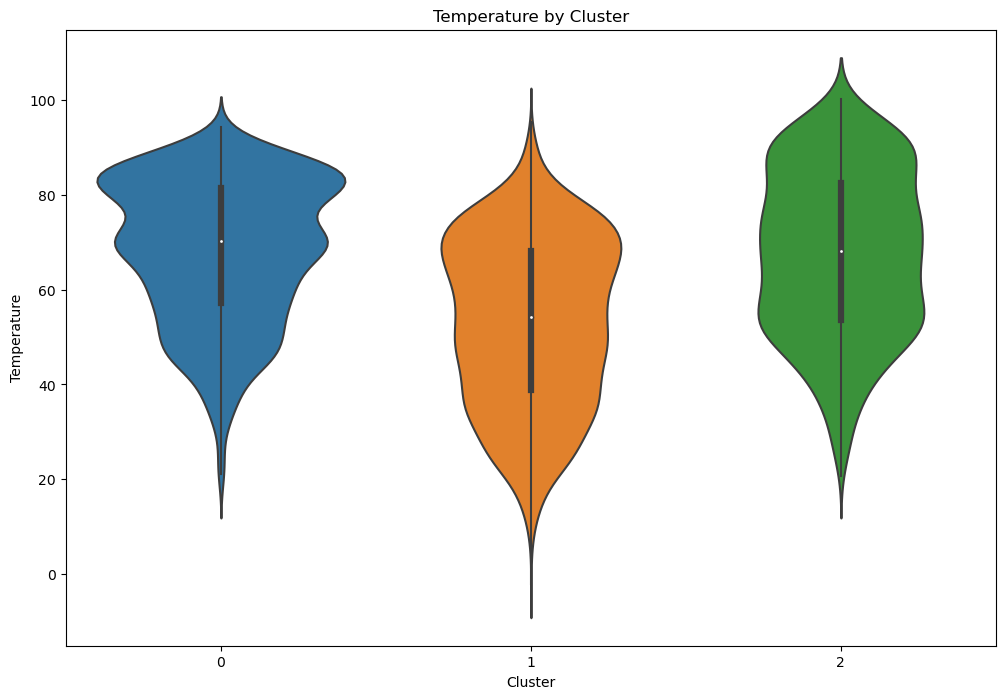

In [448]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='Cluster', y='Weekly_Sales', data=cluster_data)
plt.title('Weekly Sales by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Weekly Sales')
plt.show()

# Wizualizacja: Boxplot temperatury dla klastrów
plt.figure(figsize=(12, 8))
sns.violinplot(x='Cluster', y='Temperature', data=cluster_data)
plt.title('Temperature by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Temperature')
plt.show()

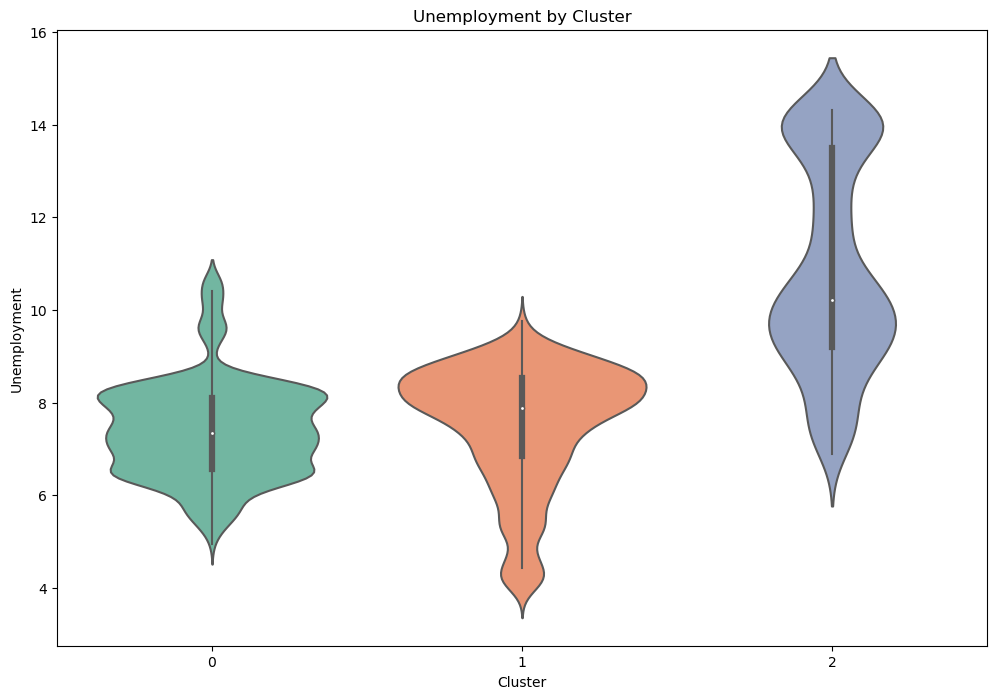

In [454]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='Cluster', y='Unemployment', data=cluster_data, inner='box', palette='Set2')
plt.title('Unemployment by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Unemployment')
plt.show()

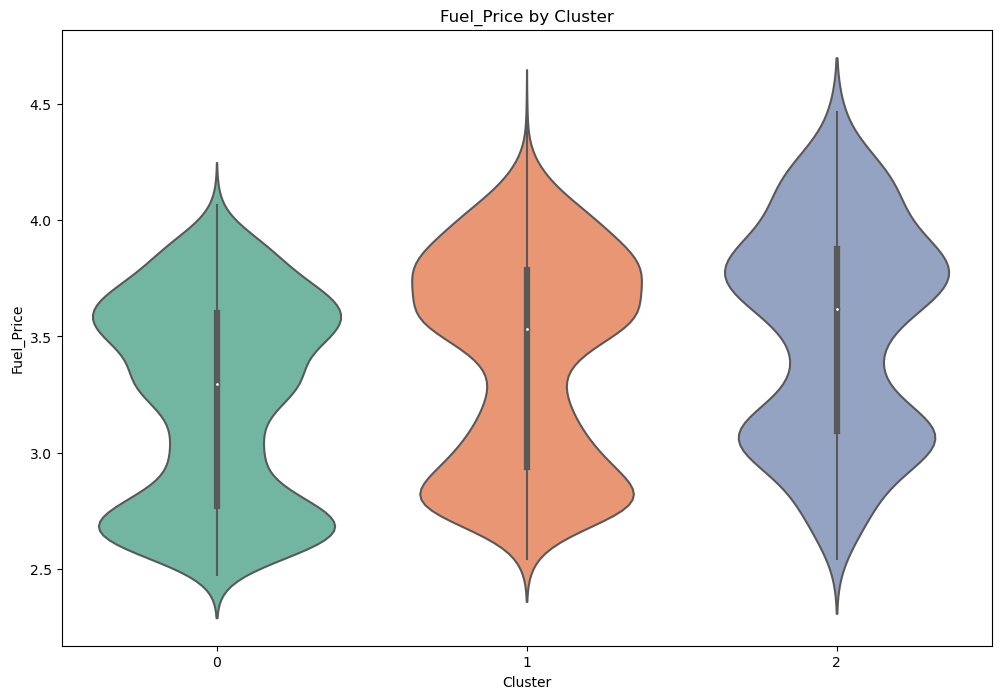

In [450]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='Cluster', y='Fuel_Price', data=cluster_data, inner='box', palette='Set2')
plt.title('Fuel_Price by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Fuel_Price')
plt.show()

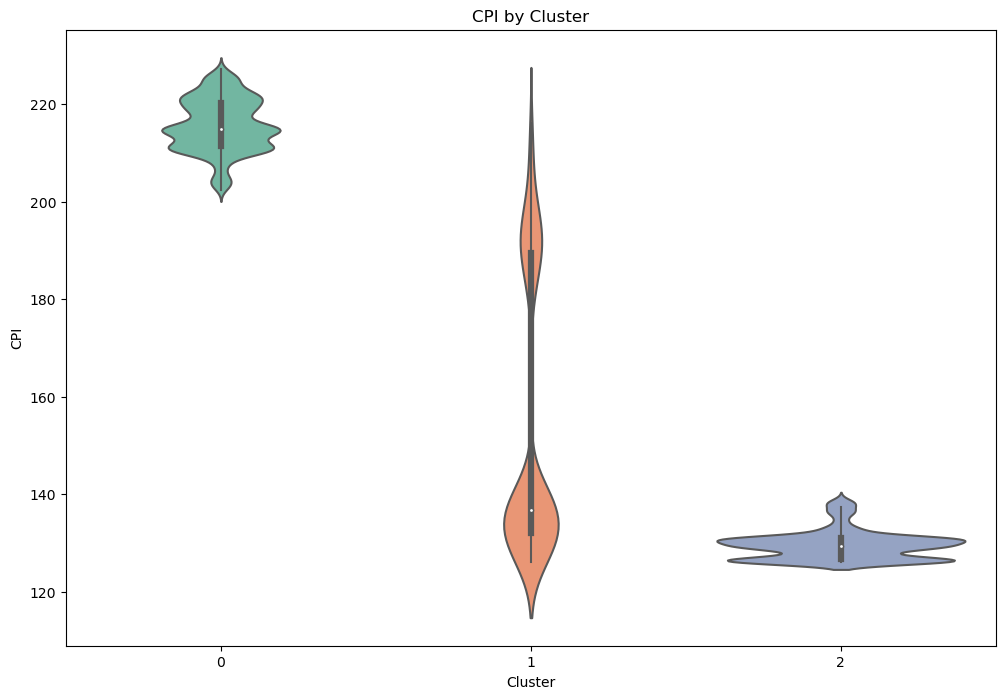

In [451]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='Cluster', y='CPI', data=cluster_data, inner='box', palette='Set2')
plt.title('CPI by Cluster')
plt.xlabel('Cluster')
plt.ylabel('CPI')
plt.show()

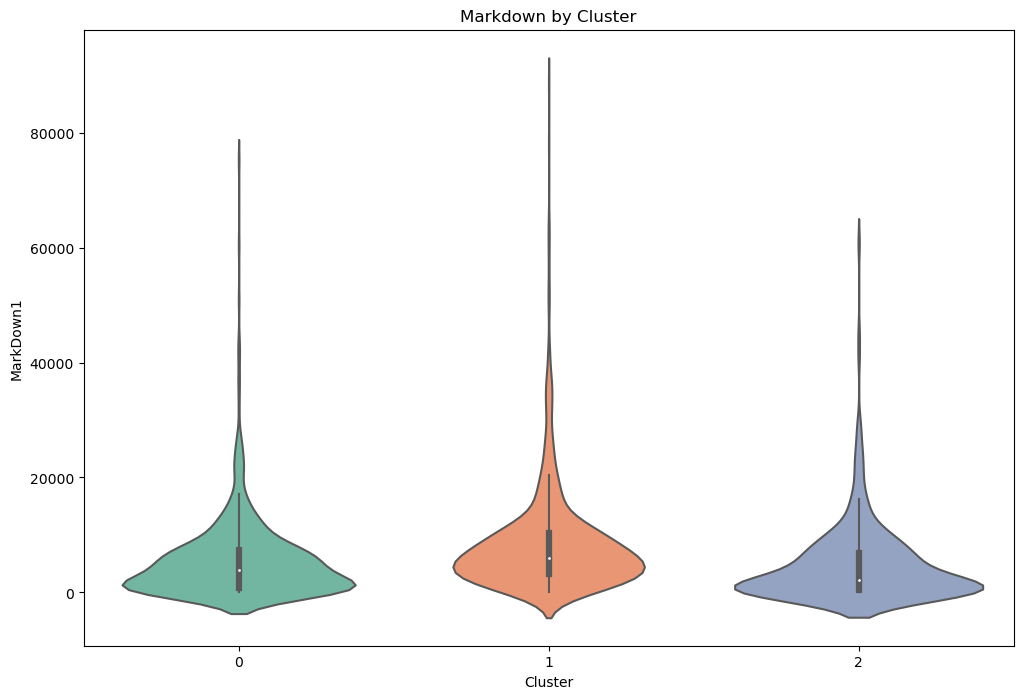

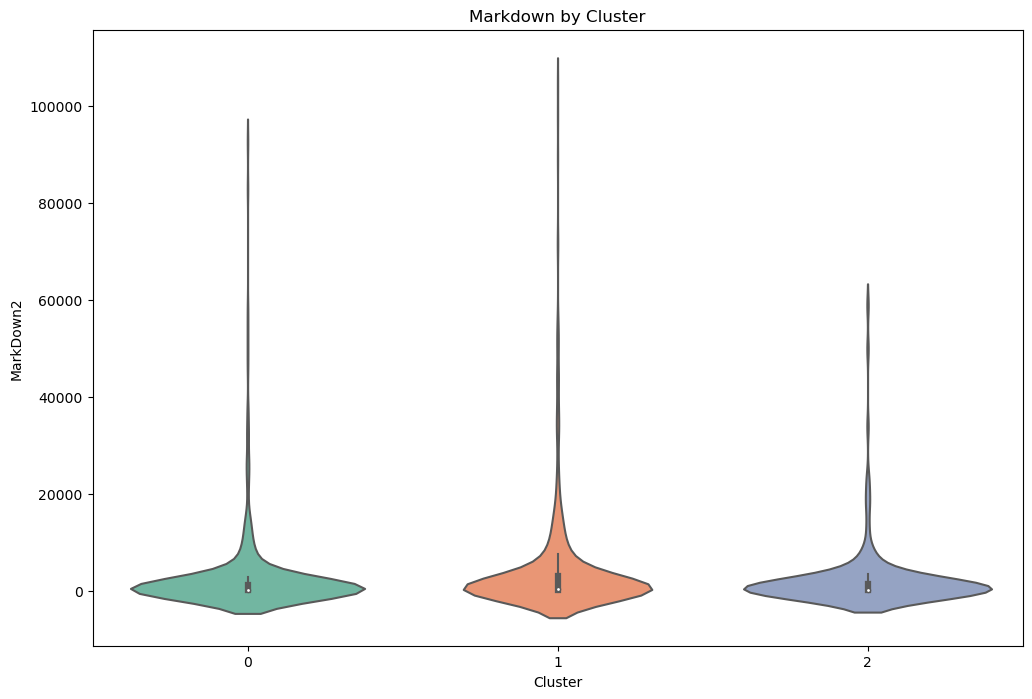

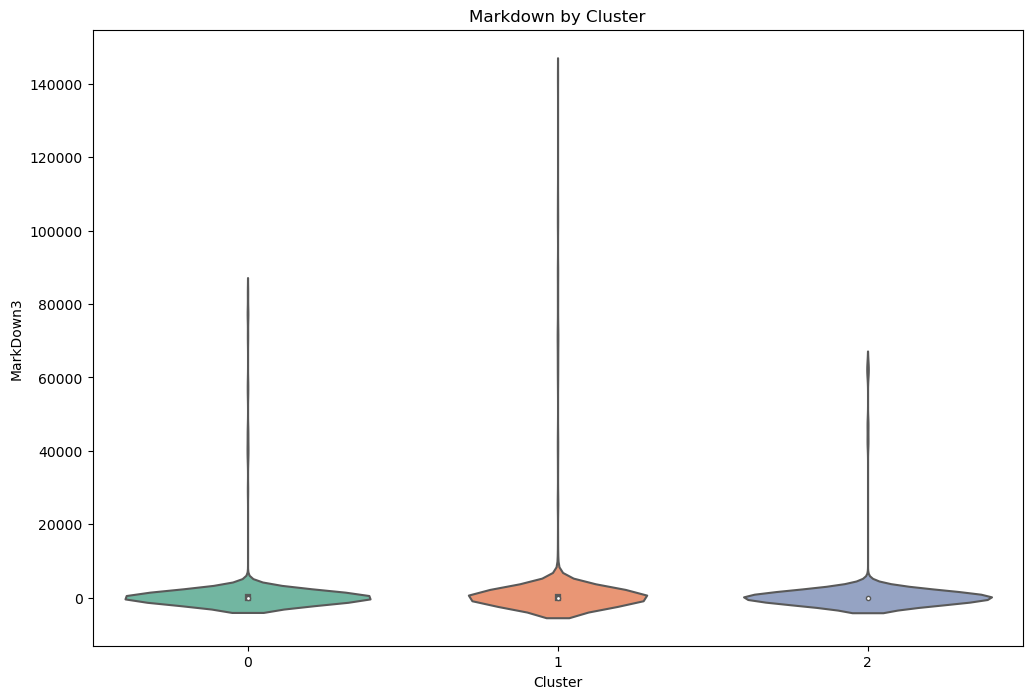

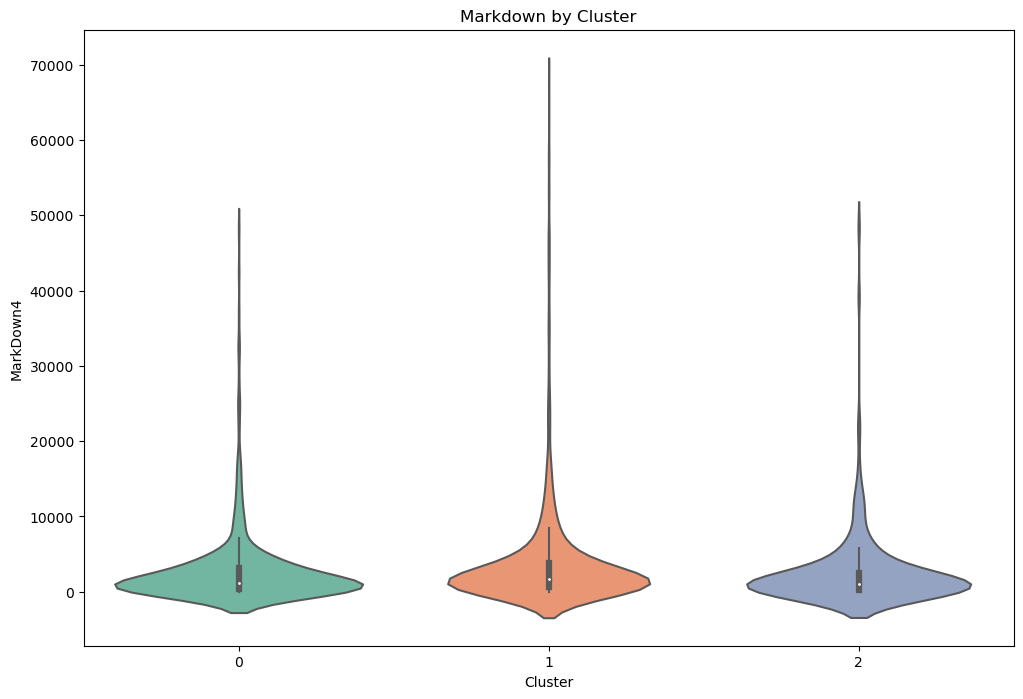

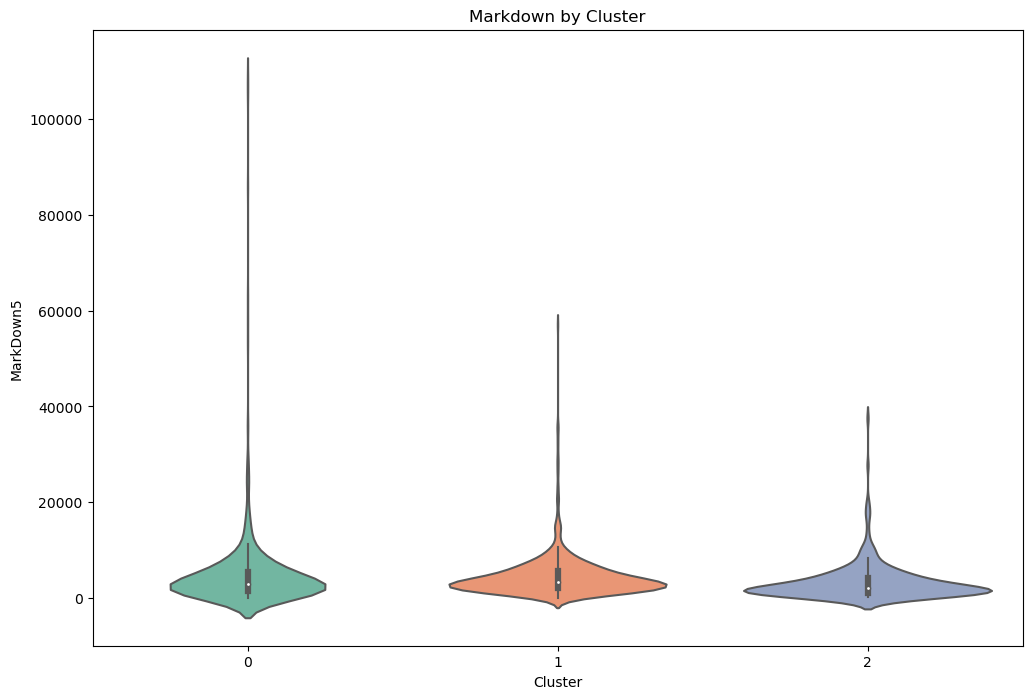

In [453]:
markdowns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for i, md in enumerate(markdowns):
    plt.figure(figsize=(12, 8))
    sns.violinplot(x='Cluster', y=md, data=cluster_data, inner='box', palette='Set2')
    plt.title('Markdown by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(md)
    plt.show()


